# Reference
https://www.kaggle.com/code/amanooo/defect-detection-starter-u-net

In [1]:
from tensorflow.keras.models import load_model
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def dice_coefficient(y_true, y_pred):
    """
    Compute the Dice coefficient between y_true and y_pred.
    
    Args:
    - y_true: Ground truth mask
    - y_pred: Predicted mask
    
    Returns:
    - dice_coeff: The computed Dice coefficient.
    """
    
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Explicitly cast to float32
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)
    
    # Compute the intersection and the sum of the two masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    # Compute Dice coefficient
    dice_coeff = (2. * intersection) / union
    
    return dice_coeff

# Load model with custom objects
model = load_model('models/DefectDetection6.h5', custom_objects={'dice_coefficient': dice_coefficient})

In [2]:
# Binarize the mask output by NN
def binarize(masks, th = 0.5):
    # Maximum value of each channel per pixel
    mask_max = np.zeros_like(masks[:,:,0])
    mask_max = np.fmax(masks[:,:,0],masks[:,:,1])
    mask_max = np.fmax(mask_max,masks[:,:,2])
    mask_max = np.fmax(mask_max,masks[:,:,3])
    # Remove non-maximum pixels
    m = np.zeros_like(masks)
    for ch in range(4):
        m[:,:,ch] = (masks[:,:,ch] == mask_max) * masks[:,:,ch]
    # Binarization
    m = (m>th) * 1
    return m

In [3]:
def show_predict_img(df, row):
    if df == "train_df":
        name = train_df.iloc[row].name
        img = cv2.imread(os.path.join(DIRtrain, name),
                             cv2.IMREAD_GRAYSCALE)
    else:
        if df == "submit_df":
            name = test_df.iloc[row//4,0].split('_')[0]
        elif df == "test_df":
            name = test_df.iloc[row,0]
        img = cv2.imread(os.path.join(DIRtest, name),
                             cv2.IMREAD_GRAYSCALE)

    img_ = img[..., np.newaxis]    # Add channel axis
    img_ = img_[np.newaxis, ...]    # Add batch axis
    img_ = img_ / 255.              # 0～1

    pred_masks = model.predict(img_)
    bin_masks = binarize(pred_masks[0, ...], 0.5)

    fig, axs = plt.subplots(5,2, figsize=(12, 6))
    axs[0,0].imshow(img)
    axs[0,0].axis('off')
    axs[0,0].set_title(name)
    axs[0,1].axis('off')
    axs[0,1].set_title("after binarize")
    for i in range(4):
        axs[i+1,0].imshow(pred_masks[0,:,:,i])
        axs[i+1,0].axis('off')
        axs[i+1,0].set_title('class '+ str(i+1))
        axs[i+1,1].imshow(bin_masks[:,:,i])
        axs[i+1,1].axis('off')
        axs[i+1,1].set_title('class '+ str(i+1))

In [4]:
DIRin1 = "severstal-steel-defect-detection"
DIRtest = os.path.join(DIRin1,"test_images")

In [5]:
submit_df = pd.read_csv(os.path.join(DIRin1,'sample_submission.csv'))
submit_df['EncodedPixels'] = np.nan
submit_df.head(5)

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,NaN,0
1,000ccc2ac.jpg,NaN,0
2,002451917.jpg,NaN,0
3,003c5da97.jpg,NaN,0
4,0042e163f.jpg,NaN,0


In [6]:
temp_df = pd.DataFrame()
temp_df['ImageId'] = submit_df['ImageId']
test_df = pd.DataFrame(temp_df['ImageId'].unique(), columns=['ImageId'])
test_df.head()

,ImageId
0,0000f269f.jpg
1,000ccc2ac.jpg
2,002451917.jpg
3,003c5da97.jpg
4,0042e163f.jpg


In [7]:
# Create new rows by expanding each ImageId into 4 rows with suffixes '_1', '_2', '_3', '_4'
expanded_rows = []

for image_id in submit_df['ImageId']:
    # Append new rows with suffixes '_1', '_2', '_3', '_4'
    for class_id in range(1, 5):
        expanded_rows.append(f"{image_id}_{class_id}")

# Create a new DataFrame with the expanded rows
submit_df = pd.DataFrame({
    'ImageId_ClassId': expanded_rows,
    'EncodedPixels': [''] * len(expanded_rows)  # Initialize EncodedPixels as empty
})



In [8]:
submit_df

,ImageId_ClassId,EncodedPixels
0,0000f269f.jpg_1,
1,0000f269f.jpg_2,
2,0000f269f.jpg_3,
3,0000f269f.jpg_4,
4,000ccc2ac.jpg_1,
...,...,...
22019,fff4fd9bb.jpg_4,
22020,fff598023.jpg_1,
22021,fff598023.jpg_2,
22022,fff598023.jpg_3,


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5506 entries, 0 to 5505
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  5506 non-null   object
dtypes: object(1)
memory usage: 43.1+ KB


In [10]:
def mask2rle(mask):
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[:-1:2]
    return ' '.join(str(x) for x in runs)

In [11]:
def build_rles(masks):
    width, height, depth = masks.shape
    masks = binarize(masks, th = 0.5)
    rles = [mask2rle(masks[:, :, i]) for i in range(depth)]

    return rles
    
# Predict test images
for i, line in tqdm(test_df.iterrows()):
    img = cv2.imread(os.path.join(DIRtest, line['ImageId']),
                     cv2.IMREAD_GRAYSCALE)
    img = img[..., np.newaxis]    # Add channel axis
    img = img[np.newaxis, ...]    # Add butch axis
    img = img / 255.              # 0～1
    pred_masks = model.predict(img)[0]
    rles = build_rles(pred_masks)
    for j in range(4):
        if len(rles[j])>0:
            submit_df.iloc[i*4+j,1] = rles[j]

0it [00:00, ?it/s]

1/1 [==============================] - 4s 4s/step


1it [00:04,  4.56s/it]

1/1 [==============================] - 0s 19ms/step


3it [00:04,  1.25s/it]

1/1 [==============================] - 0s 18ms/step


5it [00:04,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


7it [00:05,  2.41it/s]

1/1 [==============================] - 0s 17ms/step


9it [00:05,  3.43it/s]

1/1 [==============================] - 0s 18ms/step


11it [00:05,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


13it [00:05,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


15it [00:05,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


17it [00:06,  7.54it/s]

1/1 [==============================] - 0s 17ms/step


19it [00:06,  8.36it/s]

1/1 [==============================] - 0s 18ms/step


21it [00:06,  8.95it/s]

1/1 [==============================] - 0s 17ms/step


23it [00:06,  9.64it/s]

1/1 [==============================] - 0s 17ms/step


25it [00:06,  9.78it/s]

1/1 [==============================] - 0s 18ms/step


27it [00:06,  9.90it/s]

1/1 [==============================] - 0s 18ms/step


29it [00:07, 10.10it/s]

1/1 [==============================] - 0s 18ms/step


31it [00:07, 10.08it/s]

1/1 [==============================] - 0s 17ms/step


33it [00:07, 10.06it/s]

1/1 [==============================] - 0s 18ms/step


35it [00:07, 10.22it/s]

1/1 [==============================] - 0s 17ms/step


37it [00:07, 10.03it/s]

1/1 [==============================] - 0s 17ms/step


39it [00:08,  9.63it/s]

1/1 [==============================] - 0s 17ms/step


40it [00:08,  9.37it/s]

1/1 [==============================] - 0s 18ms/step


41it [00:08,  9.34it/s]

1/1 [==============================] - 0s 18ms/step


43it [00:08,  9.66it/s]

1/1 [==============================] - 0s 18ms/step


45it [00:08,  9.87it/s]

1/1 [==============================] - 0s 17ms/step


46it [00:08,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


47it [00:08,  9.79it/s]

1/1 [==============================] - 0s 18ms/step


49it [00:09,  9.97it/s]

1/1 [==============================] - 0s 17ms/step


50it [00:09,  9.80it/s]

1/1 [==============================] - 0s 18ms/step


52it [00:09,  9.94it/s]

1/1 [==============================] - 0s 17ms/step


54it [00:09, 10.05it/s]

1/1 [==============================] - 0s 17ms/step


55it [00:09, 10.04it/s]

1/1 [==============================] - 0s 17ms/step


56it [00:09,  9.89it/s]

1/1 [==============================] - 0s 18ms/step


57it [00:09,  9.91it/s]

1/1 [==============================] - 0s 17ms/step


59it [00:10, 10.00it/s]

1/1 [==============================] - 0s 18ms/step


60it [00:10,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


61it [00:10,  9.93it/s]

1/1 [==============================] - 0s 17ms/step


62it [00:10,  9.59it/s]

1/1 [==============================] - 0s 17ms/step


63it [00:10,  9.63it/s]

1/1 [==============================] - 0s 17ms/step


64it [00:10,  9.68it/s]

1/1 [==============================] - 0s 17ms/step


65it [00:10,  9.40it/s]

1/1 [==============================] - 0s 17ms/step


66it [00:10,  9.46it/s]

1/1 [==============================] - 0s 17ms/step


67it [00:11,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


68it [00:11,  9.60it/s]

1/1 [==============================] - 0s 18ms/step


69it [00:11,  9.60it/s]

1/1 [==============================] - 0s 17ms/step


70it [00:11,  9.61it/s]

1/1 [==============================] - 0s 17ms/step


71it [00:11,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


72it [00:11,  9.64it/s]

1/1 [==============================] - 0s 17ms/step


73it [00:11,  9.59it/s]

1/1 [==============================] - 0s 17ms/step


74it [00:11,  9.56it/s]

1/1 [==============================] - 0s 18ms/step


75it [00:11,  9.57it/s]

1/1 [==============================] - 0s 18ms/step


76it [00:11,  9.50it/s]

1/1 [==============================] - 0s 17ms/step


77it [00:12,  9.43it/s]

1/1 [==============================] - 0s 18ms/step


78it [00:12,  8.95it/s]

1/1 [==============================] - 0s 17ms/step


79it [00:12,  8.71it/s]

1/1 [==============================] - 0s 18ms/step


80it [00:12,  8.66it/s]

1/1 [==============================] - 0s 17ms/step


81it [00:12,  8.63it/s]

1/1 [==============================] - 0s 18ms/step


82it [00:12,  8.62it/s]

1/1 [==============================] - 0s 17ms/step


83it [00:12,  8.36it/s]

1/1 [==============================] - 0s 18ms/step


84it [00:12,  7.92it/s]

1/1 [==============================] - 0s 18ms/step


85it [00:13,  8.01it/s]

1/1 [==============================] - 0s 18ms/step


86it [00:13,  8.16it/s]

1/1 [==============================] - 0s 18ms/step


87it [00:13,  8.27it/s]

1/1 [==============================] - 0s 17ms/step


89it [00:13,  9.33it/s]

1/1 [==============================] - 0s 17ms/step


91it [00:13,  9.92it/s]

1/1 [==============================] - 0s 17ms/step


92it [00:13,  9.85it/s]

1/1 [==============================] - 0s 18ms/step


94it [00:13, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


96it [00:14, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


98it [00:14, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


100it [00:14, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


102it [00:14, 10.84it/s]

1/1 [==============================] - 0s 17ms/step


104it [00:14, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


106it [00:15, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


108it [00:15, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


110it [00:15,  9.88it/s]

1/1 [==============================] - 0s 18ms/step


111it [00:15,  9.51it/s]

1/1 [==============================] - 0s 17ms/step


112it [00:15,  9.06it/s]

1/1 [==============================] - 0s 17ms/step


114it [00:15,  9.63it/s]

1/1 [==============================] - 0s 18ms/step


116it [00:16, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


118it [00:16, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


120it [00:16, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


122it [00:16, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


124it [00:16, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


126it [00:17, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


128it [00:17, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


130it [00:17, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


132it [00:17, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


134it [00:17,  9.84it/s]

1/1 [==============================] - 0s 18ms/step


135it [00:17,  9.35it/s]

1/1 [==============================] - 0s 17ms/step


136it [00:18,  9.21it/s]

1/1 [==============================] - 0s 17ms/step


137it [00:18,  9.10it/s]

1/1 [==============================] - 0s 18ms/step


138it [00:18,  9.03it/s]

1/1 [==============================] - 0s 18ms/step


139it [00:18,  8.95it/s]

1/1 [==============================] - 0s 18ms/step


140it [00:18,  8.88it/s]

1/1 [==============================] - 0s 18ms/step


142it [00:18,  9.73it/s]

1/1 [==============================] - 0s 17ms/step


144it [00:18, 10.14it/s]

1/1 [==============================] - 0s 18ms/step


146it [00:19, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


148it [00:19, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


150it [00:19, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


152it [00:19, 10.21it/s]

1/1 [==============================] - 0s 17ms/step


154it [00:19, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


156it [00:20, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


158it [00:20, 10.19it/s]

1/1 [==============================] - 0s 17ms/step


160it [00:20, 10.00it/s]

1/1 [==============================] - 0s 18ms/step


162it [00:20,  9.59it/s]

1/1 [==============================] - 0s 18ms/step


164it [00:20,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


165it [00:20,  9.28it/s]

1/1 [==============================] - 0s 18ms/step


166it [00:21,  9.10it/s]

1/1 [==============================] - 0s 17ms/step


167it [00:21,  8.67it/s]

1/1 [==============================] - 0s 18ms/step


168it [00:21,  8.61it/s]

1/1 [==============================] - 0s 18ms/step


169it [00:21,  8.46it/s]

1/1 [==============================] - 0s 18ms/step


170it [00:21,  8.28it/s]

1/1 [==============================] - 0s 17ms/step


171it [00:21,  8.03it/s]

1/1 [==============================] - 0s 18ms/step


172it [00:21,  7.90it/s]

1/1 [==============================] - 0s 18ms/step


173it [00:22,  8.00it/s]

1/1 [==============================] - 0s 17ms/step


174it [00:22,  8.15it/s]

1/1 [==============================] - 0s 18ms/step


175it [00:22,  8.13it/s]

1/1 [==============================] - 0s 18ms/step


176it [00:22,  8.05it/s]

1/1 [==============================] - 0s 17ms/step


178it [00:22,  9.23it/s]

1/1 [==============================] - 0s 18ms/step


180it [00:22,  9.87it/s]

1/1 [==============================] - 0s 17ms/step


182it [00:22, 10.23it/s]

1/1 [==============================] - 0s 17ms/step


184it [00:23, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


186it [00:23, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


188it [00:23, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


190it [00:23, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


192it [00:23, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


194it [00:24, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


196it [00:24, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


198it [00:24,  9.70it/s]

1/1 [==============================] - 0s 18ms/step


199it [00:24,  9.44it/s]

1/1 [==============================] - 0s 19ms/step


201it [00:24,  9.78it/s]

1/1 [==============================] - 0s 18ms/step


202it [00:24,  9.78it/s]

1/1 [==============================] - 0s 19ms/step


204it [00:25, 10.09it/s]

1/1 [==============================] - 0s 17ms/step


206it [00:25, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


208it [00:25, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


210it [00:25, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


212it [00:25, 10.74it/s]

1/1 [==============================] - 0s 17ms/step


214it [00:25, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


216it [00:26, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


218it [00:26, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


220it [00:26, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


222it [00:26, 10.57it/s]

1/1 [==============================] - 0s 17ms/step


224it [00:26, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


226it [00:27, 10.30it/s]

1/1 [==============================] - 0s 17ms/step


228it [00:27,  9.86it/s]

1/1 [==============================] - 0s 17ms/step


229it [00:27,  9.84it/s]

1/1 [==============================] - 0s 17ms/step


231it [00:27,  9.79it/s]

1/1 [==============================] - 0s 18ms/step


233it [00:27,  9.59it/s]

1/1 [==============================] - 0s 17ms/step


234it [00:28,  9.39it/s]

1/1 [==============================] - 0s 17ms/step


235it [00:28,  9.05it/s]

1/1 [==============================] - 0s 17ms/step


236it [00:28,  8.96it/s]

1/1 [==============================] - 0s 18ms/step


237it [00:28,  8.90it/s]

1/1 [==============================] - 0s 18ms/step


238it [00:28,  8.43it/s]

1/1 [==============================] - 0s 18ms/step


239it [00:28,  8.44it/s]

1/1 [==============================] - 0s 18ms/step


241it [00:28,  9.41it/s]

1/1 [==============================] - 0s 17ms/step


243it [00:28, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


245it [00:29, 10.44it/s]

1/1 [==============================] - 0s 20ms/step


247it [00:29, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


249it [00:29, 10.61it/s]

1/1 [==============================] - 0s 17ms/step


251it [00:29, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


253it [00:29, 10.78it/s]

1/1 [==============================] - 0s 20ms/step


255it [00:30, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


257it [00:30, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


259it [00:30, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


261it [00:30, 10.34it/s]

1/1 [==============================] - 0s 17ms/step


263it [00:30, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


265it [00:31, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


267it [00:31, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


269it [00:31,  9.94it/s]

1/1 [==============================] - 0s 20ms/step


270it [00:31,  9.66it/s]

1/1 [==============================] - 0s 19ms/step


271it [00:31,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


272it [00:31,  9.63it/s]

1/1 [==============================] - 0s 17ms/step


273it [00:31,  9.69it/s]

1/1 [==============================] - 0s 18ms/step


274it [00:32,  9.73it/s]

1/1 [==============================] - 0s 18ms/step


275it [00:32,  9.77it/s]

1/1 [==============================] - 0s 18ms/step


276it [00:32,  9.81it/s]

1/1 [==============================] - 0s 17ms/step


277it [00:32,  9.67it/s]

1/1 [==============================] - 0s 18ms/step


278it [00:32,  9.17it/s]

1/1 [==============================] - 0s 17ms/step


279it [00:32,  9.32it/s]

1/1 [==============================] - 0s 17ms/step


280it [00:32,  9.00it/s]

1/1 [==============================] - 0s 18ms/step


281it [00:32,  8.78it/s]

1/1 [==============================] - 0s 17ms/step


282it [00:32,  8.62it/s]

1/1 [==============================] - 0s 17ms/step


283it [00:33,  8.51it/s]

1/1 [==============================] - 0s 19ms/step


284it [00:33,  8.31it/s]

1/1 [==============================] - 0s 17ms/step


285it [00:33,  8.21it/s]

1/1 [==============================] - 0s 18ms/step


286it [00:33,  8.32it/s]

1/1 [==============================] - 0s 18ms/step


287it [00:33,  8.34it/s]

1/1 [==============================] - 0s 18ms/step


288it [00:33,  8.40it/s]

1/1 [==============================] - 0s 17ms/step


289it [00:33,  8.81it/s]

1/1 [==============================] - 0s 18ms/step


291it [00:33,  9.74it/s]

1/1 [==============================] - 0s 19ms/step


293it [00:34, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


295it [00:34, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


297it [00:34, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


299it [00:34, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


301it [00:34, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


303it [00:35, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


305it [00:35, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


307it [00:35, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


309it [00:35, 10.22it/s]

1/1 [==============================] - 0s 17ms/step


311it [00:35,  9.80it/s]

1/1 [==============================] - 0s 18ms/step


312it [00:35,  9.61it/s]

1/1 [==============================] - 0s 17ms/step


313it [00:36,  9.47it/s]

1/1 [==============================] - 0s 17ms/step


314it [00:36,  9.26it/s]

1/1 [==============================] - 0s 18ms/step


315it [00:36,  9.12it/s]

1/1 [==============================] - 0s 17ms/step


316it [00:36,  8.63it/s]

1/1 [==============================] - 0s 17ms/step


317it [00:36,  8.56it/s]

1/1 [==============================] - 0s 18ms/step


318it [00:36,  8.26it/s]

1/1 [==============================] - 0s 18ms/step


319it [00:36,  8.32it/s]

1/1 [==============================] - 0s 17ms/step


320it [00:36,  8.37it/s]

1/1 [==============================] - 0s 18ms/step


321it [00:37,  8.01it/s]

1/1 [==============================] - 0s 17ms/step


322it [00:37,  8.14it/s]

1/1 [==============================] - 0s 18ms/step


323it [00:37,  8.06it/s]

1/1 [==============================] - 0s 18ms/step


324it [00:37,  8.22it/s]

1/1 [==============================] - 0s 18ms/step


325it [00:37,  7.97it/s]

1/1 [==============================] - 0s 18ms/step


326it [00:37,  7.98it/s]

1/1 [==============================] - 0s 18ms/step


328it [00:37,  8.76it/s]

1/1 [==============================] - 0s 18ms/step


329it [00:38,  8.72it/s]

1/1 [==============================] - 0s 18ms/step


331it [00:38,  9.50it/s]

1/1 [==============================] - 0s 18ms/step


333it [00:38,  9.95it/s]

1/1 [==============================] - 0s 18ms/step


335it [00:38, 10.20it/s]

1/1 [==============================] - 0s 17ms/step


337it [00:38, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


339it [00:38, 10.57it/s]

1/1 [==============================] - 0s 18ms/step


341it [00:39, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


343it [00:39, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


345it [00:39, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


347it [00:39, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


349it [00:39, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


351it [00:40, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


353it [00:40, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


355it [00:40, 10.19it/s]

1/1 [==============================] - 0s 17ms/step


357it [00:40, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


359it [00:40,  9.81it/s]

1/1 [==============================] - 0s 17ms/step


360it [00:40,  9.79it/s]

1/1 [==============================] - 0s 18ms/step


361it [00:41,  9.79it/s]

1/1 [==============================] - 0s 17ms/step


362it [00:41,  9.77it/s]

1/1 [==============================] - 0s 18ms/step


363it [00:41,  9.78it/s]

1/1 [==============================] - 0s 17ms/step


364it [00:41,  9.73it/s]

1/1 [==============================] - 0s 17ms/step


365it [00:41,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


366it [00:41,  9.80it/s]

1/1 [==============================] - 0s 18ms/step


367it [00:41,  9.77it/s]

1/1 [==============================] - 0s 18ms/step


368it [00:41,  9.31it/s]

1/1 [==============================] - 0s 18ms/step


369it [00:41,  9.00it/s]

1/1 [==============================] - 0s 19ms/step


370it [00:42,  8.73it/s]

1/1 [==============================] - 0s 18ms/step


371it [00:42,  8.65it/s]

1/1 [==============================] - 0s 19ms/step


372it [00:42,  8.55it/s]

1/1 [==============================] - 0s 17ms/step


373it [00:42,  8.55it/s]

1/1 [==============================] - 0s 17ms/step


374it [00:42,  8.62it/s]

1/1 [==============================] - 0s 18ms/step


375it [00:42,  8.59it/s]

1/1 [==============================] - 0s 18ms/step


376it [00:42,  8.58it/s]

1/1 [==============================] - 0s 18ms/step


377it [00:42,  8.55it/s]

1/1 [==============================] - 0s 17ms/step


379it [00:43,  9.59it/s]

1/1 [==============================] - 0s 18ms/step


381it [00:43, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


383it [00:43, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


385it [00:43, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


387it [00:43, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


389it [00:43, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


391it [00:44, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


393it [00:44,  9.20it/s]

1/1 [==============================] - 0s 18ms/step


395it [00:44,  9.73it/s]

1/1 [==============================] - 0s 20ms/step


397it [00:44,  9.46it/s]

1/1 [==============================] - 0s 18ms/step


398it [00:44,  9.07it/s]

1/1 [==============================] - 0s 20ms/step


399it [00:45,  8.86it/s]

1/1 [==============================] - 0s 18ms/step


401it [00:45,  9.34it/s]

1/1 [==============================] - 0s 18ms/step


403it [00:45,  9.75it/s]

1/1 [==============================] - 0s 19ms/step


405it [00:45, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


407it [00:45, 10.15it/s]

1/1 [==============================] - 0s 18ms/step


409it [00:46, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


411it [00:46, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


413it [00:46, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


415it [00:46, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


417it [00:46, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


419it [00:47, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


421it [00:47, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


423it [00:47, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


425it [00:47, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


427it [00:47, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


429it [00:47, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


431it [00:48, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


433it [00:48, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


435it [00:48, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


437it [00:48, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


439it [00:48, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


441it [00:49,  9.83it/s]

1/1 [==============================] - 0s 18ms/step


442it [00:49,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


443it [00:49,  9.33it/s]

1/1 [==============================] - 0s 17ms/step


444it [00:49,  9.12it/s]

1/1 [==============================] - 0s 18ms/step


446it [00:49,  9.70it/s]

1/1 [==============================] - 0s 17ms/step


448it [00:49, 10.00it/s]

1/1 [==============================] - 0s 18ms/step


450it [00:50, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


452it [00:50, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


454it [00:50, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


456it [00:50, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


458it [00:50, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


460it [00:51, 10.11it/s]

1/1 [==============================] - 0s 18ms/step


462it [00:51, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


464it [00:51,  9.97it/s]

1/1 [==============================] - 0s 18ms/step


465it [00:51,  9.63it/s]

1/1 [==============================] - 0s 17ms/step


466it [00:51,  9.33it/s]

1/1 [==============================] - 0s 18ms/step


467it [00:51,  8.74it/s]

1/1 [==============================] - 0s 17ms/step


468it [00:51,  8.65it/s]

1/1 [==============================] - 0s 18ms/step


469it [00:52,  8.66it/s]

1/1 [==============================] - 0s 18ms/step


470it [00:52,  8.60it/s]

1/1 [==============================] - 0s 18ms/step


471it [00:52,  8.55it/s]

1/1 [==============================] - 0s 18ms/step


472it [00:52,  8.57it/s]

1/1 [==============================] - 0s 18ms/step


473it [00:52,  8.58it/s]

1/1 [==============================] - 0s 17ms/step


475it [00:52,  9.53it/s]

1/1 [==============================] - 0s 17ms/step


477it [00:52, 10.00it/s]

1/1 [==============================] - 0s 17ms/step


479it [00:53, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


481it [00:53, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


483it [00:53, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


485it [00:53, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


487it [00:53, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


489it [00:54, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


491it [00:54, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


493it [00:54, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


495it [00:54,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


496it [00:54,  9.48it/s]

1/1 [==============================] - 0s 17ms/step


498it [00:54,  9.88it/s]

1/1 [==============================] - 0s 17ms/step


500it [00:55, 10.22it/s]

1/1 [==============================] - 0s 18ms/step


502it [00:55, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


504it [00:55, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


506it [00:55, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


508it [00:55, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


510it [00:56, 10.72it/s]

1/1 [==============================] - 0s 19ms/step


512it [00:56, 10.74it/s]

1/1 [==============================] - 0s 17ms/step


514it [00:56, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


516it [00:56, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


518it [00:56, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


520it [00:57, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


522it [00:57, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


524it [00:57,  9.92it/s]

1/1 [==============================] - 0s 18ms/step


525it [00:57,  9.63it/s]

1/1 [==============================] - 0s 18ms/step


526it [00:57,  9.41it/s]

1/1 [==============================] - 0s 18ms/step


527it [00:57,  9.14it/s]

1/1 [==============================] - 0s 18ms/step


529it [00:57,  9.76it/s]

1/1 [==============================] - 0s 17ms/step


531it [00:58, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


533it [00:58, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


535it [00:58, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


537it [00:58, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


539it [00:58, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


541it [00:59, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


543it [00:59, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


545it [00:59, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


547it [00:59, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


549it [00:59, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


551it [01:00,  9.98it/s]

1/1 [==============================] - 0s 17ms/step


553it [01:00,  9.81it/s]

1/1 [==============================] - 0s 18ms/step


554it [01:00,  9.60it/s]

1/1 [==============================] - 0s 18ms/step


555it [01:00,  9.26it/s]

1/1 [==============================] - 0s 17ms/step


556it [01:00,  9.03it/s]

1/1 [==============================] - 0s 18ms/step


557it [01:00,  8.63it/s]

1/1 [==============================] - 0s 19ms/step


558it [01:00,  8.53it/s]

1/1 [==============================] - 0s 18ms/step


559it [01:01,  8.49it/s]

1/1 [==============================] - 0s 18ms/step


560it [01:01,  8.53it/s]

1/1 [==============================] - 0s 18ms/step


561it [01:01,  8.55it/s]

1/1 [==============================] - 0s 17ms/step


562it [01:01,  8.31it/s]

1/1 [==============================] - 0s 18ms/step


563it [01:01,  8.34it/s]

1/1 [==============================] - 0s 18ms/step


564it [01:01,  8.44it/s]

1/1 [==============================] - 0s 18ms/step


566it [01:01,  9.40it/s]

1/1 [==============================] - 0s 17ms/step


568it [01:01,  9.87it/s]

1/1 [==============================] - 0s 17ms/step


570it [01:02, 10.31it/s]

1/1 [==============================] - 0s 17ms/step


572it [01:02, 10.23it/s]

1/1 [==============================] - 0s 17ms/step


574it [01:02, 10.22it/s]

1/1 [==============================] - 0s 17ms/step


576it [01:02, 10.26it/s]

1/1 [==============================] - 0s 18ms/step


578it [01:02, 10.46it/s]

1/1 [==============================] - 0s 17ms/step


580it [01:03, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


582it [01:03, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


584it [01:03, 10.04it/s]

1/1 [==============================] - 0s 17ms/step


586it [01:03,  9.29it/s]

1/1 [==============================] - 0s 18ms/step


587it [01:03,  8.87it/s]

1/1 [==============================] - 0s 18ms/step


588it [01:04,  8.47it/s]

1/1 [==============================] - 0s 18ms/step


589it [01:04,  8.25it/s]

1/1 [==============================] - 0s 18ms/step


590it [01:04,  8.08it/s]

1/1 [==============================] - 0s 18ms/step


591it [01:04,  7.86it/s]

1/1 [==============================] - 0s 18ms/step


592it [01:04,  7.75it/s]

1/1 [==============================] - 0s 19ms/step


593it [01:04,  7.83it/s]

1/1 [==============================] - 0s 18ms/step


594it [01:04,  7.71it/s]

1/1 [==============================] - 0s 17ms/step


595it [01:05,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


596it [01:05,  7.63it/s]

1/1 [==============================] - 0s 17ms/step


597it [01:05,  7.74it/s]

1/1 [==============================] - 0s 17ms/step


598it [01:05,  8.22it/s]

1/1 [==============================] - 0s 17ms/step


600it [01:05,  9.16it/s]

1/1 [==============================] - 0s 17ms/step


601it [01:05,  9.31it/s]

1/1 [==============================] - 0s 17ms/step


603it [01:05, 10.02it/s]

1/1 [==============================] - 0s 17ms/step


604it [01:05,  9.95it/s]

1/1 [==============================] - 0s 17ms/step


605it [01:06,  9.95it/s]

1/1 [==============================] - 0s 17ms/step


607it [01:06, 10.38it/s]

1/1 [==============================] - 0s 17ms/step


609it [01:06, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


611it [01:06, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


613it [01:06, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


615it [01:06, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


617it [01:07, 10.21it/s]

1/1 [==============================] - 0s 17ms/step


619it [01:07,  9.49it/s]

1/1 [==============================] - 0s 18ms/step


620it [01:07,  9.25it/s]

1/1 [==============================] - 0s 17ms/step


621it [01:07,  9.13it/s]

1/1 [==============================] - 0s 18ms/step


623it [01:07,  9.60it/s]

1/1 [==============================] - 0s 18ms/step


625it [01:08, 10.00it/s]

1/1 [==============================] - 0s 18ms/step


626it [01:08,  9.77it/s]

1/1 [==============================] - 0s 17ms/step


628it [01:08, 10.11it/s]

1/1 [==============================] - 0s 17ms/step


629it [01:08,  9.84it/s]

1/1 [==============================] - 0s 18ms/step


631it [01:08, 10.15it/s]

1/1 [==============================] - 0s 18ms/step


633it [01:08, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


635it [01:09, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


637it [01:09, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


639it [01:09, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


641it [01:09,  9.86it/s]

1/1 [==============================] - 0s 17ms/step


642it [01:09,  9.45it/s]

1/1 [==============================] - 0s 18ms/step


643it [01:09,  9.17it/s]

1/1 [==============================] - 0s 18ms/step


645it [01:10,  9.66it/s]

1/1 [==============================] - 0s 17ms/step


647it [01:10,  9.81it/s]

1/1 [==============================] - 0s 17ms/step


649it [01:10, 10.08it/s]

1/1 [==============================] - 0s 17ms/step


651it [01:10, 10.22it/s]

1/1 [==============================] - 0s 18ms/step


653it [01:10, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


655it [01:10, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


657it [01:11, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


659it [01:11, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


661it [01:11, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


663it [01:11, 10.11it/s]

1/1 [==============================] - 0s 18ms/step


665it [01:12,  9.37it/s]

1/1 [==============================] - 0s 18ms/step


666it [01:12,  9.22it/s]

1/1 [==============================] - 0s 17ms/step


667it [01:12,  9.02it/s]

1/1 [==============================] - 0s 17ms/step


668it [01:12,  9.22it/s]

1/1 [==============================] - 0s 17ms/step


670it [01:12,  9.61it/s]

1/1 [==============================] - 0s 18ms/step


672it [01:12,  9.99it/s]

1/1 [==============================] - 0s 17ms/step


674it [01:12, 10.14it/s]

1/1 [==============================] - 0s 17ms/step


676it [01:13, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


678it [01:13, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


680it [01:13, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


682it [01:13, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


684it [01:13, 10.46it/s]

1/1 [==============================] - 0s 17ms/step


686it [01:14, 10.57it/s]

1/1 [==============================] - 0s 17ms/step


688it [01:14,  9.64it/s]

1/1 [==============================] - 0s 18ms/step


689it [01:14,  9.44it/s]

1/1 [==============================] - 0s 18ms/step


690it [01:14,  9.24it/s]

1/1 [==============================] - 0s 18ms/step


691it [01:14,  9.08it/s]

1/1 [==============================] - 0s 17ms/step


692it [01:14,  8.80it/s]

1/1 [==============================] - 0s 18ms/step


693it [01:14,  8.75it/s]

1/1 [==============================] - 0s 18ms/step


695it [01:15,  9.46it/s]

1/1 [==============================] - 0s 17ms/step


697it [01:15,  9.84it/s]

1/1 [==============================] - 0s 18ms/step


699it [01:15, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


701it [01:15, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


703it [01:15, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


705it [01:16, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


707it [01:16, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


709it [01:16, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


711it [01:16, 10.33it/s]

1/1 [==============================] - 0s 18ms/step


713it [01:16, 10.09it/s]

1/1 [==============================] - 0s 17ms/step


715it [01:17,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


716it [01:17,  9.14it/s]

1/1 [==============================] - 0s 18ms/step


717it [01:17,  8.84it/s]

1/1 [==============================] - 0s 18ms/step


718it [01:17,  8.81it/s]

1/1 [==============================] - 0s 18ms/step


719it [01:17,  8.76it/s]

1/1 [==============================] - 0s 18ms/step


720it [01:17,  8.70it/s]

1/1 [==============================] - 0s 18ms/step


722it [01:17,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


723it [01:17,  9.62it/s]

1/1 [==============================] - 0s 17ms/step


724it [01:18,  9.69it/s]

1/1 [==============================] - 0s 17ms/step


725it [01:18,  9.49it/s]

1/1 [==============================] - 0s 18ms/step


727it [01:18, 10.02it/s]

1/1 [==============================] - 0s 17ms/step


729it [01:18,  9.80it/s]

1/1 [==============================] - 0s 18ms/step


731it [01:18, 10.18it/s]

1/1 [==============================] - 0s 17ms/step


733it [01:18, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


735it [01:19, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


737it [01:19, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


739it [01:19, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


741it [01:19,  9.77it/s]

1/1 [==============================] - 0s 18ms/step


742it [01:19,  9.41it/s]

1/1 [==============================] - 0s 18ms/step


743it [01:19,  9.23it/s]

1/1 [==============================] - 0s 18ms/step


744it [01:20,  9.08it/s]

1/1 [==============================] - 0s 17ms/step


746it [01:20,  9.43it/s]

1/1 [==============================] - 0s 17ms/step


747it [01:20,  9.49it/s]

1/1 [==============================] - 0s 17ms/step


749it [01:20,  9.77it/s]

1/1 [==============================] - 0s 17ms/step


751it [01:20, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


753it [01:20, 10.26it/s]

1/1 [==============================] - 0s 17ms/step


755it [01:21, 10.14it/s]

1/1 [==============================] - 0s 17ms/step


757it [01:21, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


759it [01:21, 10.11it/s]

1/1 [==============================] - 0s 18ms/step


761it [01:21, 10.14it/s]

1/1 [==============================] - 0s 18ms/step


763it [01:21, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


765it [01:22,  9.77it/s]

1/1 [==============================] - 0s 17ms/step


767it [01:22,  9.95it/s]

1/1 [==============================] - 0s 17ms/step


769it [01:22,  9.99it/s]

1/1 [==============================] - 0s 17ms/step


771it [01:22,  9.94it/s]

1/1 [==============================] - 0s 17ms/step


772it [01:22,  9.73it/s]

1/1 [==============================] - 0s 17ms/step


773it [01:23,  9.69it/s]

1/1 [==============================] - 0s 18ms/step


774it [01:23,  9.68it/s]

1/1 [==============================] - 0s 17ms/step


775it [01:23,  9.73it/s]

1/1 [==============================] - 0s 17ms/step


777it [01:23,  9.86it/s]

1/1 [==============================] - 0s 17ms/step


778it [01:23,  9.62it/s]

1/1 [==============================] - 0s 17ms/step


779it [01:23,  9.69it/s]

1/1 [==============================] - 0s 17ms/step


780it [01:23,  9.74it/s]

1/1 [==============================] - 0s 17ms/step


781it [01:23,  9.43it/s]

1/1 [==============================] - 0s 17ms/step


782it [01:23,  9.53it/s]

1/1 [==============================] - 0s 17ms/step


783it [01:24,  9.02it/s]

1/1 [==============================] - 0s 17ms/step


784it [01:24,  8.81it/s]

1/1 [==============================] - 0s 18ms/step


785it [01:24,  8.43it/s]

1/1 [==============================] - 0s 18ms/step


786it [01:24,  8.39it/s]

1/1 [==============================] - 0s 18ms/step


787it [01:24,  8.13it/s]

1/1 [==============================] - 0s 18ms/step


788it [01:24,  8.23it/s]

1/1 [==============================] - 0s 19ms/step


789it [01:24,  8.55it/s]

1/1 [==============================] - 0s 18ms/step


791it [01:24,  9.56it/s]

1/1 [==============================] - 0s 17ms/step


793it [01:25, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


795it [01:25, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


797it [01:25, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


799it [01:25, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


801it [01:25, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


803it [01:26, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


805it [01:26, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


807it [01:26, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


809it [01:26, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


811it [01:26, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


813it [01:26, 11.17it/s]

1/1 [==============================] - 0s 19ms/step


815it [01:27, 11.02it/s]

1/1 [==============================] - 0s 19ms/step


817it [01:27, 11.01it/s]

1/1 [==============================] - 0s 19ms/step


819it [01:27, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


821it [01:27, 10.97it/s]

1/1 [==============================] - 0s 18ms/step


823it [01:27, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


825it [01:28, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


827it [01:28, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


829it [01:28, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


831it [01:28, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


833it [01:28, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


835it [01:28, 11.34it/s]

1/1 [==============================] - 0s 18ms/step


837it [01:29, 11.43it/s]

1/1 [==============================] - 0s 17ms/step


839it [01:29, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


841it [01:29, 11.43it/s]

1/1 [==============================] - 0s 17ms/step


843it [01:29, 11.50it/s]

1/1 [==============================] - 0s 18ms/step


845it [01:29, 11.53it/s]

1/1 [==============================] - 0s 18ms/step


847it [01:29, 11.52it/s]

1/1 [==============================] - 0s 18ms/step


849it [01:30, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


851it [01:30, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


853it [01:30, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


855it [01:30,  9.99it/s]

1/1 [==============================] - 0s 19ms/step


857it [01:30, 10.19it/s]

1/1 [==============================] - 0s 17ms/step


859it [01:31, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


861it [01:31, 10.23it/s]

1/1 [==============================] - 0s 17ms/step


863it [01:31, 10.33it/s]

1/1 [==============================] - 0s 18ms/step


865it [01:31, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


867it [01:31, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


869it [01:32, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


871it [01:32, 10.74it/s]

1/1 [==============================] - 0s 17ms/step


873it [01:32, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


875it [01:32, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


877it [01:32,  9.83it/s]

1/1 [==============================] - 0s 18ms/step


878it [01:33,  9.47it/s]

1/1 [==============================] - 0s 19ms/step


880it [01:33,  9.89it/s]

1/1 [==============================] - 0s 17ms/step


882it [01:33, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


884it [01:33, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


886it [01:33, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


888it [01:33, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


890it [01:34, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


892it [01:34, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


894it [01:34, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


896it [01:34, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


898it [01:34, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


900it [01:35, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


902it [01:35, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


904it [01:35, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


906it [01:35, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


908it [01:35, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


910it [01:36, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


912it [01:36, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


914it [01:36, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


916it [01:36, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


918it [01:36, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


920it [01:36, 10.22it/s]

1/1 [==============================] - 0s 18ms/step


922it [01:37, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


924it [01:37, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


926it [01:37,  9.76it/s]

1/1 [==============================] - 0s 17ms/step


927it [01:37,  9.47it/s]

1/1 [==============================] - 0s 17ms/step


928it [01:37,  9.56it/s]

1/1 [==============================] - 0s 18ms/step


929it [01:37,  9.60it/s]

1/1 [==============================] - 0s 17ms/step


930it [01:38,  9.60it/s]

1/1 [==============================] - 0s 17ms/step


931it [01:38,  9.34it/s]

1/1 [==============================] - 0s 18ms/step


932it [01:38,  9.44it/s]

1/1 [==============================] - 0s 17ms/step


933it [01:38,  9.49it/s]

1/1 [==============================] - 0s 17ms/step


934it [01:38,  9.45it/s]

1/1 [==============================] - 0s 18ms/step


935it [01:38,  9.07it/s]

1/1 [==============================] - 0s 17ms/step


936it [01:38,  8.82it/s]

1/1 [==============================] - 0s 17ms/step


937it [01:38,  8.47it/s]

1/1 [==============================] - 0s 18ms/step


938it [01:38,  8.51it/s]

1/1 [==============================] - 0s 18ms/step


939it [01:39,  8.54it/s]

1/1 [==============================] - 0s 18ms/step


940it [01:39,  8.32it/s]

1/1 [==============================] - 0s 17ms/step


941it [01:39,  8.38it/s]

1/1 [==============================] - 0s 18ms/step


942it [01:39,  8.42it/s]

1/1 [==============================] - 0s 17ms/step


944it [01:39,  9.37it/s]

1/1 [==============================] - 0s 17ms/step


946it [01:39,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


948it [01:39, 10.21it/s]

1/1 [==============================] - 0s 17ms/step


950it [01:40, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


952it [01:40, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


954it [01:40, 10.39it/s]

1/1 [==============================] - 0s 17ms/step


956it [01:40, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


958it [01:40, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


960it [01:41, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


962it [01:41,  9.98it/s]

1/1 [==============================] - 0s 17ms/step


964it [01:41,  9.43it/s]

1/1 [==============================] - 0s 17ms/step


965it [01:41,  9.27it/s]

1/1 [==============================] - 0s 18ms/step


966it [01:41,  9.07it/s]

1/1 [==============================] - 0s 18ms/step


968it [01:41,  9.69it/s]

1/1 [==============================] - 0s 18ms/step


970it [01:42, 10.01it/s]

1/1 [==============================] - 0s 17ms/step


971it [01:42,  9.55it/s]

1/1 [==============================] - 0s 22ms/step


972it [01:42,  9.18it/s]

1/1 [==============================] - 0s 21ms/step


973it [01:42,  9.20it/s]

1/1 [==============================] - 0s 18ms/step


974it [01:42,  9.02it/s]

1/1 [==============================] - 0s 20ms/step


975it [01:42,  9.08it/s]

1/1 [==============================] - 0s 20ms/step


976it [01:42,  9.29it/s]

1/1 [==============================] - 0s 22ms/step


977it [01:42,  9.31it/s]

1/1 [==============================] - 0s 21ms/step


978it [01:43,  9.37it/s]

1/1 [==============================] - 0s 18ms/step


980it [01:43,  9.99it/s]

1/1 [==============================] - 0s 18ms/step


981it [01:43,  9.75it/s]

1/1 [==============================] - 0s 20ms/step


983it [01:43, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


985it [01:43, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


987it [01:43, 10.25it/s]

1/1 [==============================] - 0s 20ms/step


989it [01:44, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


991it [01:44, 10.67it/s]

1/1 [==============================] - 0s 19ms/step


993it [01:44, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


995it [01:44, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


997it [01:44, 10.49it/s]

1/1 [==============================] - 0s 17ms/step


999it [01:45, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


1001it [01:45,  9.87it/s]

1/1 [==============================] - 0s 17ms/step


1003it [01:45,  9.48it/s]

1/1 [==============================] - 0s 18ms/step


1004it [01:45,  9.16it/s]

1/1 [==============================] - 0s 17ms/step


1006it [01:45,  9.74it/s]

1/1 [==============================] - 0s 18ms/step


1008it [01:46,  9.90it/s]

1/1 [==============================] - 0s 17ms/step


1009it [01:46,  9.90it/s]

1/1 [==============================] - 0s 19ms/step


1011it [01:46, 10.29it/s]

1/1 [==============================] - 0s 19ms/step


1013it [01:46, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


1015it [01:46, 10.65it/s]

1/1 [==============================] - 0s 19ms/step


1017it [01:46, 10.74it/s]

1/1 [==============================] - 0s 16ms/step


1019it [01:47, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


1021it [01:47, 10.78it/s]

1/1 [==============================] - 0s 19ms/step


1023it [01:47, 10.50it/s]

1/1 [==============================] - 0s 19ms/step


1025it [01:47,  9.62it/s]

1/1 [==============================] - 0s 19ms/step


1027it [01:47,  9.87it/s]

1/1 [==============================] - 0s 18ms/step


1029it [01:48, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


1031it [01:48, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


1033it [01:48,  9.72it/s]

1/1 [==============================] - 0s 17ms/step


1035it [01:48, 10.07it/s]

1/1 [==============================] - 0s 17ms/step


1037it [01:48, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


1039it [01:49, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


1041it [01:49, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


1043it [01:49, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


1045it [01:49,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


1046it [01:49,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


1047it [01:49,  9.30it/s]

1/1 [==============================] - 0s 17ms/step


1048it [01:49,  9.41it/s]

1/1 [==============================] - 0s 18ms/step


1050it [01:50,  9.89it/s]

1/1 [==============================] - 0s 17ms/step


1051it [01:50,  9.91it/s]

1/1 [==============================] - 0s 17ms/step


1053it [01:50, 10.22it/s]

1/1 [==============================] - 0s 17ms/step


1055it [01:50, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


1057it [01:50, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


1059it [01:51, 10.20it/s]

1/1 [==============================] - 0s 17ms/step


1061it [01:51, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


1063it [01:51, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


1065it [01:51, 10.18it/s]

1/1 [==============================] - 0s 21ms/step


1067it [01:51,  9.82it/s]

1/1 [==============================] - 0s 18ms/step


1069it [01:52, 10.08it/s]

1/1 [==============================] - 0s 17ms/step


1071it [01:52, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


1073it [01:52, 10.55it/s]

1/1 [==============================] - 0s 21ms/step


1075it [01:52, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


1077it [01:52, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


1079it [01:52, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


1081it [01:53, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


1083it [01:53, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


1085it [01:53, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


1087it [01:53, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


1089it [01:53, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


1091it [01:54, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


1093it [01:54, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


1095it [01:54, 10.05it/s]

1/1 [==============================] - 0s 17ms/step


1097it [01:54, 10.11it/s]

1/1 [==============================] - 0s 17ms/step


1099it [01:54, 10.10it/s]

1/1 [==============================] - 0s 18ms/step


1101it [01:55, 10.02it/s]

1/1 [==============================] - 0s 17ms/step


1103it [01:55, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


1105it [01:55, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


1107it [01:55, 10.57it/s]

1/1 [==============================] - 0s 17ms/step


1109it [01:55, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


1111it [01:55, 10.57it/s]

1/1 [==============================] - 0s 20ms/step


1113it [01:56, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


1115it [01:56,  9.57it/s]

1/1 [==============================] - 0s 18ms/step


1116it [01:56,  9.41it/s]

1/1 [==============================] - 0s 19ms/step


1118it [01:56,  9.90it/s]

1/1 [==============================] - 0s 17ms/step


1120it [01:57,  8.29it/s]

1/1 [==============================] - 0s 18ms/step


1122it [01:57,  9.00it/s]

1/1 [==============================] - 0s 17ms/step


1124it [01:57,  9.56it/s]

1/1 [==============================] - 0s 18ms/step


1126it [01:57,  9.96it/s]

1/1 [==============================] - 0s 18ms/step


1128it [01:57, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


1130it [01:57, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


1132it [01:58,  9.88it/s]

1/1 [==============================] - 0s 18ms/step


1134it [01:58,  9.74it/s]

1/1 [==============================] - 0s 18ms/step


1135it [01:58,  9.18it/s]

1/1 [==============================] - 0s 19ms/step


1136it [01:58,  9.04it/s]

1/1 [==============================] - 0s 19ms/step


1137it [01:58,  8.62it/s]

1/1 [==============================] - 0s 20ms/step


1138it [01:58,  8.42it/s]

1/1 [==============================] - 0s 22ms/step


1139it [01:59,  8.13it/s]

1/1 [==============================] - 0s 19ms/step


1140it [01:59,  8.09it/s]

1/1 [==============================] - 0s 22ms/step


1141it [01:59,  7.91it/s]

1/1 [==============================] - 0s 20ms/step


1142it [01:59,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


1143it [01:59,  7.42it/s]

1/1 [==============================] - 0s 21ms/step


1144it [01:59,  7.39it/s]

1/1 [==============================] - 0s 24ms/step


1145it [01:59,  7.93it/s]

1/1 [==============================] - 0s 24ms/step


1146it [01:59,  8.00it/s]

1/1 [==============================] - 0s 21ms/step


1147it [02:00,  8.34it/s]

1/1 [==============================] - 0s 19ms/step


1148it [02:00,  8.46it/s]

1/1 [==============================] - 0s 19ms/step


1149it [02:00,  8.53it/s]

1/1 [==============================] - 0s 23ms/step


1150it [02:00,  8.71it/s]

1/1 [==============================] - 0s 20ms/step


1151it [02:00,  8.80it/s]

1/1 [==============================] - 0s 24ms/step


1152it [02:00,  8.59it/s]

1/1 [==============================] - 0s 19ms/step


1153it [02:00,  8.87it/s]

1/1 [==============================] - 0s 18ms/step


1154it [02:00,  9.02it/s]

1/1 [==============================] - 0s 19ms/step


1155it [02:00,  9.11it/s]

1/1 [==============================] - 0s 22ms/step


1156it [02:01,  9.13it/s]

1/1 [==============================] - 0s 19ms/step


1157it [02:01,  9.37it/s]

1/1 [==============================] - 0s 23ms/step


1158it [02:01,  8.99it/s]

1/1 [==============================] - 0s 19ms/step


1159it [02:01,  9.12it/s]

1/1 [==============================] - 0s 19ms/step


1160it [02:01,  9.31it/s]

1/1 [==============================] - 0s 21ms/step


1161it [02:01,  8.53it/s]

1/1 [==============================] - 0s 21ms/step


1162it [02:01,  7.71it/s]

1/1 [==============================] - 0s 20ms/step


1163it [02:01,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


1164it [02:02,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


1165it [02:02,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


1166it [02:02,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


1167it [02:02,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


1168it [02:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


1169it [02:02,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


1170it [02:02,  7.49it/s]

1/1 [==============================] - 0s 26ms/step


1171it [02:03,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


1172it [02:03,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


1173it [02:03,  7.56it/s]

1/1 [==============================] - 0s 21ms/step


1174it [02:03,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


1175it [02:03,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


1176it [02:03,  7.58it/s]

1/1 [==============================] - 0s 20ms/step


1177it [02:03,  8.10it/s]

1/1 [==============================] - 0s 20ms/step


1178it [02:03,  7.91it/s]

1/1 [==============================] - 0s 19ms/step


1180it [02:04,  8.63it/s]

1/1 [==============================] - 0s 21ms/step


1181it [02:04,  8.50it/s]

1/1 [==============================] - 0s 21ms/step


1182it [02:04,  8.75it/s]

1/1 [==============================] - 0s 21ms/step


1183it [02:04,  8.77it/s]

1/1 [==============================] - 0s 19ms/step


1184it [02:04,  8.97it/s]

1/1 [==============================] - 0s 19ms/step


1185it [02:04,  8.96it/s]

1/1 [==============================] - 0s 19ms/step


1187it [02:04,  9.15it/s]

1/1 [==============================] - 0s 19ms/step


1188it [02:05,  8.95it/s]

1/1 [==============================] - 0s 19ms/step


1189it [02:05,  8.82it/s]

1/1 [==============================] - 0s 19ms/step


1190it [02:05,  9.02it/s]

1/1 [==============================] - 0s 23ms/step


1191it [02:05,  9.16it/s]

1/1 [==============================] - 0s 19ms/step


1192it [02:05,  8.69it/s]

1/1 [==============================] - 0s 20ms/step


1193it [02:05,  8.27it/s]

1/1 [==============================] - 0s 20ms/step


1194it [02:05,  8.06it/s]

1/1 [==============================] - 0s 18ms/step


1195it [02:05,  8.00it/s]

1/1 [==============================] - 0s 17ms/step


1196it [02:06,  8.08it/s]

1/1 [==============================] - 0s 20ms/step


1197it [02:06,  7.96it/s]

1/1 [==============================] - 0s 22ms/step


1198it [02:06,  7.91it/s]

1/1 [==============================] - 0s 20ms/step


1199it [02:06,  7.65it/s]

1/1 [==============================] - 0s 18ms/step


1200it [02:06,  7.56it/s]

1/1 [==============================] - 0s 21ms/step


1201it [02:06,  7.67it/s]

1/1 [==============================] - 0s 20ms/step


1202it [02:06,  7.74it/s]

1/1 [==============================] - 0s 18ms/step


1203it [02:06,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


1204it [02:07,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


1205it [02:07,  7.70it/s]

1/1 [==============================] - 0s 19ms/step


1206it [02:07,  8.09it/s]

1/1 [==============================] - 0s 18ms/step


1207it [02:07,  8.28it/s]

1/1 [==============================] - 0s 20ms/step


1209it [02:07,  9.13it/s]

1/1 [==============================] - 0s 19ms/step


1210it [02:07,  9.24it/s]

1/1 [==============================] - 0s 18ms/step


1211it [02:07,  9.05it/s]

1/1 [==============================] - 0s 22ms/step


1212it [02:07,  8.95it/s]

1/1 [==============================] - 0s 20ms/step


1213it [02:08,  9.03it/s]

1/1 [==============================] - 0s 18ms/step


1214it [02:08,  8.91it/s]

1/1 [==============================] - 0s 19ms/step


1215it [02:08,  8.89it/s]

1/1 [==============================] - 0s 18ms/step


1216it [02:08,  8.48it/s]

1/1 [==============================] - 0s 18ms/step


1218it [02:08,  9.25it/s]

1/1 [==============================] - 0s 18ms/step


1220it [02:08,  9.49it/s]

1/1 [==============================] - 0s 18ms/step


1221it [02:08,  9.23it/s]

1/1 [==============================] - 0s 19ms/step


1222it [02:09,  9.34it/s]

1/1 [==============================] - 0s 19ms/step


1223it [02:09,  9.19it/s]

1/1 [==============================] - 0s 19ms/step


1224it [02:09,  9.25it/s]

1/1 [==============================] - 0s 19ms/step


1225it [02:09,  8.64it/s]

1/1 [==============================] - 0s 18ms/step


1226it [02:09,  8.55it/s]

1/1 [==============================] - 0s 20ms/step


1227it [02:09,  8.22it/s]

1/1 [==============================] - 0s 17ms/step


1228it [02:09,  8.50it/s]

1/1 [==============================] - 0s 18ms/step


1229it [02:09,  8.71it/s]

1/1 [==============================] - 0s 19ms/step


1230it [02:09,  8.89it/s]

1/1 [==============================] - 0s 18ms/step


1231it [02:10,  8.74it/s]

1/1 [==============================] - 0s 19ms/step


1232it [02:10,  8.50it/s]

1/1 [==============================] - 0s 18ms/step


1233it [02:10,  8.39it/s]

1/1 [==============================] - 0s 18ms/step


1234it [02:10,  8.35it/s]

1/1 [==============================] - 0s 18ms/step


1235it [02:10,  8.20it/s]

1/1 [==============================] - 0s 19ms/step


1236it [02:10,  8.16it/s]

1/1 [==============================] - 0s 19ms/step


1237it [02:10,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


1238it [02:11,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


1239it [02:11,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


1240it [02:11,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


1241it [02:11,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


1242it [02:11,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


1243it [02:11,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


1244it [02:11,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


1245it [02:11,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


1247it [02:12,  8.48it/s]

1/1 [==============================] - 0s 21ms/step


1248it [02:12,  8.27it/s]

1/1 [==============================] - 0s 25ms/step


1249it [02:12,  8.34it/s]

1/1 [==============================] - 0s 22ms/step


1250it [02:12,  8.49it/s]

1/1 [==============================] - 0s 24ms/step


1251it [02:12,  8.63it/s]

1/1 [==============================] - 0s 24ms/step


1252it [02:12,  8.46it/s]

1/1 [==============================] - 0s 23ms/step


1253it [02:12,  8.51it/s]

1/1 [==============================] - 0s 24ms/step


1254it [02:13,  8.62it/s]

1/1 [==============================] - 0s 24ms/step


1255it [02:13,  8.71it/s]

1/1 [==============================] - 0s 24ms/step


1256it [02:13,  8.75it/s]

1/1 [==============================] - 0s 23ms/step


1257it [02:13,  8.71it/s]

1/1 [==============================] - 0s 23ms/step


1258it [02:13,  8.55it/s]

1/1 [==============================] - 0s 25ms/step


1259it [02:13,  8.62it/s]

1/1 [==============================] - 0s 22ms/step


1260it [02:13,  8.71it/s]

1/1 [==============================] - 0s 23ms/step


1261it [02:13,  8.68it/s]

1/1 [==============================] - 0s 23ms/step


1262it [02:13,  8.13it/s]

1/1 [==============================] - 0s 25ms/step


1263it [02:14,  7.68it/s]

1/1 [==============================] - 0s 25ms/step


1264it [02:14,  7.43it/s]

1/1 [==============================] - 0s 23ms/step


1265it [02:14,  7.34it/s]

1/1 [==============================] - 0s 26ms/step


1266it [02:14,  7.20it/s]

1/1 [==============================] - 0s 24ms/step


1267it [02:14,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


1268it [02:14,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


1269it [02:14,  7.17it/s]

1/1 [==============================] - 0s 25ms/step


1270it [02:15,  7.16it/s]

1/1 [==============================] - 0s 25ms/step


1271it [02:15,  7.09it/s]

1/1 [==============================] - 0s 24ms/step


1272it [02:15,  7.20it/s]

1/1 [==============================] - 0s 25ms/step


1273it [02:15,  7.17it/s]

1/1 [==============================] - 0s 24ms/step


1274it [02:15,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


1275it [02:15,  7.47it/s]

1/1 [==============================] - 0s 23ms/step


1276it [02:15,  7.52it/s]

1/1 [==============================] - 0s 23ms/step


1277it [02:16,  7.69it/s]

1/1 [==============================] - 0s 25ms/step


1278it [02:16,  7.76it/s]

1/1 [==============================] - 0s 24ms/step


1279it [02:16,  7.91it/s]

1/1 [==============================] - 0s 23ms/step


1280it [02:16,  8.21it/s]

1/1 [==============================] - 0s 25ms/step


1281it [02:16,  8.35it/s]

1/1 [==============================] - 0s 23ms/step


1282it [02:16,  8.65it/s]

1/1 [==============================] - 0s 23ms/step


1283it [02:16,  8.87it/s]

1/1 [==============================] - 0s 21ms/step


1284it [02:16,  9.15it/s]

1/1 [==============================] - 0s 20ms/step


1285it [02:16,  9.13it/s]

1/1 [==============================] - 0s 20ms/step


1287it [02:17,  9.58it/s]

1/1 [==============================] - 0s 22ms/step


1288it [02:17,  9.65it/s]

1/1 [==============================] - 0s 21ms/step


1289it [02:17,  9.43it/s]

1/1 [==============================] - 0s 21ms/step


1290it [02:17,  9.43it/s]

1/1 [==============================] - 0s 18ms/step


1291it [02:17,  8.94it/s]

1/1 [==============================] - 0s 22ms/step


1292it [02:17,  8.54it/s]

1/1 [==============================] - 0s 21ms/step


1293it [02:17,  8.20it/s]

1/1 [==============================] - 0s 20ms/step


1294it [02:17,  8.08it/s]

1/1 [==============================] - 0s 19ms/step


1295it [02:18,  7.96it/s]

1/1 [==============================] - 0s 19ms/step


1296it [02:18,  7.72it/s]

1/1 [==============================] - 0s 22ms/step


1297it [02:18,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


1298it [02:18,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


1299it [02:18,  7.66it/s]

1/1 [==============================] - 0s 19ms/step


1300it [02:18,  7.69it/s]

1/1 [==============================] - 0s 20ms/step


1301it [02:18,  7.65it/s]

1/1 [==============================] - 0s 22ms/step


1302it [02:19,  7.61it/s]

1/1 [==============================] - 0s 23ms/step


1303it [02:19,  7.64it/s]

1/1 [==============================] - 0s 22ms/step


1304it [02:19,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


1305it [02:19,  7.67it/s]

1/1 [==============================] - 0s 22ms/step


1306it [02:19,  7.68it/s]

1/1 [==============================] - 0s 19ms/step


1307it [02:19,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


1308it [02:19,  7.52it/s]

1/1 [==============================] - 0s 23ms/step


1309it [02:19,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


1310it [02:20,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


1311it [02:20,  7.66it/s]

1/1 [==============================] - 0s 19ms/step


1312it [02:20,  7.74it/s]

1/1 [==============================] - 0s 19ms/step


1313it [02:20,  7.91it/s]

1/1 [==============================] - 0s 19ms/step


1315it [02:20,  8.97it/s]

1/1 [==============================] - 0s 18ms/step


1317it [02:20,  9.64it/s]

1/1 [==============================] - 0s 18ms/step


1318it [02:20,  9.47it/s]

1/1 [==============================] - 0s 18ms/step


1319it [02:21,  9.42it/s]

1/1 [==============================] - 0s 18ms/step


1321it [02:21, 10.00it/s]

1/1 [==============================] - 0s 17ms/step


1323it [02:21,  9.98it/s]

1/1 [==============================] - 0s 23ms/step


1324it [02:21,  9.76it/s]

1/1 [==============================] - 0s 22ms/step


1325it [02:21,  9.64it/s]

1/1 [==============================] - 0s 22ms/step


1326it [02:21,  9.52it/s]

1/1 [==============================] - 0s 24ms/step


1327it [02:21,  9.14it/s]

1/1 [==============================] - 0s 26ms/step


1328it [02:22,  8.97it/s]

1/1 [==============================] - 0s 23ms/step


1329it [02:22,  8.91it/s]

1/1 [==============================] - 0s 23ms/step


1330it [02:22,  9.03it/s]

1/1 [==============================] - 0s 27ms/step


1331it [02:22,  8.35it/s]

1/1 [==============================] - 0s 24ms/step


1332it [02:22,  7.67it/s]

1/1 [==============================] - 0s 24ms/step


1333it [02:22,  7.87it/s]

1/1 [==============================] - 0s 24ms/step


1334it [02:22,  7.62it/s]

1/1 [==============================] - 0s 26ms/step


1335it [02:22,  7.54it/s]

1/1 [==============================] - 0s 22ms/step


1336it [02:23,  7.60it/s]

1/1 [==============================] - 0s 23ms/step


1337it [02:23,  7.26it/s]

1/1 [==============================] - 0s 24ms/step


1338it [02:23,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


1339it [02:23,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


1340it [02:23,  7.15it/s]

1/1 [==============================] - 0s 26ms/step


1341it [02:23,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


1342it [02:23,  6.80it/s]

1/1 [==============================] - 0s 24ms/step


1343it [02:24,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


1344it [02:24,  6.73it/s]

1/1 [==============================] - 0s 24ms/step


1345it [02:24,  6.74it/s]

1/1 [==============================] - 0s 24ms/step


1346it [02:24,  6.84it/s]

1/1 [==============================] - 0s 25ms/step


1347it [02:24,  7.29it/s]

1/1 [==============================] - 0s 25ms/step


1348it [02:24,  7.51it/s]

1/1 [==============================] - 0s 25ms/step


1349it [02:24,  7.85it/s]

1/1 [==============================] - 0s 22ms/step


1350it [02:24,  7.97it/s]

1/1 [==============================] - 0s 24ms/step


1351it [02:25,  8.00it/s]

1/1 [==============================] - 0s 26ms/step


1352it [02:25,  8.23it/s]

1/1 [==============================] - 0s 24ms/step


1353it [02:25,  8.04it/s]

1/1 [==============================] - 0s 23ms/step


1354it [02:25,  8.27it/s]

1/1 [==============================] - 0s 22ms/step


1355it [02:25,  8.13it/s]

1/1 [==============================] - 0s 23ms/step


1356it [02:25,  8.37it/s]

1/1 [==============================] - 0s 24ms/step


1357it [02:25,  8.44it/s]

1/1 [==============================] - 0s 23ms/step


1358it [02:25,  8.39it/s]

1/1 [==============================] - 0s 23ms/step


1359it [02:26,  8.35it/s]

1/1 [==============================] - 0s 23ms/step


1360it [02:26,  8.49it/s]

1/1 [==============================] - 0s 24ms/step


1361it [02:26,  8.24it/s]

1/1 [==============================] - 0s 23ms/step


1362it [02:26,  7.91it/s]

1/1 [==============================] - 0s 24ms/step


1363it [02:26,  7.66it/s]

1/1 [==============================] - 0s 25ms/step


1364it [02:26,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


1365it [02:26,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


1366it [02:27,  6.89it/s]

1/1 [==============================] - 0s 26ms/step


1367it [02:27,  6.87it/s]

1/1 [==============================] - 0s 27ms/step


1368it [02:27,  6.69it/s]

1/1 [==============================] - 0s 24ms/step


1369it [02:27,  6.65it/s]

1/1 [==============================] - 0s 24ms/step


1370it [02:27,  6.77it/s]

1/1 [==============================] - 0s 25ms/step


1371it [02:27,  6.63it/s]

1/1 [==============================] - 0s 23ms/step


1372it [02:27,  6.64it/s]

1/1 [==============================] - 0s 25ms/step


1373it [02:28,  6.76it/s]

1/1 [==============================] - 0s 27ms/step


1374it [02:28,  6.70it/s]

1/1 [==============================] - 0s 25ms/step


1375it [02:28,  6.70it/s]

1/1 [==============================] - 0s 23ms/step


1376it [02:28,  6.84it/s]

1/1 [==============================] - 0s 24ms/step


1377it [02:28,  6.94it/s]

1/1 [==============================] - 0s 24ms/step


1378it [02:28,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


1379it [02:28,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


1380it [02:29,  7.60it/s]

1/1 [==============================] - 0s 23ms/step


1381it [02:29,  7.96it/s]

1/1 [==============================] - 0s 24ms/step


1382it [02:29,  7.80it/s]

1/1 [==============================] - 0s 26ms/step


1383it [02:29,  7.70it/s]

1/1 [==============================] - 0s 26ms/step


1384it [02:29,  8.01it/s]

1/1 [==============================] - 0s 25ms/step


1385it [02:29,  8.22it/s]

1/1 [==============================] - 0s 25ms/step


1386it [02:29,  8.34it/s]

1/1 [==============================] - 0s 22ms/step


1387it [02:29,  8.23it/s]

1/1 [==============================] - 0s 26ms/step


1388it [02:30,  8.14it/s]

1/1 [==============================] - 0s 24ms/step


1389it [02:30,  8.10it/s]

1/1 [==============================] - 0s 24ms/step


1390it [02:30,  8.07it/s]

1/1 [==============================] - 0s 24ms/step


1391it [02:30,  8.29it/s]

1/1 [==============================] - 0s 22ms/step


1392it [02:30,  8.45it/s]

1/1 [==============================] - 0s 22ms/step


1393it [02:30,  8.63it/s]

1/1 [==============================] - 0s 25ms/step


1394it [02:30,  8.72it/s]

1/1 [==============================] - 0s 22ms/step


1395it [02:30,  8.16it/s]

1/1 [==============================] - 0s 23ms/step


1396it [02:31,  7.77it/s]

1/1 [==============================] - 0s 24ms/step


1397it [02:31,  7.35it/s]

1/1 [==============================] - 0s 22ms/step


1398it [02:31,  7.26it/s]

1/1 [==============================] - 0s 25ms/step


1399it [02:31,  7.28it/s]

1/1 [==============================] - 0s 23ms/step


1400it [02:31,  7.27it/s]

1/1 [==============================] - 0s 23ms/step


1401it [02:31,  7.26it/s]

1/1 [==============================] - 0s 23ms/step


1402it [02:31,  7.23it/s]

1/1 [==============================] - 0s 23ms/step


1403it [02:32,  7.22it/s]

1/1 [==============================] - 0s 23ms/step


1404it [02:32,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


1405it [02:32,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


1406it [02:32,  7.13it/s]

1/1 [==============================] - 0s 23ms/step


1407it [02:32,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


1408it [02:32,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


1409it [02:32,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


1410it [02:32,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


1411it [02:33,  7.31it/s]

1/1 [==============================] - 0s 22ms/step


1412it [02:33,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


1413it [02:33,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


1414it [02:33,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


1415it [02:33,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


1416it [02:33,  7.71it/s]

1/1 [==============================] - 0s 19ms/step


1417it [02:33,  7.87it/s]

1/1 [==============================] - 0s 22ms/step


1418it [02:34,  7.87it/s]

1/1 [==============================] - 0s 19ms/step


1419it [02:34,  7.98it/s]

1/1 [==============================] - 0s 19ms/step


1421it [02:34,  8.98it/s]

1/1 [==============================] - 0s 19ms/step


1423it [02:34,  9.52it/s]

1/1 [==============================] - 0s 19ms/step


1425it [02:34,  9.88it/s]

1/1 [==============================] - 0s 18ms/step


1427it [02:34, 10.14it/s]

1/1 [==============================] - 0s 19ms/step


1429it [02:35, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


1431it [02:35, 10.50it/s]

1/1 [==============================] - 0s 19ms/step


1433it [02:35, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


1435it [02:35, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


1437it [02:35, 10.48it/s]

1/1 [==============================] - 0s 19ms/step


1439it [02:36, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


1441it [02:36,  9.85it/s]

1/1 [==============================] - 0s 17ms/step


1443it [02:36, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


1445it [02:36,  9.96it/s]

1/1 [==============================] - 0s 17ms/step


1447it [02:36, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


1449it [02:37, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


1451it [02:37, 10.47it/s]

1/1 [==============================] - 0s 19ms/step


1453it [02:37, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


1455it [02:37, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


1457it [02:37, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


1459it [02:37, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


1461it [02:38,  9.77it/s]

1/1 [==============================] - 0s 17ms/step


1462it [02:38,  9.48it/s]

1/1 [==============================] - 0s 18ms/step


1463it [02:38,  9.19it/s]

1/1 [==============================] - 0s 17ms/step


1464it [02:38,  9.00it/s]

1/1 [==============================] - 0s 17ms/step


1465it [02:38,  8.94it/s]

1/1 [==============================] - 0s 17ms/step


1466it [02:38,  8.88it/s]

1/1 [==============================] - 0s 18ms/step


1467it [02:38,  8.77it/s]

1/1 [==============================] - 0s 18ms/step


1468it [02:39,  8.75it/s]

1/1 [==============================] - 0s 18ms/step


1469it [02:39,  8.67it/s]

1/1 [==============================] - 0s 17ms/step


1471it [02:39,  9.57it/s]

1/1 [==============================] - 0s 18ms/step


1473it [02:39, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


1475it [02:39, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


1477it [02:39, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


1479it [02:40, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


1481it [02:40, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


1483it [02:40, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


1485it [02:40, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


1487it [02:40, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


1489it [02:41, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


1491it [02:41,  9.86it/s]

1/1 [==============================] - 0s 18ms/step


1492it [02:41,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


1493it [02:41,  9.19it/s]

1/1 [==============================] - 0s 18ms/step


1494it [02:41,  9.06it/s]

1/1 [==============================] - 0s 17ms/step


1496it [02:41,  9.72it/s]

1/1 [==============================] - 0s 17ms/step


1498it [02:41, 10.18it/s]

1/1 [==============================] - 0s 17ms/step


1500it [02:42, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


1502it [02:42, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


1504it [02:42, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


1506it [02:42, 10.57it/s]

1/1 [==============================] - 0s 17ms/step


1508it [02:42, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


1510it [02:43, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


1512it [02:43, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


1514it [02:43, 10.56it/s]

1/1 [==============================] - 0s 17ms/step


1516it [02:43, 10.23it/s]

1/1 [==============================] - 0s 17ms/step


1518it [02:43, 10.38it/s]

1/1 [==============================] - 0s 17ms/step


1520it [02:44, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


1522it [02:44, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


1524it [02:44, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


1526it [02:44, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


1528it [02:44, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


1530it [02:45, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


1532it [02:45, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


1534it [02:45, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


1536it [02:45,  9.92it/s]

1/1 [==============================] - 0s 18ms/step


1537it [02:45,  9.90it/s]

1/1 [==============================] - 0s 18ms/step


1538it [02:45,  9.86it/s]

1/1 [==============================] - 0s 18ms/step


1539it [02:45,  9.72it/s]

1/1 [==============================] - 0s 18ms/step


1540it [02:46,  9.26it/s]

1/1 [==============================] - 0s 19ms/step


1541it [02:46,  8.82it/s]

1/1 [==============================] - 0s 19ms/step


1542it [02:46,  8.54it/s]

1/1 [==============================] - 0s 19ms/step


1543it [02:46,  8.36it/s]

1/1 [==============================] - 0s 19ms/step


1544it [02:46,  8.30it/s]

1/1 [==============================] - 0s 20ms/step


1545it [02:46,  7.96it/s]

1/1 [==============================] - 0s 20ms/step


1546it [02:46,  7.97it/s]

1/1 [==============================] - 0s 19ms/step


1547it [02:46,  8.11it/s]

1/1 [==============================] - 0s 18ms/step


1548it [02:47,  8.20it/s]

1/1 [==============================] - 0s 18ms/step


1549it [02:47,  7.84it/s]

1/1 [==============================] - 0s 20ms/step


1550it [02:47,  7.81it/s]

1/1 [==============================] - 0s 20ms/step


1551it [02:47,  7.83it/s]

1/1 [==============================] - 0s 18ms/step


1552it [02:47,  7.96it/s]

1/1 [==============================] - 0s 18ms/step


1553it [02:47,  8.10it/s]

1/1 [==============================] - 0s 18ms/step


1554it [02:47,  8.13it/s]

1/1 [==============================] - 0s 19ms/step


1556it [02:48,  9.10it/s]

1/1 [==============================] - 0s 19ms/step


1558it [02:48,  9.81it/s]

1/1 [==============================] - 0s 18ms/step


1560it [02:48, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


1562it [02:48, 10.46it/s]

1/1 [==============================] - 0s 17ms/step


1564it [02:48, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


1566it [02:48, 10.76it/s]

1/1 [==============================] - 0s 20ms/step


1568it [02:49, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


1570it [02:49, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


1572it [02:49, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


1574it [02:49, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


1576it [02:49,  9.39it/s]

1/1 [==============================] - 0s 18ms/step


1577it [02:50,  9.03it/s]

1/1 [==============================] - 0s 19ms/step


1578it [02:50,  8.80it/s]

1/1 [==============================] - 0s 18ms/step


1579it [02:50,  8.44it/s]

1/1 [==============================] - 0s 19ms/step


1580it [02:50,  8.17it/s]

1/1 [==============================] - 0s 19ms/step


1581it [02:50,  8.17it/s]

1/1 [==============================] - 0s 18ms/step


1582it [02:50,  8.25it/s]

1/1 [==============================] - 0s 18ms/step


1583it [02:50,  8.25it/s]

1/1 [==============================] - 0s 18ms/step


1584it [02:50,  8.49it/s]

1/1 [==============================] - 0s 17ms/step


1586it [02:51,  9.32it/s]

1/1 [==============================] - 0s 19ms/step


1587it [02:51,  9.47it/s]

1/1 [==============================] - 0s 18ms/step


1589it [02:51,  9.70it/s]

1/1 [==============================] - 0s 18ms/step


1591it [02:51,  9.83it/s]

1/1 [==============================] - 0s 18ms/step


1593it [02:51, 10.04it/s]

1/1 [==============================] - 0s 19ms/step


1595it [02:52, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


1597it [02:52, 10.26it/s]

1/1 [==============================] - 0s 18ms/step


1599it [02:52, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


1601it [02:52, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


1603it [02:52,  9.60it/s]

1/1 [==============================] - 0s 18ms/step


1604it [02:52,  9.35it/s]

1/1 [==============================] - 0s 18ms/step


1605it [02:53,  9.05it/s]

1/1 [==============================] - 0s 20ms/step


1606it [02:53,  8.57it/s]

1/1 [==============================] - 0s 18ms/step


1607it [02:53,  8.37it/s]

1/1 [==============================] - 0s 18ms/step


1608it [02:53,  8.17it/s]

1/1 [==============================] - 0s 18ms/step


1610it [02:53,  8.82it/s]

1/1 [==============================] - 0s 18ms/step


1612it [02:53,  9.43it/s]

1/1 [==============================] - 0s 18ms/step


1613it [02:53,  9.45it/s]

1/1 [==============================] - 0s 21ms/step


1615it [02:54,  9.63it/s]

1/1 [==============================] - 0s 19ms/step


1616it [02:54,  9.34it/s]

1/1 [==============================] - 0s 18ms/step


1618it [02:54,  9.85it/s]

1/1 [==============================] - 0s 18ms/step


1620it [02:54, 10.15it/s]

1/1 [==============================] - 0s 19ms/step


1621it [02:54,  9.90it/s]

1/1 [==============================] - 0s 18ms/step


1622it [02:54,  9.78it/s]

1/1 [==============================] - 0s 17ms/step


1624it [02:55, 10.03it/s]

1/1 [==============================] - 0s 17ms/step


1626it [02:55, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


1628it [02:55, 10.20it/s]

1/1 [==============================] - 0s 19ms/step


1630it [02:55,  9.71it/s]

1/1 [==============================] - 0s 18ms/step


1631it [02:55,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


1633it [02:56,  9.64it/s]

1/1 [==============================] - 0s 18ms/step


1634it [02:56,  9.68it/s]

1/1 [==============================] - 0s 18ms/step


1635it [02:56,  9.52it/s]

1/1 [==============================] - 0s 19ms/step


1636it [02:56,  9.41it/s]

1/1 [==============================] - 0s 19ms/step


1637it [02:56,  9.33it/s]

1/1 [==============================] - 0s 19ms/step


1638it [02:56,  9.04it/s]

1/1 [==============================] - 0s 18ms/step


1639it [02:56,  9.12it/s]

1/1 [==============================] - 0s 18ms/step


1640it [02:56,  9.18it/s]

1/1 [==============================] - 0s 19ms/step


1641it [02:56,  9.13it/s]

1/1 [==============================] - 0s 18ms/step


1642it [02:56,  9.17it/s]

1/1 [==============================] - 0s 18ms/step


1643it [02:57,  8.94it/s]

1/1 [==============================] - 0s 18ms/step


1644it [02:57,  9.06it/s]

1/1 [==============================] - 0s 18ms/step


1645it [02:57,  8.99it/s]

1/1 [==============================] - 0s 18ms/step


1646it [02:57,  9.11it/s]

1/1 [==============================] - 0s 18ms/step


1647it [02:57,  8.53it/s]

1/1 [==============================] - 0s 19ms/step


1648it [02:57,  8.34it/s]

1/1 [==============================] - 0s 20ms/step


1649it [02:57,  8.25it/s]

1/1 [==============================] - 0s 19ms/step


1650it [02:57,  8.27it/s]

1/1 [==============================] - 0s 18ms/step


1651it [02:58,  8.23it/s]

1/1 [==============================] - 0s 17ms/step


1652it [02:58,  8.28it/s]

1/1 [==============================] - 0s 19ms/step


1653it [02:58,  8.19it/s]

1/1 [==============================] - 0s 19ms/step


1655it [02:58,  9.01it/s]

1/1 [==============================] - 0s 18ms/step


1657it [02:58,  9.55it/s]

1/1 [==============================] - 0s 20ms/step


1658it [02:58,  9.31it/s]

1/1 [==============================] - 0s 19ms/step


1660it [02:59,  9.64it/s]

1/1 [==============================] - 0s 18ms/step


1662it [02:59,  9.75it/s]

1/1 [==============================] - 0s 19ms/step


1663it [02:59,  9.68it/s]

1/1 [==============================] - 0s 18ms/step


1665it [02:59,  9.98it/s]

1/1 [==============================] - 0s 18ms/step


1667it [02:59, 10.22it/s]

1/1 [==============================] - 0s 17ms/step


1669it [02:59, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


1671it [03:00, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


1673it [03:00,  9.36it/s]

1/1 [==============================] - 0s 18ms/step


1674it [03:00,  8.92it/s]

1/1 [==============================] - 0s 17ms/step


1675it [03:00,  8.78it/s]

1/1 [==============================] - 0s 17ms/step


1676it [03:00,  8.70it/s]

1/1 [==============================] - 0s 19ms/step


1677it [03:00,  8.96it/s]

1/1 [==============================] - 0s 18ms/step


1679it [03:01,  9.65it/s]

1/1 [==============================] - 0s 18ms/step


1681it [03:01,  9.92it/s]

1/1 [==============================] - 0s 17ms/step


1683it [03:01, 10.10it/s]

1/1 [==============================] - 0s 20ms/step


1685it [03:01, 10.10it/s]

1/1 [==============================] - 0s 18ms/step


1687it [03:01, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


1689it [03:01, 10.27it/s]

1/1 [==============================] - 0s 17ms/step


1691it [03:02, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


1693it [03:02, 10.09it/s]

1/1 [==============================] - 0s 17ms/step


1695it [03:02, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


1697it [03:02,  9.64it/s]

1/1 [==============================] - 0s 20ms/step


1698it [03:02,  9.38it/s]

1/1 [==============================] - 0s 18ms/step


1700it [03:03,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


1701it [03:03,  9.43it/s]

1/1 [==============================] - 0s 18ms/step


1702it [03:03,  9.26it/s]

1/1 [==============================] - 0s 17ms/step


1704it [03:03,  9.64it/s]

1/1 [==============================] - 0s 18ms/step


1705it [03:03,  9.23it/s]

1/1 [==============================] - 0s 17ms/step


1706it [03:03,  8.97it/s]

1/1 [==============================] - 0s 19ms/step


1707it [03:03,  8.57it/s]

1/1 [==============================] - 0s 18ms/step


1708it [03:04,  8.54it/s]

1/1 [==============================] - 0s 19ms/step


1709it [03:04,  8.25it/s]

1/1 [==============================] - 0s 18ms/step


1711it [03:04,  9.20it/s]

1/1 [==============================] - 0s 17ms/step


1713it [03:04,  9.80it/s]

1/1 [==============================] - 0s 17ms/step


1714it [03:04,  9.64it/s]

1/1 [==============================] - 0s 18ms/step


1716it [03:04,  9.87it/s]

1/1 [==============================] - 0s 17ms/step


1718it [03:05, 10.21it/s]

1/1 [==============================] - 0s 17ms/step


1720it [03:05, 10.27it/s]

1/1 [==============================] - 0s 17ms/step


1722it [03:05, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


1724it [03:05, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


1726it [03:05, 10.48it/s]

1/1 [==============================] - 0s 17ms/step


1728it [03:05, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


1730it [03:06,  9.73it/s]

1/1 [==============================] - 0s 18ms/step


1731it [03:06,  9.41it/s]

1/1 [==============================] - 0s 17ms/step


1732it [03:06,  9.22it/s]

1/1 [==============================] - 0s 18ms/step


1733it [03:06,  9.02it/s]

1/1 [==============================] - 0s 17ms/step


1735it [03:06,  9.44it/s]

1/1 [==============================] - 0s 18ms/step


1737it [03:06,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


1739it [03:07,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


1741it [03:07, 10.11it/s]

1/1 [==============================] - 0s 18ms/step


1743it [03:07, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


1745it [03:07, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


1747it [03:07, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


1749it [03:08, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


1751it [03:08, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


1753it [03:08, 10.11it/s]

1/1 [==============================] - 0s 17ms/step


1755it [03:08,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


1756it [03:08,  9.32it/s]

1/1 [==============================] - 0s 17ms/step


1757it [03:08,  9.11it/s]

1/1 [==============================] - 0s 19ms/step


1759it [03:09,  9.63it/s]

1/1 [==============================] - 0s 17ms/step


1760it [03:09,  9.55it/s]

1/1 [==============================] - 0s 18ms/step


1762it [03:09,  9.99it/s]

1/1 [==============================] - 0s 17ms/step


1764it [03:09, 10.26it/s]

1/1 [==============================] - 0s 17ms/step


1766it [03:09, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


1768it [03:10, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


1770it [03:10, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


1772it [03:10, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


1774it [03:10, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


1776it [03:10, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


1778it [03:11,  9.52it/s]

1/1 [==============================] - 0s 18ms/step


1779it [03:11,  9.26it/s]

1/1 [==============================] - 0s 17ms/step


1780it [03:11,  9.07it/s]

1/1 [==============================] - 0s 18ms/step


1781it [03:11,  8.88it/s]

1/1 [==============================] - 0s 17ms/step


1782it [03:11,  8.81it/s]

1/1 [==============================] - 0s 18ms/step


1783it [03:11,  8.42it/s]

1/1 [==============================] - 0s 19ms/step


1784it [03:11,  8.41it/s]

1/1 [==============================] - 0s 18ms/step


1786it [03:11,  9.24it/s]

1/1 [==============================] - 0s 18ms/step


1788it [03:12,  9.42it/s]

1/1 [==============================] - 0s 18ms/step


1790it [03:12,  9.79it/s]

1/1 [==============================] - 0s 17ms/step


1792it [03:12, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


1794it [03:12, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


1796it [03:12, 10.07it/s]

1/1 [==============================] - 0s 17ms/step


1798it [03:13, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


1800it [03:13, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


1802it [03:13,  9.97it/s]

1/1 [==============================] - 0s 18ms/step


1804it [03:13,  9.59it/s]

1/1 [==============================] - 0s 18ms/step


1805it [03:13,  9.32it/s]

1/1 [==============================] - 0s 18ms/step


1806it [03:13,  9.09it/s]

1/1 [==============================] - 0s 18ms/step


1807it [03:14,  8.76it/s]

1/1 [==============================] - 0s 18ms/step


1808it [03:14,  8.47it/s]

1/1 [==============================] - 0s 17ms/step


1809it [03:14,  8.47it/s]

1/1 [==============================] - 0s 17ms/step


1810it [03:14,  8.55it/s]

1/1 [==============================] - 0s 18ms/step


1811it [03:14,  8.53it/s]

1/1 [==============================] - 0s 17ms/step


1813it [03:14,  9.46it/s]

1/1 [==============================] - 0s 18ms/step


1814it [03:14,  9.53it/s]

1/1 [==============================] - 0s 17ms/step


1816it [03:15, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


1818it [03:15, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


1820it [03:15, 10.39it/s]

1/1 [==============================] - 0s 17ms/step


1822it [03:15, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


1824it [03:15, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


1826it [03:15, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


1828it [03:16, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


1830it [03:16, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


1832it [03:16, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


1834it [03:16, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


1836it [03:16,  9.92it/s]

1/1 [==============================] - 0s 17ms/step


1837it [03:17,  9.60it/s]

1/1 [==============================] - 0s 17ms/step


1838it [03:17,  9.33it/s]

1/1 [==============================] - 0s 18ms/step


1839it [03:17,  9.22it/s]

1/1 [==============================] - 0s 18ms/step


1841it [03:17,  9.31it/s]

1/1 [==============================] - 0s 18ms/step


1842it [03:17,  9.45it/s]

1/1 [==============================] - 0s 17ms/step


1843it [03:17,  9.55it/s]

1/1 [==============================] - 0s 17ms/step


1844it [03:17,  9.40it/s]

1/1 [==============================] - 0s 17ms/step


1845it [03:17,  9.48it/s]

1/1 [==============================] - 0s 17ms/step


1846it [03:18,  9.03it/s]

1/1 [==============================] - 0s 17ms/step


1847it [03:18,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


1848it [03:18,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


1849it [03:18,  7.69it/s]

1/1 [==============================] - 0s 17ms/step


1850it [03:18,  8.12it/s]

1/1 [==============================] - 0s 18ms/step


1851it [03:18,  7.85it/s]

1/1 [==============================] - 0s 17ms/step


1852it [03:18,  7.95it/s]

1/1 [==============================] - 0s 18ms/step


1853it [03:19,  8.06it/s]

1/1 [==============================] - 0s 17ms/step


1854it [03:19,  8.18it/s]

1/1 [==============================] - 0s 18ms/step


1855it [03:19,  7.89it/s]

1/1 [==============================] - 0s 17ms/step


1856it [03:19,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


1858it [03:19,  8.86it/s]

1/1 [==============================] - 0s 17ms/step


1860it [03:19,  9.44it/s]

1/1 [==============================] - 0s 17ms/step


1862it [03:19,  9.94it/s]

1/1 [==============================] - 0s 18ms/step


1864it [03:20, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


1866it [03:20, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


1868it [03:20, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


1870it [03:20, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


1872it [03:20, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


1874it [03:21, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


1876it [03:21,  9.83it/s]

1/1 [==============================] - 0s 17ms/step


1877it [03:21,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


1878it [03:21,  9.17it/s]

1/1 [==============================] - 0s 18ms/step


1879it [03:21,  9.02it/s]

1/1 [==============================] - 0s 18ms/step


1880it [03:21,  8.92it/s]

1/1 [==============================] - 0s 17ms/step


1881it [03:21,  8.86it/s]

1/1 [==============================] - 0s 18ms/step


1882it [03:22,  8.81it/s]

1/1 [==============================] - 0s 18ms/step


1884it [03:22,  9.52it/s]

1/1 [==============================] - 0s 17ms/step


1886it [03:22, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


1888it [03:22, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


1890it [03:22, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


1892it [03:23, 10.57it/s]

1/1 [==============================] - 0s 17ms/step


1894it [03:23, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


1896it [03:23, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


1898it [03:23, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


1900it [03:23, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


1902it [03:23, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


1904it [03:24, 10.15it/s]

1/1 [==============================] - 0s 18ms/step


1906it [03:24, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


1908it [03:24, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


1910it [03:24, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


1912it [03:24, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


1914it [03:25, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


1916it [03:25, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


1918it [03:25, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


1920it [03:25, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


1922it [03:25, 10.22it/s]

1/1 [==============================] - 0s 18ms/step


1924it [03:26,  9.50it/s]

1/1 [==============================] - 0s 17ms/step


1925it [03:26,  9.33it/s]

1/1 [==============================] - 0s 19ms/step


1926it [03:26,  9.01it/s]

1/1 [==============================] - 0s 17ms/step


1927it [03:26,  8.87it/s]

1/1 [==============================] - 0s 17ms/step


1929it [03:26,  9.64it/s]

1/1 [==============================] - 0s 18ms/step


1931it [03:26, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


1933it [03:27, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


1935it [03:27, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


1937it [03:27, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


1939it [03:27, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


1941it [03:27, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


1943it [03:27, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


1945it [03:28, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


1947it [03:28,  9.95it/s]

1/1 [==============================] - 0s 18ms/step


1949it [03:28,  9.45it/s]

1/1 [==============================] - 0s 18ms/step


1950it [03:28,  9.24it/s]

1/1 [==============================] - 0s 18ms/step


1951it [03:28,  9.12it/s]

1/1 [==============================] - 0s 18ms/step


1952it [03:28,  9.04it/s]

1/1 [==============================] - 0s 17ms/step


1953it [03:29,  8.91it/s]

1/1 [==============================] - 0s 18ms/step


1955it [03:29,  9.67it/s]

1/1 [==============================] - 0s 18ms/step


1957it [03:29, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


1959it [03:29, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


1961it [03:29, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


1963it [03:29, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


1965it [03:30, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


1967it [03:30, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


1969it [03:30, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


1971it [03:30, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


1973it [03:30, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


1975it [03:31,  9.99it/s]

1/1 [==============================] - 0s 18ms/step


1977it [03:31,  9.56it/s]

1/1 [==============================] - 0s 17ms/step


1978it [03:31,  9.38it/s]

1/1 [==============================] - 0s 17ms/step


1979it [03:31,  9.39it/s]

1/1 [==============================] - 0s 17ms/step


1981it [03:31,  9.75it/s]

1/1 [==============================] - 0s 18ms/step


1983it [03:31, 10.20it/s]

1/1 [==============================] - 0s 17ms/step


1985it [03:32, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


1987it [03:32, 10.26it/s]

1/1 [==============================] - 0s 17ms/step


1989it [03:32, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


1991it [03:32, 10.64it/s]

1/1 [==============================] - 0s 19ms/step


1993it [03:32, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


1995it [03:33, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


1997it [03:33, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


1999it [03:33,  9.67it/s]

1/1 [==============================] - 0s 17ms/step


2001it [03:33,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


2003it [03:33, 10.06it/s]

1/1 [==============================] - 0s 18ms/step


2005it [03:34,  9.94it/s]

1/1 [==============================] - 0s 17ms/step


2007it [03:34, 10.00it/s]

1/1 [==============================] - 0s 18ms/step


2009it [03:34, 10.11it/s]

1/1 [==============================] - 0s 18ms/step


2011it [03:34, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


2013it [03:34, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


2015it [03:35, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


2017it [03:35, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


2019it [03:35,  9.32it/s]

1/1 [==============================] - 0s 17ms/step


2020it [03:35,  9.23it/s]

1/1 [==============================] - 0s 17ms/step


2021it [03:35,  9.11it/s]

1/1 [==============================] - 0s 18ms/step


2022it [03:35,  8.99it/s]

1/1 [==============================] - 0s 18ms/step


2023it [03:36,  8.61it/s]

1/1 [==============================] - 0s 17ms/step


2024it [03:36,  8.61it/s]

1/1 [==============================] - 0s 17ms/step


2026it [03:36,  9.44it/s]

1/1 [==============================] - 0s 17ms/step


2027it [03:36,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


2029it [03:36, 10.08it/s]

1/1 [==============================] - 0s 17ms/step


2031it [03:36, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


2033it [03:36, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


2035it [03:37, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


2037it [03:37, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


2039it [03:37, 10.46it/s]

1/1 [==============================] - 0s 17ms/step


2041it [03:37, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


2043it [03:37, 10.57it/s]

1/1 [==============================] - 0s 18ms/step


2045it [03:38,  9.74it/s]

1/1 [==============================] - 0s 18ms/step


2046it [03:38,  9.40it/s]

1/1 [==============================] - 0s 18ms/step


2047it [03:38,  9.25it/s]

1/1 [==============================] - 0s 17ms/step


2048it [03:38,  9.17it/s]

1/1 [==============================] - 0s 18ms/step


2050it [03:38,  9.85it/s]

1/1 [==============================] - 0s 18ms/step


2052it [03:38, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


2054it [03:39, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


2056it [03:39, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


2058it [03:39, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


2060it [03:39, 10.42it/s]

1/1 [==============================] - 0s 16ms/step


2062it [03:39, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


2064it [03:40, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


2066it [03:40, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


2068it [03:40, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


2070it [03:40,  9.92it/s]

1/1 [==============================] - 0s 18ms/step


2072it [03:40, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


2074it [03:41, 10.07it/s]

1/1 [==============================] - 0s 17ms/step


2076it [03:41, 10.13it/s]

1/1 [==============================] - 0s 18ms/step


2078it [03:41, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


2080it [03:41, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


2082it [03:41, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


2084it [03:41, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


2086it [03:42, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


2088it [03:42, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


2090it [03:42,  9.69it/s]

1/1 [==============================] - 0s 18ms/step


2091it [03:42,  9.26it/s]

1/1 [==============================] - 0s 19ms/step


2092it [03:42,  9.10it/s]

1/1 [==============================] - 0s 18ms/step


2093it [03:42,  8.77it/s]

1/1 [==============================] - 0s 17ms/step


2094it [03:43,  8.68it/s]

1/1 [==============================] - 0s 19ms/step


2095it [03:43,  8.28it/s]

1/1 [==============================] - 0s 18ms/step


2096it [03:43,  8.36it/s]

1/1 [==============================] - 0s 18ms/step


2098it [03:43,  9.43it/s]

1/1 [==============================] - 0s 17ms/step


2100it [03:43, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


2102it [03:43, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


2104it [03:44, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


2106it [03:44, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


2108it [03:44, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


2110it [03:44, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


2112it [03:44, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


2114it [03:44, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


2116it [03:45, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


2118it [03:45, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


2120it [03:45, 10.14it/s]

1/1 [==============================] - 0s 17ms/step


2122it [03:45, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


2124it [03:45, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


2126it [03:46, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


2128it [03:46, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


2130it [03:46, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


2132it [03:46, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


2134it [03:46, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


2136it [03:47, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


2138it [03:47, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


2140it [03:47,  9.62it/s]

1/1 [==============================] - 0s 17ms/step


2141it [03:47,  9.53it/s]

1/1 [==============================] - 0s 17ms/step


2142it [03:47,  9.52it/s]

1/1 [==============================] - 0s 19ms/step


2143it [03:47,  9.33it/s]

1/1 [==============================] - 0s 17ms/step


2144it [03:47,  9.35it/s]

1/1 [==============================] - 0s 17ms/step


2145it [03:48,  9.41it/s]

1/1 [==============================] - 0s 17ms/step


2147it [03:48,  9.65it/s]

1/1 [==============================] - 0s 18ms/step


2148it [03:48,  9.67it/s]

1/1 [==============================] - 0s 18ms/step


2149it [03:48,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


2150it [03:48,  9.56it/s]

1/1 [==============================] - 0s 18ms/step


2151it [03:48,  9.37it/s]

1/1 [==============================] - 0s 18ms/step


2152it [03:48,  9.51it/s]

1/1 [==============================] - 0s 18ms/step


2153it [03:48,  9.47it/s]

1/1 [==============================] - 0s 18ms/step


2154it [03:48,  9.50it/s]

1/1 [==============================] - 0s 17ms/step


2156it [03:49, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


2157it [03:49,  9.22it/s]

1/1 [==============================] - 0s 18ms/step


2158it [03:49,  8.69it/s]

1/1 [==============================] - 0s 18ms/step


2159it [03:49,  8.61it/s]

1/1 [==============================] - 0s 18ms/step


2160it [03:49,  8.12it/s]

1/1 [==============================] - 0s 17ms/step


2161it [03:49,  7.59it/s]

1/1 [==============================] - 0s 17ms/step


2162it [03:49,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


2163it [03:50,  7.83it/s]

1/1 [==============================] - 0s 18ms/step


2164it [03:50,  7.82it/s]

1/1 [==============================] - 0s 18ms/step


2165it [03:50,  7.72it/s]

1/1 [==============================] - 0s 18ms/step


2166it [03:50,  7.93it/s]

1/1 [==============================] - 0s 18ms/step


2167it [03:50,  8.06it/s]

1/1 [==============================] - 0s 17ms/step


2169it [03:50,  9.02it/s]

1/1 [==============================] - 0s 17ms/step


2170it [03:50,  9.23it/s]

1/1 [==============================] - 0s 18ms/step


2172it [03:51,  9.72it/s]

1/1 [==============================] - 0s 18ms/step


2173it [03:51,  8.99it/s]

1/1 [==============================] - 0s 17ms/step


2175it [03:51,  9.34it/s]

1/1 [==============================] - 0s 17ms/step


2177it [03:51,  9.47it/s]

1/1 [==============================] - 0s 17ms/step


2179it [03:51,  9.90it/s]

1/1 [==============================] - 0s 17ms/step


2181it [03:52,  9.96it/s]

1/1 [==============================] - 0s 18ms/step


2182it [03:52,  9.93it/s]

1/1 [==============================] - 0s 18ms/step


2183it [03:52,  9.73it/s]

1/1 [==============================] - 0s 17ms/step


2184it [03:52,  9.77it/s]

1/1 [==============================] - 0s 17ms/step


2185it [03:52,  9.56it/s]

1/1 [==============================] - 0s 17ms/step


2186it [03:52,  8.92it/s]

1/1 [==============================] - 0s 18ms/step


2187it [03:52,  8.36it/s]

1/1 [==============================] - 0s 18ms/step


2188it [03:52,  8.03it/s]

1/1 [==============================] - 0s 17ms/step


2189it [03:52,  7.85it/s]

1/1 [==============================] - 0s 18ms/step


2190it [03:53,  7.75it/s]

1/1 [==============================] - 0s 19ms/step


2191it [03:53,  7.70it/s]

1/1 [==============================] - 0s 18ms/step


2192it [03:53,  7.71it/s]

1/1 [==============================] - 0s 18ms/step


2193it [03:53,  7.90it/s]

1/1 [==============================] - 0s 18ms/step


2194it [03:53,  8.04it/s]

1/1 [==============================] - 0s 17ms/step


2196it [03:53,  9.10it/s]

1/1 [==============================] - 0s 17ms/step


2198it [03:53,  9.74it/s]

1/1 [==============================] - 0s 17ms/step


2200it [03:54, 10.11it/s]

1/1 [==============================] - 0s 17ms/step


2202it [03:54, 10.21it/s]

1/1 [==============================] - 0s 17ms/step


2204it [03:54, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


2206it [03:54, 10.56it/s]

1/1 [==============================] - 0s 17ms/step


2208it [03:54, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


2210it [03:55, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


2212it [03:55, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


2214it [03:55, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


2216it [03:55,  9.88it/s]

1/1 [==============================] - 0s 18ms/step


2217it [03:55,  9.45it/s]

1/1 [==============================] - 0s 18ms/step


2219it [03:56,  9.80it/s]

1/1 [==============================] - 0s 19ms/step


2221it [03:56,  9.99it/s]

1/1 [==============================] - 0s 17ms/step


2223it [03:56, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


2225it [03:56, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


2227it [03:56, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


2229it [03:56, 10.36it/s]

1/1 [==============================] - 0s 17ms/step


2231it [03:57, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


2233it [03:57, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


2235it [03:57, 10.49it/s]

1/1 [==============================] - 0s 19ms/step


2237it [03:57,  9.99it/s]

1/1 [==============================] - 0s 22ms/step


2239it [03:58,  9.24it/s]

1/1 [==============================] - 0s 18ms/step


2240it [03:58,  9.07it/s]

1/1 [==============================] - 0s 18ms/step


2241it [03:58,  8.96it/s]

1/1 [==============================] - 0s 17ms/step


2243it [03:58,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


2245it [03:58,  9.81it/s]

1/1 [==============================] - 0s 17ms/step


2246it [03:58,  9.78it/s]

1/1 [==============================] - 0s 17ms/step


2248it [03:58, 10.03it/s]

1/1 [==============================] - 0s 17ms/step


2250it [03:59, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


2252it [03:59, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


2254it [03:59, 10.36it/s]

1/1 [==============================] - 0s 17ms/step


2256it [03:59, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


2258it [03:59, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


2260it [04:00, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


2262it [04:00,  9.95it/s]

1/1 [==============================] - 0s 18ms/step


2264it [04:00,  9.52it/s]

1/1 [==============================] - 0s 18ms/step


2265it [04:00,  9.35it/s]

1/1 [==============================] - 0s 17ms/step


2267it [04:00,  9.76it/s]

1/1 [==============================] - 0s 17ms/step


2269it [04:01, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


2271it [04:01, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


2273it [04:01, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


2275it [04:01, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


2277it [04:01, 10.30it/s]

1/1 [==============================] - 0s 17ms/step


2279it [04:01, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


2281it [04:02, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


2283it [04:02, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


2285it [04:02, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


2287it [04:02,  9.20it/s]

1/1 [==============================] - 0s 18ms/step


2288it [04:02,  9.05it/s]

1/1 [==============================] - 0s 20ms/step


2289it [04:03,  8.86it/s]

1/1 [==============================] - 0s 18ms/step


2290it [04:03,  8.79it/s]

1/1 [==============================] - 0s 17ms/step


2291it [04:03,  8.75it/s]

1/1 [==============================] - 0s 18ms/step


2293it [04:03,  9.15it/s]

1/1 [==============================] - 0s 17ms/step


2294it [04:03,  9.29it/s]

1/1 [==============================] - 0s 18ms/step


2296it [04:03,  9.78it/s]

1/1 [==============================] - 0s 17ms/step


2298it [04:03, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


2300it [04:04, 10.24it/s]

1/1 [==============================] - 0s 17ms/step


2302it [04:04, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


2304it [04:04, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


2306it [04:04, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


2308it [04:04, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


2310it [04:05, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


2312it [04:05,  9.75it/s]

1/1 [==============================] - 0s 18ms/step


2313it [04:05,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


2314it [04:05,  9.21it/s]

1/1 [==============================] - 0s 18ms/step


2315it [04:05,  8.96it/s]

1/1 [==============================] - 0s 17ms/step


2317it [04:05,  9.66it/s]

1/1 [==============================] - 0s 17ms/step


2318it [04:05,  9.59it/s]

1/1 [==============================] - 0s 17ms/step


2319it [04:06,  9.66it/s]

1/1 [==============================] - 0s 18ms/step


2321it [04:06, 10.17it/s]

1/1 [==============================] - 0s 17ms/step


2323it [04:06, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


2325it [04:06, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


2327it [04:06,  9.82it/s]

1/1 [==============================] - 0s 18ms/step


2328it [04:06,  9.62it/s]

1/1 [==============================] - 0s 18ms/step


2330it [04:07, 10.04it/s]

1/1 [==============================] - 0s 17ms/step


2332it [04:07,  9.99it/s]

1/1 [==============================] - 0s 18ms/step


2334it [04:07,  9.78it/s]

1/1 [==============================] - 0s 17ms/step


2335it [04:07,  9.49it/s]

1/1 [==============================] - 0s 17ms/step


2336it [04:07,  9.15it/s]

1/1 [==============================] - 0s 19ms/step


2337it [04:07,  8.87it/s]

1/1 [==============================] - 0s 17ms/step


2338it [04:08,  8.87it/s]

1/1 [==============================] - 0s 18ms/step


2339it [04:08,  8.80it/s]

1/1 [==============================] - 0s 18ms/step


2340it [04:08,  8.80it/s]

1/1 [==============================] - 0s 17ms/step


2342it [04:08,  9.75it/s]

1/1 [==============================] - 0s 18ms/step


2344it [04:08, 10.05it/s]

1/1 [==============================] - 0s 17ms/step


2346it [04:08, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


2348it [04:09, 10.25it/s]

1/1 [==============================] - 0s 18ms/step


2350it [04:09, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


2352it [04:09, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


2354it [04:09, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


2356it [04:09, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


2358it [04:09, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


2360it [04:10, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


2362it [04:10,  9.92it/s]

1/1 [==============================] - 0s 18ms/step


2364it [04:10,  9.51it/s]

1/1 [==============================] - 0s 19ms/step


2365it [04:10,  9.31it/s]

1/1 [==============================] - 0s 18ms/step


2367it [04:10,  9.82it/s]

1/1 [==============================] - 0s 17ms/step


2369it [04:11, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


2371it [04:11, 10.23it/s]

1/1 [==============================] - 0s 18ms/step


2373it [04:11, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


2375it [04:11, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


2377it [04:11, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


2379it [04:12, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


2381it [04:12, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


2383it [04:12, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


2385it [04:12, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


2387it [04:12,  9.71it/s]

1/1 [==============================] - 0s 17ms/step


2388it [04:12,  9.47it/s]

1/1 [==============================] - 0s 18ms/step


2390it [04:13,  9.82it/s]

1/1 [==============================] - 0s 18ms/step


2392it [04:13, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


2394it [04:13, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


2396it [04:13, 10.06it/s]

1/1 [==============================] - 0s 19ms/step


2398it [04:13, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


2400it [04:14, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


2402it [04:14, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


2404it [04:14, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


2406it [04:14, 10.96it/s]

1/1 [==============================] - 0s 20ms/step


2408it [04:14, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


2410it [04:14, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


2412it [04:15, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


2414it [04:15, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


2416it [04:15, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


2418it [04:15, 11.54it/s]

1/1 [==============================] - 0s 18ms/step


2420it [04:15, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


2422it [04:16, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


2424it [04:16, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


2426it [04:16, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


2428it [04:16, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


2430it [04:16, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


2432it [04:16, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


2434it [04:17, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


2436it [04:17, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


2438it [04:17, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


2440it [04:17, 10.74it/s]

1/1 [==============================] - 0s 17ms/step


2442it [04:17, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


2444it [04:18, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


2446it [04:18,  9.82it/s]

1/1 [==============================] - 0s 17ms/step


2447it [04:18,  9.59it/s]

1/1 [==============================] - 0s 17ms/step


2448it [04:18,  9.30it/s]

1/1 [==============================] - 0s 17ms/step


2449it [04:18,  9.20it/s]

1/1 [==============================] - 0s 17ms/step


2451it [04:18,  9.75it/s]

1/1 [==============================] - 0s 17ms/step


2453it [04:19, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


2455it [04:19, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


2457it [04:19, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


2459it [04:19, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


2461it [04:19, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


2463it [04:19, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


2465it [04:20, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


2467it [04:20, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


2469it [04:20,  9.86it/s]

1/1 [==============================] - 0s 17ms/step


2471it [04:20, 10.18it/s]

1/1 [==============================] - 0s 17ms/step


2473it [04:20, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


2475it [04:21, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


2477it [04:21, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


2479it [04:21, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


2481it [04:21, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


2483it [04:21, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


2485it [04:22, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


2487it [04:22, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


2489it [04:22, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


2491it [04:22, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


2493it [04:22, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


2495it [04:23, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


2497it [04:23, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


2499it [04:23, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


2501it [04:23, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


2503it [04:23, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


2505it [04:24, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


2507it [04:24, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


2509it [04:24, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


2511it [04:24,  9.93it/s]

1/1 [==============================] - 0s 17ms/step


2513it [04:24, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


2515it [04:24, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


2517it [04:25, 10.46it/s]

1/1 [==============================] - 0s 17ms/step


2519it [04:25, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


2521it [04:25, 10.49it/s]

1/1 [==============================] - 0s 17ms/step


2523it [04:25, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


2525it [04:25, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


2527it [04:26, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


2529it [04:26,  9.96it/s]

1/1 [==============================] - 0s 17ms/step


2531it [04:26,  9.82it/s]

1/1 [==============================] - 0s 18ms/step


2532it [04:26,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


2533it [04:26,  9.33it/s]

1/1 [==============================] - 0s 18ms/step


2534it [04:26,  9.14it/s]

1/1 [==============================] - 0s 19ms/step


2535it [04:27,  8.91it/s]

1/1 [==============================] - 0s 17ms/step


2537it [04:27,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


2539it [04:27, 10.00it/s]

1/1 [==============================] - 0s 18ms/step


2541it [04:27, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


2543it [04:27, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


2545it [04:27, 10.20it/s]

1/1 [==============================] - 0s 17ms/step


2547it [04:28, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


2549it [04:28, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


2551it [04:28, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


2553it [04:28, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


2555it [04:28, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


2557it [04:29, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


2559it [04:29, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


2561it [04:29, 10.22it/s]

1/1 [==============================] - 0s 18ms/step


2563it [04:29, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


2565it [04:29, 10.05it/s]

1/1 [==============================] - 0s 17ms/step


2567it [04:30, 10.00it/s]

1/1 [==============================] - 0s 17ms/step


2569it [04:30,  9.92it/s]

1/1 [==============================] - 0s 17ms/step


2570it [04:30,  9.90it/s]

1/1 [==============================] - 0s 17ms/step


2571it [04:30,  9.87it/s]

1/1 [==============================] - 0s 17ms/step


2572it [04:30,  9.85it/s]

1/1 [==============================] - 0s 18ms/step


2573it [04:30,  9.77it/s]

1/1 [==============================] - 0s 17ms/step


2574it [04:30,  9.79it/s]

1/1 [==============================] - 0s 17ms/step


2575it [04:30,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


2576it [04:31,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


2577it [04:31,  9.17it/s]

1/1 [==============================] - 0s 18ms/step


2578it [04:31,  8.73it/s]

1/1 [==============================] - 0s 18ms/step


2579it [04:31,  8.57it/s]

1/1 [==============================] - 0s 18ms/step


2580it [04:31,  8.47it/s]

1/1 [==============================] - 0s 18ms/step


2581it [04:31,  8.41it/s]

1/1 [==============================] - 0s 18ms/step


2582it [04:31,  8.43it/s]

1/1 [==============================] - 0s 18ms/step


2583it [04:32,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


2584it [04:32,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


2585it [04:32,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


2587it [04:32,  8.52it/s]

1/1 [==============================] - 0s 18ms/step


2589it [04:32,  9.36it/s]

1/1 [==============================] - 0s 18ms/step


2591it [04:32, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


2593it [04:33, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


2595it [04:33, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


2597it [04:33, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


2599it [04:33, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


2601it [04:33, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


2603it [04:33, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


2605it [04:34,  9.95it/s]

1/1 [==============================] - 0s 17ms/step


2607it [04:34,  9.80it/s]

1/1 [==============================] - 0s 17ms/step


2608it [04:34,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


2610it [04:34, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


2612it [04:34, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


2614it [04:35, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


2616it [04:35, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


2618it [04:35, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


2620it [04:35, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


2622it [04:35, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


2624it [04:35, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


2626it [04:36, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


2628it [04:36,  9.70it/s]

1/1 [==============================] - 0s 18ms/step


2629it [04:36,  9.14it/s]

1/1 [==============================] - 0s 18ms/step


2630it [04:36,  9.02it/s]

1/1 [==============================] - 0s 18ms/step


2632it [04:36,  9.70it/s]

1/1 [==============================] - 0s 18ms/step


2634it [04:37, 10.06it/s]

1/1 [==============================] - 0s 18ms/step


2636it [04:37,  9.98it/s]

1/1 [==============================] - 0s 17ms/step


2638it [04:37, 10.10it/s]

1/1 [==============================] - 0s 18ms/step


2640it [04:37, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


2642it [04:37, 10.07it/s]

1/1 [==============================] - 0s 17ms/step


2644it [04:38, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


2646it [04:38, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


2648it [04:38, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


2650it [04:38,  9.73it/s]

1/1 [==============================] - 0s 17ms/step


2651it [04:38,  9.48it/s]

1/1 [==============================] - 0s 18ms/step


2652it [04:38,  9.33it/s]

1/1 [==============================] - 0s 17ms/step


2653it [04:38,  9.23it/s]

1/1 [==============================] - 0s 18ms/step


2654it [04:39,  9.14it/s]

1/1 [==============================] - 0s 17ms/step


2656it [04:39,  9.84it/s]

1/1 [==============================] - 0s 18ms/step


2657it [04:39,  9.74it/s]

1/1 [==============================] - 0s 18ms/step


2658it [04:39,  9.80it/s]

1/1 [==============================] - 0s 18ms/step


2660it [04:39, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


2662it [04:39, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


2664it [04:40, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


2666it [04:40, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


2668it [04:40, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


2670it [04:40, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


2672it [04:40, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


2674it [04:40, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


2676it [04:41, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


2678it [04:41, 10.26it/s]

1/1 [==============================] - 0s 17ms/step


2680it [04:41, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


2682it [04:41,  9.96it/s]

1/1 [==============================] - 0s 17ms/step


2683it [04:41,  9.50it/s]

1/1 [==============================] - 0s 18ms/step


2684it [04:42,  9.45it/s]

1/1 [==============================] - 0s 17ms/step


2685it [04:42,  9.43it/s]

1/1 [==============================] - 0s 17ms/step


2686it [04:42,  9.39it/s]

1/1 [==============================] - 0s 17ms/step


2687it [04:42,  9.52it/s]

1/1 [==============================] - 0s 18ms/step


2688it [04:42,  9.59it/s]

1/1 [==============================] - 0s 18ms/step


2689it [04:42,  8.73it/s]

1/1 [==============================] - 0s 18ms/step


2690it [04:42,  8.57it/s]

1/1 [==============================] - 0s 17ms/step


2691it [04:42,  8.59it/s]

1/1 [==============================] - 0s 18ms/step


2692it [04:42,  8.48it/s]

1/1 [==============================] - 0s 18ms/step


2693it [04:43,  8.53it/s]

1/1 [==============================] - 0s 18ms/step


2694it [04:43,  8.58it/s]

1/1 [==============================] - 0s 17ms/step


2695it [04:43,  8.59it/s]

1/1 [==============================] - 0s 18ms/step


2697it [04:43,  9.47it/s]

1/1 [==============================] - 0s 17ms/step


2699it [04:43,  9.71it/s]

1/1 [==============================] - 0s 17ms/step


2701it [04:43, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


2703it [04:44, 10.48it/s]

1/1 [==============================] - 0s 17ms/step


2705it [04:44, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


2707it [04:44, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


2709it [04:44, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


2711it [04:44, 10.62it/s]

1/1 [==============================] - 0s 20ms/step


2713it [04:44, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


2715it [04:45, 10.22it/s]

1/1 [==============================] - 0s 17ms/step


2717it [04:45,  9.69it/s]

1/1 [==============================] - 0s 18ms/step


2718it [04:45,  9.37it/s]

1/1 [==============================] - 0s 18ms/step


2720it [04:45,  9.90it/s]

1/1 [==============================] - 0s 17ms/step


2722it [04:45, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


2724it [04:46, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


2726it [04:46, 10.14it/s]

1/1 [==============================] - 0s 18ms/step


2728it [04:46, 10.01it/s]

1/1 [==============================] - 0s 17ms/step


2730it [04:46, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


2732it [04:46, 10.14it/s]

1/1 [==============================] - 0s 20ms/step


2734it [04:47, 10.22it/s]

1/1 [==============================] - 0s 17ms/step


2736it [04:47, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


2738it [04:47,  9.32it/s]

1/1 [==============================] - 0s 17ms/step


2739it [04:47,  9.19it/s]

1/1 [==============================] - 0s 18ms/step


2740it [04:47,  9.07it/s]

1/1 [==============================] - 0s 18ms/step


2741it [04:47,  8.90it/s]

1/1 [==============================] - 0s 17ms/step


2742it [04:48,  8.83it/s]

1/1 [==============================] - 0s 18ms/step


2743it [04:48,  8.69it/s]

1/1 [==============================] - 0s 17ms/step


2745it [04:48,  9.56it/s]

1/1 [==============================] - 0s 18ms/step


2747it [04:48,  9.81it/s]

1/1 [==============================] - 0s 18ms/step


2749it [04:48, 10.03it/s]

1/1 [==============================] - 0s 17ms/step


2751it [04:48, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


2753it [04:49,  9.88it/s]

1/1 [==============================] - 0s 17ms/step


2754it [04:49,  9.83it/s]

1/1 [==============================] - 0s 17ms/step


2755it [04:49,  9.72it/s]

1/1 [==============================] - 0s 17ms/step


2757it [04:49,  9.87it/s]

1/1 [==============================] - 0s 17ms/step


2759it [04:49, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


2761it [04:49, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


2763it [04:50, 10.12it/s]

1/1 [==============================] - 0s 17ms/step


2765it [04:50, 10.01it/s]

1/1 [==============================] - 0s 17ms/step


2766it [04:50, 10.01it/s]

1/1 [==============================] - 0s 17ms/step


2767it [04:50,  9.95it/s]

1/1 [==============================] - 0s 18ms/step


2768it [04:50,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


2769it [04:50,  9.89it/s]

1/1 [==============================] - 0s 18ms/step


2770it [04:50,  9.89it/s]

1/1 [==============================] - 0s 18ms/step


2771it [04:50,  9.87it/s]

1/1 [==============================] - 0s 18ms/step


2772it [04:51,  9.71it/s]

1/1 [==============================] - 0s 17ms/step


2773it [04:51,  9.44it/s]

1/1 [==============================] - 0s 18ms/step


2774it [04:51,  9.59it/s]

1/1 [==============================] - 0s 18ms/step


2775it [04:51,  9.67it/s]

1/1 [==============================] - 0s 18ms/step


2776it [04:51,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


2777it [04:51,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


2778it [04:51,  9.50it/s]

1/1 [==============================] - 0s 19ms/step


2779it [04:51,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


2780it [04:51,  9.56it/s]

1/1 [==============================] - 0s 17ms/step


2781it [04:51,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


2782it [04:52,  9.47it/s]

1/1 [==============================] - 0s 18ms/step


2783it [04:52,  9.51it/s]

1/1 [==============================] - 0s 17ms/step


2784it [04:52,  9.16it/s]

1/1 [==============================] - 0s 17ms/step


2785it [04:52,  8.53it/s]

1/1 [==============================] - 0s 17ms/step


2786it [04:52,  8.43it/s]

1/1 [==============================] - 0s 17ms/step


2787it [04:52,  8.46it/s]

1/1 [==============================] - 0s 18ms/step


2788it [04:52,  8.51it/s]

1/1 [==============================] - 0s 17ms/step


2790it [04:52,  9.43it/s]

1/1 [==============================] - 0s 18ms/step


2792it [04:53,  9.84it/s]

1/1 [==============================] - 0s 18ms/step


2794it [04:53, 10.22it/s]

1/1 [==============================] - 0s 18ms/step


2796it [04:53, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


2798it [04:53, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


2800it [04:53, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


2802it [04:54, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


2804it [04:54, 10.39it/s]

1/1 [==============================] - 0s 17ms/step


2806it [04:54, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


2808it [04:54,  9.96it/s]

1/1 [==============================] - 0s 17ms/step


2810it [04:54,  9.31it/s]

1/1 [==============================] - 0s 17ms/step


2811it [04:55,  9.06it/s]

1/1 [==============================] - 0s 18ms/step


2812it [04:55,  8.92it/s]

1/1 [==============================] - 0s 18ms/step


2813it [04:55,  8.92it/s]

1/1 [==============================] - 0s 17ms/step


2814it [04:55,  8.87it/s]

1/1 [==============================] - 0s 17ms/step


2815it [04:55,  8.82it/s]

1/1 [==============================] - 0s 17ms/step


2816it [04:55,  8.73it/s]

1/1 [==============================] - 0s 18ms/step


2817it [04:55,  8.72it/s]

1/1 [==============================] - 0s 17ms/step


2819it [04:55,  9.63it/s]

1/1 [==============================] - 0s 18ms/step


2821it [04:56, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


2823it [04:56, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


2825it [04:56, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


2827it [04:56, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


2829it [04:56, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


2831it [04:57, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


2833it [04:57, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


2835it [04:57, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


2837it [04:57, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


2839it [04:57, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


2841it [04:58, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


2843it [04:58, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


2845it [04:58, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


2847it [04:58, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


2849it [04:58, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


2851it [04:58, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


2853it [04:59, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


2855it [04:59, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


2857it [04:59, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


2859it [04:59, 10.07it/s]

1/1 [==============================] - 0s 17ms/step


2861it [04:59,  9.91it/s]

1/1 [==============================] - 0s 17ms/step


2863it [05:00, 10.18it/s]

1/1 [==============================] - 0s 17ms/step


2865it [05:00, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


2867it [05:00, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


2869it [05:00, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


2871it [05:00, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


2873it [05:01, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


2875it [05:01, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


2877it [05:01, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


2879it [05:01, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


2881it [05:01,  9.92it/s]

1/1 [==============================] - 0s 17ms/step


2883it [05:02, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


2885it [05:02, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


2887it [05:02, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


2889it [05:02, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


2891it [05:02, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


2893it [05:02, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


2895it [05:03, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


2897it [05:03, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


2899it [05:03, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


2901it [05:03, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


2903it [05:03,  9.55it/s]

1/1 [==============================] - 0s 18ms/step


2904it [05:04,  9.37it/s]

1/1 [==============================] - 0s 17ms/step


2905it [05:04,  9.17it/s]

1/1 [==============================] - 0s 17ms/step


2907it [05:04,  9.64it/s]

1/1 [==============================] - 0s 17ms/step


2909it [05:04, 10.04it/s]

1/1 [==============================] - 0s 17ms/step


2911it [05:04, 10.26it/s]

1/1 [==============================] - 0s 18ms/step


2913it [05:04, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


2915it [05:05, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


2917it [05:05, 10.18it/s]

1/1 [==============================] - 0s 18ms/step


2919it [05:05, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


2921it [05:05, 10.39it/s]

1/1 [==============================] - 0s 17ms/step


2923it [05:05, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


2925it [05:06,  9.90it/s]

1/1 [==============================] - 0s 18ms/step


2926it [05:06,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


2927it [05:06,  9.33it/s]

1/1 [==============================] - 0s 18ms/step


2928it [05:06,  9.13it/s]

1/1 [==============================] - 0s 18ms/step


2929it [05:06,  9.02it/s]

1/1 [==============================] - 0s 18ms/step


2931it [05:06,  9.66it/s]

1/1 [==============================] - 0s 18ms/step


2933it [05:07, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


2935it [05:07, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


2937it [05:07, 10.38it/s]

1/1 [==============================] - 0s 17ms/step


2939it [05:07, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


2941it [05:07, 10.57it/s]

1/1 [==============================] - 0s 17ms/step


2943it [05:07, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


2945it [05:08, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


2947it [05:08, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


2949it [05:08, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


2951it [05:08,  9.77it/s]

1/1 [==============================] - 0s 17ms/step


2952it [05:08,  9.50it/s]

1/1 [==============================] - 0s 17ms/step


2954it [05:09,  9.84it/s]

1/1 [==============================] - 0s 18ms/step


2956it [05:09, 10.06it/s]

1/1 [==============================] - 0s 17ms/step


2958it [05:09, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


2960it [05:09, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


2962it [05:09, 10.48it/s]

1/1 [==============================] - 0s 17ms/step


2964it [05:10, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


2966it [05:10, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


2968it [05:10, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


2970it [05:10, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


2972it [05:10, 10.17it/s]

1/1 [==============================] - 0s 17ms/step


2974it [05:11,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


2975it [05:11,  9.36it/s]

1/1 [==============================] - 0s 18ms/step


2976it [05:11,  9.20it/s]

1/1 [==============================] - 0s 18ms/step


2977it [05:11,  8.82it/s]

1/1 [==============================] - 0s 18ms/step


2978it [05:11,  8.75it/s]

1/1 [==============================] - 0s 18ms/step


2979it [05:11,  8.96it/s]

1/1 [==============================] - 0s 17ms/step


2981it [05:11,  9.67it/s]

1/1 [==============================] - 0s 17ms/step


2982it [05:11,  9.67it/s]

1/1 [==============================] - 0s 17ms/step


2984it [05:12, 10.02it/s]

1/1 [==============================] - 0s 17ms/step


2986it [05:12, 10.26it/s]

1/1 [==============================] - 0s 17ms/step


2988it [05:12, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


2990it [05:12, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


2992it [05:12, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


2994it [05:13, 10.27it/s]

1/1 [==============================] - 0s 17ms/step


2996it [05:13, 10.06it/s]

1/1 [==============================] - 0s 17ms/step


2998it [05:13,  9.51it/s]

1/1 [==============================] - 0s 18ms/step


2999it [05:13,  9.30it/s]

1/1 [==============================] - 0s 18ms/step


3000it [05:13,  9.12it/s]

1/1 [==============================] - 0s 18ms/step


3002it [05:13,  9.47it/s]

1/1 [==============================] - 0s 18ms/step


3004it [05:14,  9.73it/s]

1/1 [==============================] - 0s 17ms/step


3006it [05:14, 10.11it/s]

1/1 [==============================] - 0s 17ms/step


3008it [05:14,  9.83it/s]

1/1 [==============================] - 0s 18ms/step


3010it [05:14, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


3012it [05:14, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


3014it [05:15, 10.21it/s]

1/1 [==============================] - 0s 17ms/step


3016it [05:15, 10.39it/s]

1/1 [==============================] - 0s 17ms/step


3018it [05:15, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


3020it [05:15,  9.87it/s]

1/1 [==============================] - 0s 18ms/step


3021it [05:15,  9.32it/s]

1/1 [==============================] - 0s 18ms/step


3022it [05:15,  9.05it/s]

1/1 [==============================] - 0s 17ms/step


3023it [05:16,  8.84it/s]

1/1 [==============================] - 0s 17ms/step


3024it [05:16,  8.73it/s]

1/1 [==============================] - 0s 18ms/step


3025it [05:16,  8.58it/s]

1/1 [==============================] - 0s 18ms/step


3027it [05:16,  9.31it/s]

1/1 [==============================] - 0s 18ms/step


3028it [05:16,  9.26it/s]

1/1 [==============================] - 0s 17ms/step


3030it [05:16,  9.80it/s]

1/1 [==============================] - 0s 18ms/step


3032it [05:16, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


3034it [05:17, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


3036it [05:17, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


3038it [05:17, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


3040it [05:17, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


3042it [05:17, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


3044it [05:18, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


3046it [05:18,  9.43it/s]

1/1 [==============================] - 0s 17ms/step


3047it [05:18,  9.19it/s]

1/1 [==============================] - 0s 18ms/step


3048it [05:18,  9.07it/s]

1/1 [==============================] - 0s 17ms/step


3049it [05:18,  8.94it/s]

1/1 [==============================] - 0s 18ms/step


3050it [05:18,  9.03it/s]

1/1 [==============================] - 0s 17ms/step


3052it [05:19,  9.65it/s]

1/1 [==============================] - 0s 18ms/step


3053it [05:19,  9.69it/s]

1/1 [==============================] - 0s 17ms/step


3055it [05:19, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


3057it [05:19, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


3059it [05:19, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


3061it [05:19, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


3063it [05:20, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


3065it [05:20, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


3067it [05:20, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


3069it [05:20,  9.47it/s]

1/1 [==============================] - 0s 17ms/step


3070it [05:20,  9.06it/s]

1/1 [==============================] - 0s 18ms/step


3071it [05:20,  8.97it/s]

1/1 [==============================] - 0s 17ms/step


3072it [05:21,  8.89it/s]

1/1 [==============================] - 0s 17ms/step


3073it [05:21,  8.84it/s]

1/1 [==============================] - 0s 18ms/step


3074it [05:21,  8.74it/s]

1/1 [==============================] - 0s 18ms/step


3076it [05:21,  9.48it/s]

1/1 [==============================] - 0s 18ms/step


3078it [05:21,  9.96it/s]

1/1 [==============================] - 0s 17ms/step


3079it [05:21,  9.15it/s]

1/1 [==============================] - 0s 17ms/step


3080it [05:21,  9.13it/s]

1/1 [==============================] - 0s 18ms/step


3082it [05:22,  9.81it/s]

1/1 [==============================] - 0s 17ms/step


3084it [05:22, 10.17it/s]

1/1 [==============================] - 0s 17ms/step


3086it [05:22, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


3088it [05:22, 10.33it/s]

1/1 [==============================] - 0s 18ms/step


3090it [05:22, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


3092it [05:23, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


3094it [05:23, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


3096it [05:23, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


3098it [05:23,  9.87it/s]

1/1 [==============================] - 0s 18ms/step


3099it [05:23,  9.84it/s]

1/1 [==============================] - 0s 18ms/step


3101it [05:23,  9.94it/s]

1/1 [==============================] - 0s 18ms/step


3102it [05:24,  9.77it/s]

1/1 [==============================] - 0s 18ms/step


3103it [05:24,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


3104it [05:24,  9.34it/s]

1/1 [==============================] - 0s 17ms/step


3105it [05:24,  9.19it/s]

1/1 [==============================] - 0s 18ms/step


3106it [05:24,  9.33it/s]

1/1 [==============================] - 0s 18ms/step


3107it [05:24,  9.19it/s]

1/1 [==============================] - 0s 17ms/step


3108it [05:24,  9.08it/s]

1/1 [==============================] - 0s 17ms/step


3109it [05:24,  9.07it/s]

1/1 [==============================] - 0s 18ms/step


3110it [05:24,  9.22it/s]

1/1 [==============================] - 0s 17ms/step


3111it [05:25,  9.31it/s]

1/1 [==============================] - 0s 18ms/step


3112it [05:25,  9.37it/s]

1/1 [==============================] - 0s 17ms/step


3113it [05:25,  9.37it/s]

1/1 [==============================] - 0s 18ms/step


3114it [05:25,  9.34it/s]

1/1 [==============================] - 0s 18ms/step


3115it [05:25,  8.96it/s]

1/1 [==============================] - 0s 17ms/step


3116it [05:25,  8.58it/s]

1/1 [==============================] - 0s 18ms/step


3117it [05:25,  8.46it/s]

1/1 [==============================] - 0s 18ms/step


3118it [05:25,  8.42it/s]

1/1 [==============================] - 0s 17ms/step


3119it [05:26,  8.48it/s]

1/1 [==============================] - 0s 18ms/step


3120it [05:26,  8.18it/s]

1/1 [==============================] - 0s 18ms/step


3121it [05:26,  8.27it/s]

1/1 [==============================] - 0s 18ms/step


3122it [05:26,  8.31it/s]

1/1 [==============================] - 0s 18ms/step


3124it [05:26,  9.02it/s]

1/1 [==============================] - 0s 17ms/step


3125it [05:26,  9.22it/s]

1/1 [==============================] - 0s 17ms/step


3127it [05:26,  9.84it/s]

1/1 [==============================] - 0s 18ms/step


3129it [05:27, 10.09it/s]

1/1 [==============================] - 0s 17ms/step


3131it [05:27, 10.30it/s]

1/1 [==============================] - 0s 17ms/step


3133it [05:27, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


3135it [05:27, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


3137it [05:27, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


3139it [05:28, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


3141it [05:28, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


3143it [05:28, 10.39it/s]

1/1 [==============================] - 0s 17ms/step


3145it [05:28, 10.27it/s]

1/1 [==============================] - 0s 17ms/step


3147it [05:28, 10.12it/s]

1/1 [==============================] - 0s 17ms/step


3149it [05:29, 10.06it/s]

1/1 [==============================] - 0s 18ms/step


3151it [05:29,  9.99it/s]

1/1 [==============================] - 0s 18ms/step


3152it [05:29,  9.93it/s]

1/1 [==============================] - 0s 18ms/step


3153it [05:29,  9.89it/s]

1/1 [==============================] - 0s 18ms/step


3154it [05:29,  9.85it/s]

1/1 [==============================] - 0s 18ms/step


3155it [05:29,  9.83it/s]

1/1 [==============================] - 0s 17ms/step


3156it [05:29,  9.26it/s]

1/1 [==============================] - 0s 17ms/step


3157it [05:29,  8.97it/s]

1/1 [==============================] - 0s 18ms/step


3158it [05:29,  8.77it/s]

1/1 [==============================] - 0s 17ms/step


3159it [05:30,  8.64it/s]

1/1 [==============================] - 0s 17ms/step


3160it [05:30,  8.52it/s]

1/1 [==============================] - 0s 17ms/step


3161it [05:30,  8.53it/s]

1/1 [==============================] - 0s 18ms/step


3162it [05:30,  8.51it/s]

1/1 [==============================] - 0s 18ms/step


3163it [05:30,  8.54it/s]

1/1 [==============================] - 0s 18ms/step


3164it [05:30,  8.54it/s]

1/1 [==============================] - 0s 18ms/step


3165it [05:30,  8.52it/s]

1/1 [==============================] - 0s 18ms/step


3167it [05:30,  9.51it/s]

1/1 [==============================] - 0s 18ms/step


3169it [05:31, 10.01it/s]

1/1 [==============================] - 0s 17ms/step


3171it [05:31, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


3173it [05:31, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


3175it [05:31, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


3177it [05:31, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


3179it [05:32, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


3181it [05:32, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


3183it [05:32, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


3185it [05:32,  9.79it/s]

1/1 [==============================] - 0s 17ms/step


3186it [05:32,  9.54it/s]

1/1 [==============================] - 0s 17ms/step


3187it [05:32,  9.10it/s]

1/1 [==============================] - 0s 19ms/step


3188it [05:33,  8.97it/s]

1/1 [==============================] - 0s 17ms/step


3189it [05:33,  8.80it/s]

1/1 [==============================] - 0s 17ms/step


3191it [05:33,  9.60it/s]

1/1 [==============================] - 0s 18ms/step


3193it [05:33, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


3195it [05:33, 10.07it/s]

1/1 [==============================] - 0s 17ms/step


3197it [05:33, 10.36it/s]

1/1 [==============================] - 0s 17ms/step


3199it [05:34, 10.57it/s]

1/1 [==============================] - 0s 18ms/step


3201it [05:34, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


3203it [05:34, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


3205it [05:34, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


3207it [05:34, 10.61it/s]

1/1 [==============================] - 0s 17ms/step


3209it [05:35, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


3211it [05:35,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


3212it [05:35,  9.50it/s]

1/1 [==============================] - 0s 18ms/step


3214it [05:35,  9.87it/s]

1/1 [==============================] - 0s 20ms/step


3216it [05:35, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


3218it [05:36, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


3220it [05:36, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


3222it [05:36, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


3224it [05:36, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


3226it [05:36, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


3228it [05:36, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


3230it [05:37, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


3232it [05:37, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


3234it [05:37, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


3236it [05:37, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


3238it [05:37, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


3240it [05:38,  9.73it/s]

1/1 [==============================] - 0s 18ms/step


3241it [05:38,  9.23it/s]

1/1 [==============================] - 0s 17ms/step


3242it [05:38,  9.04it/s]

1/1 [==============================] - 0s 18ms/step


3243it [05:38,  8.54it/s]

1/1 [==============================] - 0s 17ms/step


3244it [05:38,  8.54it/s]

1/1 [==============================] - 0s 18ms/step


3245it [05:38,  7.75it/s]

1/1 [==============================] - 0s 18ms/step


3246it [05:38,  7.97it/s]

1/1 [==============================] - 0s 18ms/step


3247it [05:39,  8.10it/s]

1/1 [==============================] - 0s 18ms/step


3248it [05:39,  8.28it/s]

1/1 [==============================] - 0s 18ms/step


3249it [05:39,  8.68it/s]

1/1 [==============================] - 0s 17ms/step


3250it [05:39,  8.93it/s]

1/1 [==============================] - 0s 17ms/step


3252it [05:39,  9.69it/s]

1/1 [==============================] - 0s 17ms/step


3254it [05:39, 10.00it/s]

1/1 [==============================] - 0s 17ms/step


3256it [05:39, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


3258it [05:40, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


3260it [05:40, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


3262it [05:40, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


3264it [05:40, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


3266it [05:40, 10.78it/s]

1/1 [==============================] - 0s 19ms/step


3268it [05:41,  9.93it/s]

1/1 [==============================] - 0s 18ms/step


3270it [05:41,  9.48it/s]

1/1 [==============================] - 0s 17ms/step


3271it [05:41,  9.27it/s]

1/1 [==============================] - 0s 17ms/step


3273it [05:41,  9.77it/s]

1/1 [==============================] - 0s 17ms/step


3275it [05:41, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


3277it [05:42, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


3279it [05:42, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


3281it [05:42, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


3283it [05:42, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


3285it [05:42, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


3287it [05:42, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


3289it [05:43, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


3291it [05:43, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


3293it [05:43, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


3295it [05:43, 10.38it/s]

1/1 [==============================] - 0s 17ms/step


3297it [05:43, 10.23it/s]

1/1 [==============================] - 0s 18ms/step


3299it [05:44, 10.19it/s]

1/1 [==============================] - 0s 17ms/step


3301it [05:44,  9.55it/s]

1/1 [==============================] - 0s 18ms/step


3302it [05:44,  9.34it/s]

1/1 [==============================] - 0s 17ms/step


3303it [05:44,  9.14it/s]

1/1 [==============================] - 0s 18ms/step


3304it [05:44,  8.98it/s]

1/1 [==============================] - 0s 17ms/step


3305it [05:44,  8.89it/s]

1/1 [==============================] - 0s 19ms/step


3306it [05:44,  8.72it/s]

1/1 [==============================] - 0s 18ms/step


3307it [05:45,  8.66it/s]

1/1 [==============================] - 0s 18ms/step


3308it [05:45,  8.35it/s]

1/1 [==============================] - 0s 18ms/step


3309it [05:45,  8.36it/s]

1/1 [==============================] - 0s 17ms/step


3311it [05:45,  9.36it/s]

1/1 [==============================] - 0s 17ms/step


3313it [05:45,  9.96it/s]

1/1 [==============================] - 0s 18ms/step


3315it [05:45, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


3317it [05:46, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


3319it [05:46, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


3321it [05:46,  8.69it/s]

1/1 [==============================] - 0s 17ms/step


3323it [05:46,  9.32it/s]

1/1 [==============================] - 0s 18ms/step


3325it [05:46,  9.38it/s]

1/1 [==============================] - 0s 18ms/step


3327it [05:47,  9.87it/s]

1/1 [==============================] - 0s 18ms/step


3329it [05:47,  9.44it/s]

1/1 [==============================] - 0s 18ms/step


3330it [05:47,  9.33it/s]

1/1 [==============================] - 0s 17ms/step


3331it [05:47,  9.23it/s]

1/1 [==============================] - 0s 18ms/step


3332it [05:47,  9.10it/s]

1/1 [==============================] - 0s 17ms/step


3334it [05:47,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


3336it [05:48,  9.96it/s]

1/1 [==============================] - 0s 18ms/step


3338it [05:48, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


3340it [05:48, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


3342it [05:48, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


3344it [05:48, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


3346it [05:49, 10.49it/s]

1/1 [==============================] - 0s 17ms/step


3348it [05:49, 10.48it/s]

1/1 [==============================] - 0s 17ms/step


3350it [05:49,  9.97it/s]

1/1 [==============================] - 0s 18ms/step


3352it [05:49,  9.66it/s]

1/1 [==============================] - 0s 17ms/step


3353it [05:49,  9.41it/s]

1/1 [==============================] - 0s 19ms/step


3354it [05:49,  8.99it/s]

1/1 [==============================] - 0s 18ms/step


3355it [05:50,  8.89it/s]

1/1 [==============================] - 0s 18ms/step


3356it [05:50,  8.73it/s]

1/1 [==============================] - 0s 18ms/step


3357it [05:50,  9.00it/s]

1/1 [==============================] - 0s 19ms/step


3359it [05:50,  9.32it/s]

1/1 [==============================] - 0s 18ms/step


3361it [05:50,  9.85it/s]

1/1 [==============================] - 0s 17ms/step


3363it [05:50, 10.18it/s]

1/1 [==============================] - 0s 18ms/step


3365it [05:51, 10.13it/s]

1/1 [==============================] - 0s 18ms/step


3367it [05:51,  9.74it/s]

1/1 [==============================] - 0s 18ms/step


3369it [05:51, 10.04it/s]

1/1 [==============================] - 0s 17ms/step


3371it [05:51, 10.23it/s]

1/1 [==============================] - 0s 18ms/step


3373it [05:51, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


3375it [05:52, 10.00it/s]

1/1 [==============================] - 0s 17ms/step


3377it [05:52,  9.50it/s]

1/1 [==============================] - 0s 18ms/step


3378it [05:52,  9.08it/s]

1/1 [==============================] - 0s 18ms/step


3379it [05:52,  8.75it/s]

1/1 [==============================] - 0s 17ms/step


3380it [05:52,  8.77it/s]

1/1 [==============================] - 0s 17ms/step


3381it [05:52,  8.76it/s]

1/1 [==============================] - 0s 18ms/step


3383it [05:52,  9.40it/s]

1/1 [==============================] - 0s 18ms/step


3385it [05:53,  9.61it/s]

1/1 [==============================] - 0s 17ms/step


3386it [05:53,  9.52it/s]

1/1 [==============================] - 0s 18ms/step


3388it [05:53, 10.03it/s]

1/1 [==============================] - 0s 17ms/step


3389it [05:53, 10.02it/s]

1/1 [==============================] - 0s 17ms/step


3391it [05:53, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


3393it [05:53, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


3395it [05:54, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


3397it [05:54, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


3399it [05:54, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


3401it [05:54, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


3403it [05:54, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


3405it [05:55, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


3407it [05:55, 10.01it/s]

1/1 [==============================] - 0s 17ms/step


3409it [05:55, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


3411it [05:55, 10.48it/s]

1/1 [==============================] - 0s 17ms/step


3413it [05:55, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


3415it [05:55, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


3417it [05:56, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


3419it [05:56, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


3421it [05:56, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


3423it [05:56,  9.97it/s]

1/1 [==============================] - 0s 18ms/step


3425it [05:56, 10.18it/s]

1/1 [==============================] - 0s 17ms/step


3427it [05:57, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


3429it [05:57, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


3431it [05:57, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


3433it [05:57, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


3435it [05:57, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


3437it [05:58, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


3439it [05:58, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


3441it [05:58, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


3443it [05:58, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


3445it [05:58,  9.73it/s]

1/1 [==============================] - 0s 18ms/step


3446it [05:59,  9.56it/s]

1/1 [==============================] - 0s 17ms/step


3448it [05:59,  9.92it/s]

1/1 [==============================] - 0s 18ms/step


3450it [05:59, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


3452it [05:59, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


3454it [05:59, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


3456it [05:59, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


3458it [06:00, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


3460it [06:00, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


3462it [06:00, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


3464it [06:00, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


3466it [06:00,  9.96it/s]

1/1 [==============================] - 0s 18ms/step


3467it [06:01,  9.68it/s]

1/1 [==============================] - 0s 17ms/step


3468it [06:01,  9.23it/s]

1/1 [==============================] - 0s 17ms/step


3469it [06:01,  9.03it/s]

1/1 [==============================] - 0s 18ms/step


3470it [06:01,  8.87it/s]

1/1 [==============================] - 0s 19ms/step


3471it [06:01,  9.09it/s]

1/1 [==============================] - 0s 18ms/step


3473it [06:01,  9.66it/s]

1/1 [==============================] - 0s 18ms/step


3475it [06:01,  9.77it/s]

1/1 [==============================] - 0s 18ms/step


3477it [06:02, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


3479it [06:02, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


3481it [06:02, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


3483it [06:02, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


3485it [06:02, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


3487it [06:03, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


3489it [06:03, 10.79it/s]

1/1 [==============================] - 0s 19ms/step


3491it [06:03,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


3493it [06:03, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


3495it [06:03, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


3497it [06:03, 10.49it/s]

1/1 [==============================] - 0s 17ms/step


3499it [06:04, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


3501it [06:04, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


3503it [06:04, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


3505it [06:04, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


3507it [06:04, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


3509it [06:05, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


3511it [06:05, 10.20it/s]

1/1 [==============================] - 0s 17ms/step


3513it [06:05, 10.01it/s]

1/1 [==============================] - 0s 18ms/step


3515it [06:05, 10.23it/s]

1/1 [==============================] - 0s 18ms/step


3517it [06:05, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


3519it [06:06, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


3521it [06:06, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


3523it [06:06, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


3525it [06:06, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


3527it [06:06, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


3529it [06:07, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


3531it [06:07, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


3533it [06:07,  9.73it/s]

1/1 [==============================] - 0s 17ms/step


3534it [06:07,  9.45it/s]

1/1 [==============================] - 0s 17ms/step


3535it [06:07,  9.24it/s]

1/1 [==============================] - 0s 17ms/step


3536it [06:07,  9.05it/s]

1/1 [==============================] - 0s 18ms/step


3537it [06:07,  9.01it/s]

1/1 [==============================] - 0s 18ms/step


3538it [06:08,  9.25it/s]

1/1 [==============================] - 0s 18ms/step


3539it [06:08,  9.40it/s]

1/1 [==============================] - 0s 18ms/step


3541it [06:08,  9.96it/s]

1/1 [==============================] - 0s 18ms/step


3543it [06:08,  9.86it/s]

1/1 [==============================] - 0s 17ms/step


3545it [06:08, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


3547it [06:08, 10.23it/s]

1/1 [==============================] - 0s 18ms/step


3549it [06:09, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


3551it [06:09, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


3553it [06:09, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


3555it [06:09, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


3557it [06:09,  9.77it/s]

1/1 [==============================] - 0s 18ms/step


3558it [06:10,  9.49it/s]

1/1 [==============================] - 0s 17ms/step


3559it [06:10,  9.27it/s]

1/1 [==============================] - 0s 18ms/step


3560it [06:10,  9.05it/s]

1/1 [==============================] - 0s 17ms/step


3562it [06:10,  9.60it/s]

1/1 [==============================] - 0s 17ms/step


3564it [06:10,  9.89it/s]

1/1 [==============================] - 0s 18ms/step


3566it [06:10, 10.11it/s]

1/1 [==============================] - 0s 17ms/step


3568it [06:11, 10.19it/s]

1/1 [==============================] - 0s 17ms/step


3570it [06:11, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


3572it [06:11, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


3574it [06:11, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


3576it [06:11, 10.25it/s]

1/1 [==============================] - 0s 18ms/step


3578it [06:11, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


3580it [06:12, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


3582it [06:12,  9.43it/s]

1/1 [==============================] - 0s 18ms/step


3583it [06:12,  9.25it/s]

1/1 [==============================] - 0s 17ms/step


3584it [06:12,  9.08it/s]

1/1 [==============================] - 0s 19ms/step


3586it [06:12,  9.52it/s]

1/1 [==============================] - 0s 17ms/step


3588it [06:13,  9.86it/s]

1/1 [==============================] - 0s 18ms/step


3590it [06:13, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


3592it [06:13, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


3594it [06:13, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


3596it [06:13, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


3598it [06:14, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


3600it [06:14, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


3602it [06:14, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


3604it [06:14, 10.48it/s]

1/1 [==============================] - 0s 19ms/step


3606it [06:14, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


3608it [06:14, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


3610it [06:15, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


3612it [06:15, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


3614it [06:15,  9.70it/s]

1/1 [==============================] - 0s 17ms/step


3615it [06:15,  9.35it/s]

1/1 [==============================] - 0s 17ms/step


3616it [06:15,  9.14it/s]

1/1 [==============================] - 0s 18ms/step


3617it [06:15,  8.97it/s]

1/1 [==============================] - 0s 18ms/step


3618it [06:16,  8.79it/s]

1/1 [==============================] - 0s 18ms/step


3619it [06:16,  8.71it/s]

1/1 [==============================] - 0s 18ms/step


3620it [06:16,  8.66it/s]

1/1 [==============================] - 0s 17ms/step


3622it [06:16,  9.42it/s]

1/1 [==============================] - 0s 18ms/step


3624it [06:16,  9.82it/s]

1/1 [==============================] - 0s 18ms/step


3626it [06:16, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


3628it [06:17, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


3630it [06:17, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


3632it [06:17, 10.39it/s]

1/1 [==============================] - 0s 17ms/step


3634it [06:17, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


3636it [06:17, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


3638it [06:18, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


3640it [06:18,  9.87it/s]

1/1 [==============================] - 0s 18ms/step


3641it [06:18,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


3642it [06:18,  9.23it/s]

1/1 [==============================] - 0s 18ms/step


3643it [06:18,  9.03it/s]

1/1 [==============================] - 0s 18ms/step


3644it [06:18,  8.74it/s]

1/1 [==============================] - 0s 17ms/step


3645it [06:18,  8.73it/s]

1/1 [==============================] - 0s 17ms/step


3646it [06:18,  8.52it/s]

1/1 [==============================] - 0s 17ms/step


3647it [06:19,  8.55it/s]

1/1 [==============================] - 0s 18ms/step


3649it [06:19,  9.22it/s]

1/1 [==============================] - 0s 18ms/step


3651it [06:19,  9.81it/s]

1/1 [==============================] - 0s 18ms/step


3652it [06:19,  9.77it/s]

1/1 [==============================] - 0s 18ms/step


3654it [06:19, 10.15it/s]

1/1 [==============================] - 0s 18ms/step


3655it [06:19,  9.82it/s]

1/1 [==============================] - 0s 17ms/step


3657it [06:20, 10.23it/s]

1/1 [==============================] - 0s 17ms/step


3659it [06:20, 10.46it/s]

1/1 [==============================] - 0s 17ms/step


3661it [06:20, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


3663it [06:20, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


3665it [06:20, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


3667it [06:21, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


3669it [06:21,  9.40it/s]

1/1 [==============================] - 0s 17ms/step


3670it [06:21,  9.18it/s]

1/1 [==============================] - 0s 18ms/step


3671it [06:21,  8.99it/s]

1/1 [==============================] - 0s 17ms/step


3672it [06:21,  9.09it/s]

1/1 [==============================] - 0s 17ms/step


3673it [06:21,  9.03it/s]

1/1 [==============================] - 0s 17ms/step


3675it [06:21,  9.67it/s]

1/1 [==============================] - 0s 18ms/step


3677it [06:22, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


3679it [06:22, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


3681it [06:22, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


3683it [06:22, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


3685it [06:22, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


3687it [06:23, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


3689it [06:23, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


3691it [06:23,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


3692it [06:23,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


3693it [06:23,  9.32it/s]

1/1 [==============================] - 0s 18ms/step


3694it [06:23,  9.13it/s]

1/1 [==============================] - 0s 17ms/step


3695it [06:23,  9.00it/s]

1/1 [==============================] - 0s 18ms/step


3697it [06:24,  9.69it/s]

1/1 [==============================] - 0s 17ms/step


3699it [06:24, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


3701it [06:24, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


3703it [06:24, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


3705it [06:24, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


3707it [06:25, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


3709it [06:25, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


3711it [06:25, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


3713it [06:25, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


3715it [06:25, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


3717it [06:26, 10.05it/s]

1/1 [==============================] - 0s 17ms/step


3719it [06:26, 10.25it/s]

1/1 [==============================] - 0s 18ms/step


3721it [06:26, 10.36it/s]

1/1 [==============================] - 0s 17ms/step


3723it [06:26, 10.12it/s]

1/1 [==============================] - 0s 17ms/step


3725it [06:26, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


3727it [06:27, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


3729it [06:27, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


3731it [06:27, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


3733it [06:27, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


3735it [06:27, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


3737it [06:27,  9.87it/s]

1/1 [==============================] - 0s 17ms/step


3739it [06:28, 10.08it/s]

1/1 [==============================] - 0s 17ms/step


3741it [06:28, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


3743it [06:28, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


3745it [06:28, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


3747it [06:28, 10.46it/s]

1/1 [==============================] - 0s 17ms/step


3749it [06:29, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


3751it [06:29, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


3753it [06:29, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


3755it [06:29, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


3757it [06:29, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


3759it [06:30,  9.91it/s]

1/1 [==============================] - 0s 17ms/step


3761it [06:30,  9.77it/s]

1/1 [==============================] - 0s 18ms/step


3763it [06:30,  9.96it/s]

1/1 [==============================] - 0s 18ms/step


3765it [06:30, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


3767it [06:30, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


3769it [06:31, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


3771it [06:31,  9.87it/s]

1/1 [==============================] - 0s 18ms/step


3772it [06:31,  9.59it/s]

1/1 [==============================] - 0s 17ms/step


3773it [06:31,  9.32it/s]

1/1 [==============================] - 0s 18ms/step


3774it [06:31,  9.06it/s]

1/1 [==============================] - 0s 17ms/step


3775it [06:31,  8.91it/s]

1/1 [==============================] - 0s 18ms/step


3777it [06:31,  9.62it/s]

1/1 [==============================] - 0s 17ms/step


3779it [06:32,  9.71it/s]

1/1 [==============================] - 0s 17ms/step


3781it [06:32, 10.08it/s]

1/1 [==============================] - 0s 17ms/step


3783it [06:32, 10.30it/s]

1/1 [==============================] - 0s 17ms/step


3785it [06:32, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


3787it [06:32, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


3789it [06:33, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


3791it [06:33, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


3793it [06:33, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


3795it [06:33,  9.95it/s]

1/1 [==============================] - 0s 18ms/step


3797it [06:33,  9.05it/s]

1/1 [==============================] - 0s 18ms/step


3798it [06:34,  8.95it/s]

1/1 [==============================] - 0s 17ms/step


3799it [06:34,  8.87it/s]

1/1 [==============================] - 0s 18ms/step


3801it [06:34,  9.41it/s]

1/1 [==============================] - 0s 18ms/step


3803it [06:34,  9.80it/s]

1/1 [==============================] - 0s 19ms/step


3805it [06:34, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


3807it [06:34, 10.19it/s]

1/1 [==============================] - 0s 17ms/step


3809it [06:35, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


3811it [06:35, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


3813it [06:35, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


3815it [06:35, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


3817it [06:35, 10.33it/s]

1/1 [==============================] - 0s 18ms/step


3819it [06:36, 10.09it/s]

1/1 [==============================] - 0s 17ms/step


3821it [06:36,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


3822it [06:36,  9.33it/s]

1/1 [==============================] - 0s 18ms/step


3823it [06:36,  9.13it/s]

1/1 [==============================] - 0s 18ms/step


3825it [06:36,  9.63it/s]

1/1 [==============================] - 0s 18ms/step


3827it [06:36,  9.93it/s]

1/1 [==============================] - 0s 17ms/step


3829it [06:37, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


3831it [06:37, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


3833it [06:37, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


3835it [06:37, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


3837it [06:37, 10.56it/s]

1/1 [==============================] - 0s 17ms/step


3839it [06:38, 10.23it/s]

1/1 [==============================] - 0s 17ms/step


3841it [06:38, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


3843it [06:38, 10.00it/s]

1/1 [==============================] - 0s 18ms/step


3845it [06:38,  9.24it/s]

1/1 [==============================] - 0s 17ms/step


3846it [06:38,  9.13it/s]

1/1 [==============================] - 0s 18ms/step


3847it [06:39,  9.00it/s]

1/1 [==============================] - 0s 18ms/step


3849it [06:39,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


3851it [06:39,  9.95it/s]

1/1 [==============================] - 0s 17ms/step


3853it [06:39, 10.14it/s]

1/1 [==============================] - 0s 18ms/step


3855it [06:39, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


3857it [06:39, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


3859it [06:40, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


3861it [06:40, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


3863it [06:40, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


3865it [06:40, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


3867it [06:40, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


3869it [06:41,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


3870it [06:41,  9.36it/s]

1/1 [==============================] - 0s 17ms/step


3872it [06:41,  9.45it/s]

1/1 [==============================] - 0s 18ms/step


3873it [06:41,  9.35it/s]

1/1 [==============================] - 0s 17ms/step


3874it [06:41,  9.43it/s]

1/1 [==============================] - 0s 18ms/step


3876it [06:41,  9.88it/s]

1/1 [==============================] - 0s 18ms/step


3878it [06:42, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


3880it [06:42, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


3882it [06:42, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


3884it [06:42, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


3886it [06:42, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


3888it [06:43, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


3890it [06:43,  9.62it/s]

1/1 [==============================] - 0s 18ms/step


3891it [06:43,  9.44it/s]

1/1 [==============================] - 0s 18ms/step


3892it [06:43,  9.30it/s]

1/1 [==============================] - 0s 18ms/step


3893it [06:43,  9.06it/s]

1/1 [==============================] - 0s 17ms/step


3894it [06:43,  8.91it/s]

1/1 [==============================] - 0s 18ms/step


3895it [06:43,  8.81it/s]

1/1 [==============================] - 0s 18ms/step


3897it [06:44,  9.60it/s]

1/1 [==============================] - 0s 17ms/step


3899it [06:44, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


3901it [06:44, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


3903it [06:44, 10.49it/s]

1/1 [==============================] - 0s 17ms/step


3905it [06:44, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


3907it [06:44, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


3909it [06:45, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


3911it [06:45, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


3913it [06:45, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


3915it [06:45, 10.82it/s]

1/1 [==============================] - 0s 17ms/step


3917it [06:45, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


3919it [06:46,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


3920it [06:46,  9.34it/s]

1/1 [==============================] - 0s 17ms/step


3922it [06:46,  9.79it/s]

1/1 [==============================] - 0s 18ms/step


3924it [06:46, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


3926it [06:46, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


3928it [06:47, 10.56it/s]

1/1 [==============================] - 0s 17ms/step


3930it [06:47, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


3932it [06:47, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


3934it [06:47, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


3936it [06:47, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


3938it [06:47, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


3940it [06:48, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


3942it [06:48,  9.64it/s]

1/1 [==============================] - 0s 17ms/step


3943it [06:48,  9.44it/s]

1/1 [==============================] - 0s 17ms/step


3945it [06:48,  9.88it/s]

1/1 [==============================] - 0s 18ms/step


3947it [06:48, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


3949it [06:49, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


3951it [06:49, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


3953it [06:49, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


3955it [06:49, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


3957it [06:49, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


3959it [06:50, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


3961it [06:50, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


3963it [06:50, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


3965it [06:50,  9.55it/s]

1/1 [==============================] - 0s 17ms/step


3966it [06:50,  9.36it/s]

1/1 [==============================] - 0s 18ms/step


3967it [06:50,  9.18it/s]

1/1 [==============================] - 0s 17ms/step


3969it [06:51,  9.49it/s]

1/1 [==============================] - 0s 17ms/step


3970it [06:51,  9.55it/s]

1/1 [==============================] - 0s 18ms/step


3972it [06:51,  9.82it/s]

1/1 [==============================] - 0s 18ms/step


3974it [06:51,  9.92it/s]

1/1 [==============================] - 0s 18ms/step


3976it [06:51, 10.00it/s]

1/1 [==============================] - 0s 17ms/step


3978it [06:51, 10.07it/s]

1/1 [==============================] - 0s 17ms/step


3980it [06:52,  9.92it/s]

1/1 [==============================] - 0s 17ms/step


3982it [06:52, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


3984it [06:52, 10.31it/s]

1/1 [==============================] - 0s 17ms/step


3986it [06:52, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


3988it [06:52,  9.80it/s]

1/1 [==============================] - 0s 17ms/step


3989it [06:53,  9.47it/s]

1/1 [==============================] - 0s 18ms/step


3990it [06:53,  9.10it/s]

1/1 [==============================] - 0s 18ms/step


3991it [06:53,  8.83it/s]

1/1 [==============================] - 0s 17ms/step


3993it [06:53,  9.53it/s]

1/1 [==============================] - 0s 17ms/step


3995it [06:53,  9.98it/s]

1/1 [==============================] - 0s 18ms/step


3996it [06:53,  9.88it/s]

1/1 [==============================] - 0s 17ms/step


3997it [06:53,  9.84it/s]

1/1 [==============================] - 0s 19ms/step


3998it [06:54,  9.72it/s]

1/1 [==============================] - 0s 17ms/step


4000it [06:54, 10.11it/s]

1/1 [==============================] - 0s 18ms/step


4002it [06:54, 10.22it/s]

1/1 [==============================] - 0s 17ms/step


4004it [06:54, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


4006it [06:54, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


4008it [06:54, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


4010it [06:55, 10.05it/s]

1/1 [==============================] - 0s 17ms/step


4012it [06:55,  9.42it/s]

1/1 [==============================] - 0s 18ms/step


4013it [06:55,  9.22it/s]

1/1 [==============================] - 0s 18ms/step


4015it [06:55,  9.61it/s]

1/1 [==============================] - 0s 18ms/step


4017it [06:55,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


4018it [06:56,  9.92it/s]

1/1 [==============================] - 0s 17ms/step


4019it [06:56,  9.87it/s]

1/1 [==============================] - 0s 17ms/step


4020it [06:56,  9.78it/s]

1/1 [==============================] - 0s 17ms/step


4022it [06:56, 10.14it/s]

1/1 [==============================] - 0s 18ms/step


4024it [06:56, 10.09it/s]

1/1 [==============================] - 0s 17ms/step


4026it [06:56, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


4028it [06:57, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


4030it [06:57, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


4032it [06:57, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


4034it [06:57,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


4035it [06:57,  9.23it/s]

1/1 [==============================] - 0s 17ms/step


4037it [06:57,  9.48it/s]

1/1 [==============================] - 0s 17ms/step


4039it [06:58,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


4041it [06:58, 10.06it/s]

1/1 [==============================] - 0s 17ms/step


4043it [06:58, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


4045it [06:58, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


4047it [06:58, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


4049it [06:59, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


4051it [06:59, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


4053it [06:59, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


4055it [06:59,  9.60it/s]

1/1 [==============================] - 0s 18ms/step


4056it [06:59,  9.36it/s]

1/1 [==============================] - 0s 18ms/step


4057it [07:00,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


4058it [07:00,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


4059it [07:00,  7.61it/s]

1/1 [==============================] - 0s 17ms/step


4061it [07:00,  8.73it/s]

1/1 [==============================] - 0s 17ms/step


4063it [07:00,  9.51it/s]

1/1 [==============================] - 0s 17ms/step


4065it [07:00, 10.00it/s]

1/1 [==============================] - 0s 18ms/step


4067it [07:01, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


4069it [07:01, 10.11it/s]

1/1 [==============================] - 0s 18ms/step


4071it [07:01, 10.36it/s]

1/1 [==============================] - 0s 19ms/step


4073it [07:01, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


4075it [07:01, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


4077it [07:02, 10.38it/s]

1/1 [==============================] - 0s 17ms/step


4079it [07:02, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


4081it [07:02,  9.97it/s]

1/1 [==============================] - 0s 18ms/step


4083it [07:02, 10.19it/s]

1/1 [==============================] - 0s 17ms/step


4085it [07:02, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


4087it [07:03, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


4089it [07:03, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


4091it [07:03, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


4093it [07:03, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


4095it [07:03, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


4097it [07:03, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


4099it [07:04, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


4101it [07:04,  9.87it/s]

1/1 [==============================] - 0s 18ms/step


4102it [07:04,  9.64it/s]

1/1 [==============================] - 0s 19ms/step


4103it [07:04,  9.33it/s]

1/1 [==============================] - 0s 18ms/step


4104it [07:04,  9.16it/s]

1/1 [==============================] - 0s 17ms/step


4106it [07:04,  9.81it/s]

1/1 [==============================] - 0s 18ms/step


4108it [07:05, 10.20it/s]

1/1 [==============================] - 0s 17ms/step


4110it [07:05, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


4112it [07:05, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


4114it [07:05, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


4116it [07:05, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


4118it [07:06, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


4120it [07:06, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


4122it [07:06, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


4124it [07:06, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


4126it [07:06,  9.62it/s]

1/1 [==============================] - 0s 18ms/step


4127it [07:06,  9.43it/s]

1/1 [==============================] - 0s 17ms/step


4128it [07:07,  9.27it/s]

1/1 [==============================] - 0s 18ms/step


4129it [07:07,  9.13it/s]

1/1 [==============================] - 0s 17ms/step


4131it [07:07,  9.69it/s]

1/1 [==============================] - 0s 18ms/step


4133it [07:07, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


4134it [07:07, 10.07it/s]

1/1 [==============================] - 0s 17ms/step


4136it [07:07, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


4138it [07:08, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


4140it [07:08, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


4142it [07:08, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


4144it [07:08, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


4146it [07:08, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


4148it [07:08, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


4150it [07:09,  9.81it/s]

1/1 [==============================] - 0s 18ms/step


4152it [07:09, 10.13it/s]

1/1 [==============================] - 0s 18ms/step


4154it [07:09, 10.31it/s]

1/1 [==============================] - 0s 17ms/step


4156it [07:09, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


4158it [07:09, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


4160it [07:10, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


4162it [07:10, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


4164it [07:10, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


4166it [07:10, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


4168it [07:10, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


4170it [07:11, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


4172it [07:11, 10.06it/s]

1/1 [==============================] - 0s 18ms/step


4174it [07:11, 10.26it/s]

1/1 [==============================] - 0s 18ms/step


4176it [07:11, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


4178it [07:11, 10.36it/s]

1/1 [==============================] - 0s 17ms/step


4180it [07:12, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


4182it [07:12, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


4184it [07:12, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


4186it [07:12, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


4188it [07:12, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


4190it [07:13, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


4192it [07:13,  9.93it/s]

1/1 [==============================] - 0s 17ms/step


4194it [07:13, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


4196it [07:13, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


4198it [07:13, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


4200it [07:13, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


4202it [07:14, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


4204it [07:14, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


4206it [07:14, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


4208it [07:14, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


4210it [07:14, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


4212it [07:15, 10.18it/s]

1/1 [==============================] - 0s 18ms/step


4214it [07:15,  9.97it/s]

1/1 [==============================] - 0s 17ms/step


4216it [07:15, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


4218it [07:15, 10.11it/s]

1/1 [==============================] - 0s 18ms/step


4220it [07:15,  9.89it/s]

1/1 [==============================] - 0s 18ms/step


4221it [07:16,  9.63it/s]

1/1 [==============================] - 0s 18ms/step


4222it [07:16,  9.39it/s]

1/1 [==============================] - 0s 18ms/step


4223it [07:16,  9.21it/s]

1/1 [==============================] - 0s 17ms/step


4224it [07:16,  9.10it/s]

1/1 [==============================] - 0s 18ms/step


4226it [07:16,  9.79it/s]

1/1 [==============================] - 0s 17ms/step


4228it [07:16, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


4230it [07:16, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


4232it [07:17, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


4234it [07:17, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


4236it [07:17, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


4238it [07:17, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


4240it [07:17, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


4242it [07:18, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


4244it [07:18, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


4246it [07:18,  9.73it/s]

1/1 [==============================] - 0s 17ms/step


4247it [07:18,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


4249it [07:18,  9.96it/s]

1/1 [==============================] - 0s 17ms/step


4251it [07:19, 10.26it/s]

1/1 [==============================] - 0s 18ms/step


4253it [07:19, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


4255it [07:19, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


4257it [07:19, 10.61it/s]

1/1 [==============================] - 0s 17ms/step


4259it [07:19, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


4261it [07:19, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


4263it [07:20, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


4265it [07:20, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


4267it [07:20, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


4269it [07:20,  9.94it/s]

1/1 [==============================] - 0s 18ms/step


4271it [07:20,  9.49it/s]

1/1 [==============================] - 0s 18ms/step


4272it [07:21,  9.31it/s]

1/1 [==============================] - 0s 18ms/step


4274it [07:21,  9.83it/s]

1/1 [==============================] - 0s 17ms/step


4276it [07:21,  9.78it/s]

1/1 [==============================] - 0s 18ms/step


4278it [07:21, 10.11it/s]

1/1 [==============================] - 0s 17ms/step


4280it [07:21, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


4282it [07:22, 10.26it/s]

1/1 [==============================] - 0s 17ms/step


4284it [07:22, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


4286it [07:22, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


4288it [07:22, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


4290it [07:22, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


4292it [07:22, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


4294it [07:23, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


4296it [07:23, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


4298it [07:23, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


4300it [07:23, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


4302it [07:23, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


4304it [07:24,  9.73it/s]

1/1 [==============================] - 0s 18ms/step


4306it [07:24,  9.57it/s]

1/1 [==============================] - 0s 18ms/step


4307it [07:24,  9.34it/s]

1/1 [==============================] - 0s 17ms/step


4308it [07:24,  9.10it/s]

1/1 [==============================] - 0s 18ms/step


4309it [07:24,  8.89it/s]

1/1 [==============================] - 0s 17ms/step


4310it [07:24,  8.77it/s]

1/1 [==============================] - 0s 18ms/step


4311it [07:25,  8.73it/s]

1/1 [==============================] - 0s 18ms/step


4312it [07:25,  8.74it/s]

1/1 [==============================] - 0s 18ms/step


4314it [07:25,  9.45it/s]

1/1 [==============================] - 0s 17ms/step


4316it [07:25,  9.86it/s]

1/1 [==============================] - 0s 17ms/step


4318it [07:25, 10.14it/s]

1/1 [==============================] - 0s 17ms/step


4320it [07:25, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


4322it [07:26, 10.39it/s]

1/1 [==============================] - 0s 17ms/step


4324it [07:26, 10.01it/s]

1/1 [==============================] - 0s 18ms/step


4326it [07:26, 10.11it/s]

1/1 [==============================] - 0s 17ms/step


4328it [07:26,  9.96it/s]

1/1 [==============================] - 0s 18ms/step


4330it [07:26, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


4332it [07:27, 10.00it/s]

1/1 [==============================] - 0s 17ms/step


4334it [07:27,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


4335it [07:27,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


4336it [07:27,  9.03it/s]

1/1 [==============================] - 0s 18ms/step


4337it [07:27,  8.66it/s]

1/1 [==============================] - 0s 17ms/step


4338it [07:27,  8.56it/s]

1/1 [==============================] - 0s 18ms/step


4339it [07:27,  8.48it/s]

1/1 [==============================] - 0s 18ms/step


4341it [07:28,  9.29it/s]

1/1 [==============================] - 0s 18ms/step


4343it [07:28,  9.68it/s]

1/1 [==============================] - 0s 17ms/step


4345it [07:28,  9.89it/s]

1/1 [==============================] - 0s 18ms/step


4347it [07:28, 10.16it/s]

1/1 [==============================] - 0s 17ms/step


4349it [07:28, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


4351it [07:29,  9.99it/s]

1/1 [==============================] - 0s 18ms/step


4353it [07:29, 10.20it/s]

1/1 [==============================] - 0s 17ms/step


4355it [07:29, 10.34it/s]

1/1 [==============================] - 0s 17ms/step


4357it [07:29, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


4359it [07:29, 10.12it/s]

1/1 [==============================] - 0s 17ms/step


4361it [07:30,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


4362it [07:30,  9.35it/s]

1/1 [==============================] - 0s 18ms/step


4363it [07:30,  9.16it/s]

1/1 [==============================] - 0s 18ms/step


4364it [07:30,  9.27it/s]

1/1 [==============================] - 0s 17ms/step


4366it [07:30,  9.59it/s]

1/1 [==============================] - 0s 17ms/step


4368it [07:30,  9.94it/s]

1/1 [==============================] - 0s 17ms/step


4369it [07:30,  9.86it/s]

1/1 [==============================] - 0s 17ms/step


4371it [07:31, 10.01it/s]

1/1 [==============================] - 0s 18ms/step


4373it [07:31, 10.23it/s]

1/1 [==============================] - 0s 17ms/step


4375it [07:31, 10.14it/s]

1/1 [==============================] - 0s 17ms/step


4377it [07:31, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


4379it [07:31,  9.66it/s]

1/1 [==============================] - 0s 21ms/step


4380it [07:32,  9.65it/s]

1/1 [==============================] - 0s 17ms/step


4382it [07:32,  9.52it/s]

1/1 [==============================] - 0s 18ms/step


4383it [07:32,  9.26it/s]

1/1 [==============================] - 0s 18ms/step


4384it [07:32,  8.97it/s]

1/1 [==============================] - 0s 18ms/step


4385it [07:32,  8.83it/s]

1/1 [==============================] - 0s 18ms/step


4386it [07:32,  8.64it/s]

1/1 [==============================] - 0s 18ms/step


4388it [07:32,  9.19it/s]

1/1 [==============================] - 0s 17ms/step


4390it [07:33,  9.69it/s]

1/1 [==============================] - 0s 18ms/step


4392it [07:33,  9.95it/s]

1/1 [==============================] - 0s 18ms/step


4393it [07:33,  9.72it/s]

1/1 [==============================] - 0s 18ms/step


4395it [07:33, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


4397it [07:33, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


4399it [07:33, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


4401it [07:34, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


4403it [07:34, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


4405it [07:34, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


4407it [07:34,  9.71it/s]

1/1 [==============================] - 0s 17ms/step


4408it [07:34,  9.43it/s]

1/1 [==============================] - 0s 18ms/step


4409it [07:35,  9.14it/s]

1/1 [==============================] - 0s 18ms/step


4410it [07:35,  8.75it/s]

1/1 [==============================] - 0s 17ms/step


4412it [07:35,  9.47it/s]

1/1 [==============================] - 0s 17ms/step


4414it [07:35,  9.85it/s]

1/1 [==============================] - 0s 18ms/step


4416it [07:35, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


4418it [07:35, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


4420it [07:36, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


4422it [07:36, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


4424it [07:36, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


4426it [07:36, 10.48it/s]

1/1 [==============================] - 0s 17ms/step


4428it [07:36, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


4430it [07:37,  9.99it/s]

1/1 [==============================] - 0s 18ms/step


4432it [07:37,  9.47it/s]

1/1 [==============================] - 0s 18ms/step


4433it [07:37,  9.29it/s]

1/1 [==============================] - 0s 18ms/step


4434it [07:37,  9.15it/s]

1/1 [==============================] - 0s 17ms/step


4436it [07:37,  9.66it/s]

1/1 [==============================] - 0s 18ms/step


4438it [07:37,  9.95it/s]

1/1 [==============================] - 0s 17ms/step


4439it [07:38,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


4441it [07:38,  9.88it/s]

1/1 [==============================] - 0s 18ms/step


4443it [07:38, 10.19it/s]

1/1 [==============================] - 0s 17ms/step


4445it [07:38, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


4447it [07:38, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


4449it [07:39, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


4451it [07:39, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


4453it [07:39, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


4455it [07:39,  9.74it/s]

1/1 [==============================] - 0s 17ms/step


4456it [07:39,  9.53it/s]

1/1 [==============================] - 0s 17ms/step


4457it [07:39,  9.21it/s]

1/1 [==============================] - 0s 18ms/step


4458it [07:39,  9.09it/s]

1/1 [==============================] - 0s 17ms/step


4460it [07:40,  9.74it/s]

1/1 [==============================] - 0s 18ms/step


4462it [07:40, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


4464it [07:40, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


4466it [07:40, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


4468it [07:40, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


4470it [07:41, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


4472it [07:41, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


4474it [07:41, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


4476it [07:41, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


4478it [07:41, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


4480it [07:42, 10.00it/s]

1/1 [==============================] - 0s 18ms/step


4482it [07:42,  9.52it/s]

1/1 [==============================] - 0s 18ms/step


4483it [07:42,  9.35it/s]

1/1 [==============================] - 0s 17ms/step


4485it [07:42,  9.78it/s]

1/1 [==============================] - 0s 18ms/step


4487it [07:42, 10.06it/s]

1/1 [==============================] - 0s 17ms/step


4489it [07:42, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


4491it [07:43, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


4493it [07:43, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


4495it [07:43, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


4497it [07:43, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


4499it [07:43, 10.74it/s]

1/1 [==============================] - 0s 17ms/step


4501it [07:44, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


4503it [07:44, 10.27it/s]

1/1 [==============================] - 0s 17ms/step


4505it [07:44,  9.65it/s]

1/1 [==============================] - 0s 17ms/step


4506it [07:44,  9.44it/s]

1/1 [==============================] - 0s 18ms/step


4508it [07:44,  9.91it/s]

1/1 [==============================] - 0s 17ms/step


4510it [07:45, 10.24it/s]

1/1 [==============================] - 0s 17ms/step


4512it [07:45, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


4514it [07:45, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


4516it [07:45, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


4518it [07:45, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


4520it [07:45, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


4522it [07:46, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


4524it [07:46, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


4526it [07:46, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


4528it [07:46,  9.72it/s]

1/1 [==============================] - 0s 18ms/step


4529it [07:46,  9.60it/s]

1/1 [==============================] - 0s 18ms/step


4531it [07:47,  9.89it/s]

1/1 [==============================] - 0s 17ms/step


4533it [07:47, 10.12it/s]

1/1 [==============================] - 0s 17ms/step


4535it [07:47, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


4537it [07:47, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


4539it [07:47, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


4541it [07:48, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


4543it [07:48, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


4545it [07:48, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


4547it [07:48, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


4549it [07:48,  9.53it/s]

1/1 [==============================] - 0s 17ms/step


4551it [07:49,  9.83it/s]

1/1 [==============================] - 0s 18ms/step


4553it [07:49,  9.79it/s]

1/1 [==============================] - 0s 17ms/step


4555it [07:49, 10.03it/s]

1/1 [==============================] - 0s 17ms/step


4557it [07:49, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


4559it [07:49, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


4561it [07:49, 10.33it/s]

1/1 [==============================] - 0s 18ms/step


4563it [07:50, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


4565it [07:50, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


4567it [07:50, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


4569it [07:50,  9.88it/s]

1/1 [==============================] - 0s 17ms/step


4570it [07:50,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


4571it [07:51,  9.15it/s]

1/1 [==============================] - 0s 17ms/step


4572it [07:51,  8.74it/s]

1/1 [==============================] - 0s 18ms/step


4573it [07:51,  8.68it/s]

1/1 [==============================] - 0s 17ms/step


4574it [07:51,  8.62it/s]

1/1 [==============================] - 0s 18ms/step


4575it [07:51,  8.64it/s]

1/1 [==============================] - 0s 17ms/step


4576it [07:51,  8.61it/s]

1/1 [==============================] - 0s 17ms/step


4578it [07:51,  9.34it/s]

1/1 [==============================] - 0s 18ms/step


4580it [07:52,  9.78it/s]

1/1 [==============================] - 0s 18ms/step


4582it [07:52,  9.98it/s]

1/1 [==============================] - 0s 18ms/step


4584it [07:52,  9.96it/s]

1/1 [==============================] - 0s 17ms/step


4585it [07:52,  9.73it/s]

1/1 [==============================] - 0s 17ms/step


4587it [07:52,  9.95it/s]

1/1 [==============================] - 0s 17ms/step


4589it [07:52, 10.07it/s]

1/1 [==============================] - 0s 18ms/step


4590it [07:53,  9.82it/s]

1/1 [==============================] - 0s 17ms/step


4591it [07:53,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


4593it [07:53,  9.89it/s]

1/1 [==============================] - 0s 18ms/step


4594it [07:53,  9.69it/s]

1/1 [==============================] - 0s 17ms/step


4595it [07:53,  9.27it/s]

1/1 [==============================] - 0s 18ms/step


4596it [07:53,  8.87it/s]

1/1 [==============================] - 0s 18ms/step


4597it [07:53,  8.66it/s]

1/1 [==============================] - 0s 18ms/step


4598it [07:53,  8.51it/s]

1/1 [==============================] - 0s 17ms/step


4599it [07:54,  8.50it/s]

1/1 [==============================] - 0s 18ms/step


4601it [07:54,  9.26it/s]

1/1 [==============================] - 0s 18ms/step


4603it [07:54,  9.77it/s]

1/1 [==============================] - 0s 18ms/step


4605it [07:54, 10.00it/s]

1/1 [==============================] - 0s 17ms/step


4607it [07:54, 10.18it/s]

1/1 [==============================] - 0s 17ms/step


4609it [07:55, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


4611it [07:55, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


4613it [07:55, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


4615it [07:55, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


4617it [07:55, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


4619it [07:55, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


4621it [07:56,  9.58it/s]

1/1 [==============================] - 0s 17ms/step


4622it [07:56,  9.34it/s]

1/1 [==============================] - 0s 18ms/step


4623it [07:56,  9.19it/s]

1/1 [==============================] - 0s 17ms/step


4624it [07:56,  9.00it/s]

1/1 [==============================] - 0s 18ms/step


4625it [07:56,  8.88it/s]

1/1 [==============================] - 0s 17ms/step


4627it [07:56,  9.61it/s]

1/1 [==============================] - 0s 17ms/step


4629it [07:57, 10.06it/s]

1/1 [==============================] - 0s 18ms/step


4631it [07:57, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


4633it [07:57, 10.57it/s]

1/1 [==============================] - 0s 17ms/step


4635it [07:57, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


4637it [07:57, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


4639it [07:57, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


4641it [07:58, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


4643it [07:58, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


4645it [07:58, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


4647it [07:58, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


4649it [07:58,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


4650it [07:59,  9.37it/s]

1/1 [==============================] - 0s 17ms/step


4652it [07:59,  9.88it/s]

1/1 [==============================] - 0s 17ms/step


4654it [07:59, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


4656it [07:59, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


4658it [07:59, 10.30it/s]

1/1 [==============================] - 0s 17ms/step


4660it [08:00, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


4662it [08:00, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


4664it [08:00, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


4666it [08:00, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


4668it [08:00, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


4670it [08:00, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


4672it [08:01,  9.81it/s]

1/1 [==============================] - 0s 18ms/step


4673it [08:01,  9.33it/s]

1/1 [==============================] - 0s 17ms/step


4675it [08:01,  9.76it/s]

1/1 [==============================] - 0s 18ms/step


4676it [08:01,  9.75it/s]

1/1 [==============================] - 0s 17ms/step


4677it [08:01,  9.68it/s]

1/1 [==============================] - 0s 18ms/step


4679it [08:01,  9.95it/s]

1/1 [==============================] - 0s 17ms/step


4681it [08:02, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


4683it [08:02, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


4685it [08:02, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


4687it [08:02, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


4689it [08:02, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


4691it [08:03, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


4693it [08:03, 10.57it/s]

1/1 [==============================] - 0s 18ms/step


4695it [08:03, 10.51it/s]

1/1 [==============================] - 0s 19ms/step


4697it [08:03, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


4699it [08:03, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


4701it [08:04,  9.93it/s]

1/1 [==============================] - 0s 17ms/step


4702it [08:04,  9.93it/s]

1/1 [==============================] - 0s 18ms/step


4703it [08:04,  9.53it/s]

1/1 [==============================] - 0s 17ms/step


4705it [08:04,  9.70it/s]

1/1 [==============================] - 0s 17ms/step


4706it [08:04,  9.74it/s]

1/1 [==============================] - 0s 17ms/step


4707it [08:04,  9.70it/s]

1/1 [==============================] - 0s 18ms/step


4708it [08:04,  9.63it/s]

1/1 [==============================] - 0s 17ms/step


4709it [08:04,  9.47it/s]

1/1 [==============================] - 0s 17ms/step


4710it [08:04,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


4711it [08:05,  9.64it/s]

1/1 [==============================] - 0s 17ms/step


4712it [08:05,  9.43it/s]

1/1 [==============================] - 0s 18ms/step


4713it [08:05,  9.52it/s]

1/1 [==============================] - 0s 17ms/step


4714it [08:05,  8.94it/s]

1/1 [==============================] - 0s 18ms/step


4715it [08:05,  8.70it/s]

1/1 [==============================] - 0s 17ms/step


4716it [08:05,  8.59it/s]

1/1 [==============================] - 0s 18ms/step


4717it [08:05,  8.60it/s]

1/1 [==============================] - 0s 17ms/step


4718it [08:05,  8.60it/s]

1/1 [==============================] - 0s 18ms/step


4719it [08:06,  8.56it/s]

1/1 [==============================] - 0s 18ms/step


4720it [08:06,  8.25it/s]

1/1 [==============================] - 0s 18ms/step


4721it [08:06,  8.53it/s]

1/1 [==============================] - 0s 17ms/step


4723it [08:06,  9.42it/s]

1/1 [==============================] - 0s 17ms/step


4724it [08:06,  9.56it/s]

1/1 [==============================] - 0s 18ms/step


4726it [08:06,  9.94it/s]

1/1 [==============================] - 0s 17ms/step


4728it [08:06, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


4730it [08:07, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


4732it [08:07, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


4734it [08:07, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


4736it [08:07, 10.14it/s]

1/1 [==============================] - 0s 17ms/step


4738it [08:07, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


4740it [08:08,  9.32it/s]

1/1 [==============================] - 0s 18ms/step


4741it [08:08,  9.18it/s]

1/1 [==============================] - 0s 17ms/step


4742it [08:08,  9.04it/s]

1/1 [==============================] - 0s 17ms/step


4743it [08:08,  8.96it/s]

1/1 [==============================] - 0s 17ms/step


4744it [08:08,  8.74it/s]

1/1 [==============================] - 0s 18ms/step


4745it [08:08,  8.67it/s]

1/1 [==============================] - 0s 17ms/step


4746it [08:08,  8.97it/s]

1/1 [==============================] - 0s 18ms/step


4748it [08:09,  9.78it/s]

1/1 [==============================] - 0s 18ms/step


4750it [08:09, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


4752it [08:09, 10.49it/s]

1/1 [==============================] - 0s 17ms/step


4754it [08:09, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


4756it [08:09, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


4758it [08:09, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


4760it [08:10, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


4762it [08:10, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


4764it [08:10, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


4766it [08:10,  9.68it/s]

1/1 [==============================] - 0s 17ms/step


4768it [08:10, 10.03it/s]

1/1 [==============================] - 0s 17ms/step


4770it [08:11, 10.10it/s]

1/1 [==============================] - 0s 18ms/step


4772it [08:11, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


4774it [08:11, 10.27it/s]

1/1 [==============================] - 0s 17ms/step


4776it [08:11, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


4778it [08:11, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


4780it [08:12, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


4782it [08:12, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


4784it [08:12,  8.48it/s]

1/1 [==============================] - 0s 17ms/step


4785it [08:12,  8.49it/s]

1/1 [==============================] - 0s 18ms/step


4787it [08:12,  9.12it/s]

1/1 [==============================] - 0s 17ms/step


4789it [08:13,  9.66it/s]

1/1 [==============================] - 0s 17ms/step


4791it [08:13,  9.95it/s]

1/1 [==============================] - 0s 17ms/step


4793it [08:13, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


4795it [08:13, 10.20it/s]

1/1 [==============================] - 0s 17ms/step


4797it [08:13, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


4799it [08:14, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


4801it [08:14, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


4803it [08:14, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


4805it [08:14, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


4807it [08:14,  9.66it/s]

1/1 [==============================] - 0s 18ms/step


4808it [08:15,  9.49it/s]

1/1 [==============================] - 0s 18ms/step


4810it [08:15, 10.01it/s]

1/1 [==============================] - 0s 18ms/step


4812it [08:15, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


4814it [08:15, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


4816it [08:15, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


4818it [08:15, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


4820it [08:16, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


4822it [08:16, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


4824it [08:16, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


4826it [08:16, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


4828it [08:16, 10.10it/s]

1/1 [==============================] - 0s 18ms/step


4830it [08:17,  9.88it/s]

1/1 [==============================] - 0s 17ms/step


4832it [08:17, 10.17it/s]

1/1 [==============================] - 0s 17ms/step


4834it [08:17, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


4836it [08:17, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


4838it [08:17, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


4840it [08:18, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


4842it [08:18, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


4844it [08:18, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


4846it [08:18, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


4848it [08:18, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


4850it [08:19,  9.88it/s]

1/1 [==============================] - 0s 17ms/step


4852it [08:19,  9.54it/s]

1/1 [==============================] - 0s 17ms/step


4854it [08:19,  9.91it/s]

1/1 [==============================] - 0s 17ms/step


4856it [08:19, 10.18it/s]

1/1 [==============================] - 0s 17ms/step


4858it [08:19, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


4860it [08:19, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


4862it [08:20, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


4864it [08:20, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


4866it [08:20, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


4868it [08:20, 10.14it/s]

1/1 [==============================] - 0s 18ms/step


4870it [08:20, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


4872it [08:21, 10.06it/s]

1/1 [==============================] - 0s 18ms/step


4874it [08:21,  9.59it/s]

1/1 [==============================] - 0s 17ms/step


4875it [08:21,  9.40it/s]

1/1 [==============================] - 0s 18ms/step


4876it [08:21,  9.10it/s]

1/1 [==============================] - 0s 17ms/step


4877it [08:21,  9.21it/s]

1/1 [==============================] - 0s 18ms/step


4879it [08:21,  9.71it/s]

1/1 [==============================] - 0s 18ms/step


4881it [08:22, 10.09it/s]

1/1 [==============================] - 0s 17ms/step


4883it [08:22, 10.02it/s]

1/1 [==============================] - 0s 17ms/step


4885it [08:22, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


4887it [08:22, 10.34it/s]

1/1 [==============================] - 0s 17ms/step


4889it [08:22, 10.49it/s]

1/1 [==============================] - 0s 17ms/step


4891it [08:23, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


4893it [08:23, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


4895it [08:23, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


4897it [08:23,  9.35it/s]

1/1 [==============================] - 0s 17ms/step


4898it [08:23,  9.18it/s]

1/1 [==============================] - 0s 18ms/step


4899it [08:23,  9.04it/s]

1/1 [==============================] - 0s 17ms/step


4900it [08:24,  8.94it/s]

1/1 [==============================] - 0s 17ms/step


4902it [08:24,  9.66it/s]

1/1 [==============================] - 0s 17ms/step


4904it [08:24, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


4906it [08:24, 10.36it/s]

1/1 [==============================] - 0s 17ms/step


4908it [08:24, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


4910it [08:24, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


4912it [08:25, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


4914it [08:25, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


4916it [08:25, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


4918it [08:25, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


4920it [08:25, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


4922it [08:26, 10.10it/s]

1/1 [==============================] - 0s 18ms/step


4924it [08:26,  9.65it/s]

1/1 [==============================] - 0s 19ms/step


4925it [08:26,  9.45it/s]

1/1 [==============================] - 0s 18ms/step


4926it [08:26,  9.34it/s]

1/1 [==============================] - 0s 17ms/step


4928it [08:26,  9.93it/s]

1/1 [==============================] - 0s 18ms/step


4930it [08:26, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


4932it [08:27, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


4934it [08:27, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


4936it [08:27, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


4938it [08:27, 10.82it/s]

1/1 [==============================] - 0s 19ms/step


4940it [08:27, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


4942it [08:28, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


4944it [08:28, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


4946it [08:28, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


4948it [08:28,  9.62it/s]

1/1 [==============================] - 0s 18ms/step


4949it [08:28,  9.63it/s]

1/1 [==============================] - 0s 17ms/step


4950it [08:28,  9.57it/s]

1/1 [==============================] - 0s 18ms/step


4952it [08:29,  9.98it/s]

1/1 [==============================] - 0s 18ms/step


4954it [08:29,  9.97it/s]

1/1 [==============================] - 0s 18ms/step


4956it [08:29, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


4958it [08:29, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


4960it [08:29, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


4962it [08:30, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


4964it [08:30, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


4966it [08:30, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


4968it [08:30, 10.22it/s]

1/1 [==============================] - 0s 17ms/step


4970it [08:30,  9.97it/s]

1/1 [==============================] - 0s 17ms/step


4972it [08:31, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


4974it [08:31,  9.86it/s]

1/1 [==============================] - 0s 17ms/step


4976it [08:31,  9.79it/s]

1/1 [==============================] - 0s 18ms/step


4977it [08:31,  9.53it/s]

1/1 [==============================] - 0s 18ms/step


4978it [08:31,  9.35it/s]

1/1 [==============================] - 0s 17ms/step


4979it [08:31,  9.17it/s]

1/1 [==============================] - 0s 17ms/step


4980it [08:31,  9.01it/s]

1/1 [==============================] - 0s 18ms/step


4982it [08:32,  9.73it/s]

1/1 [==============================] - 0s 18ms/step


4983it [08:32,  9.69it/s]

1/1 [==============================] - 0s 18ms/step


4985it [08:32, 10.18it/s]

1/1 [==============================] - 0s 17ms/step


4987it [08:32, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


4989it [08:32, 10.48it/s]

1/1 [==============================] - 0s 17ms/step


4991it [08:32, 10.11it/s]

1/1 [==============================] - 0s 17ms/step


4993it [08:33, 10.30it/s]

1/1 [==============================] - 0s 17ms/step


4995it [08:33, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


4997it [08:33, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


4999it [08:33, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


5001it [08:33,  9.79it/s]

1/1 [==============================] - 0s 17ms/step


5003it [08:34,  9.98it/s]

1/1 [==============================] - 0s 18ms/step


5005it [08:34, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


5007it [08:34, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


5009it [08:34, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


5011it [08:34, 10.30it/s]

1/1 [==============================] - 0s 17ms/step


5013it [08:35, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


5015it [08:35, 10.33it/s]

1/1 [==============================] - 0s 18ms/step


5017it [08:35, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


5019it [08:35, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


5021it [08:35,  9.83it/s]

1/1 [==============================] - 0s 17ms/step


5022it [08:36,  9.37it/s]

1/1 [==============================] - 0s 18ms/step


5023it [08:36,  9.14it/s]

1/1 [==============================] - 0s 18ms/step


5024it [08:36,  8.96it/s]

1/1 [==============================] - 0s 18ms/step


5025it [08:36,  8.78it/s]

1/1 [==============================] - 0s 18ms/step


5026it [08:36,  8.74it/s]

1/1 [==============================] - 0s 17ms/step


5027it [08:36,  8.67it/s]

1/1 [==============================] - 0s 18ms/step


5028it [08:36,  8.62it/s]

1/1 [==============================] - 0s 17ms/step


5030it [08:36,  9.55it/s]

1/1 [==============================] - 0s 17ms/step


5031it [08:37,  9.20it/s]

1/1 [==============================] - 0s 17ms/step


5033it [08:37,  9.88it/s]

1/1 [==============================] - 0s 17ms/step


5035it [08:37, 10.13it/s]

1/1 [==============================] - 0s 18ms/step


5037it [08:37, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


5039it [08:37,  9.82it/s]

1/1 [==============================] - 0s 17ms/step


5041it [08:38, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


5043it [08:38, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


5045it [08:38, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


5047it [08:38,  9.84it/s]

1/1 [==============================] - 0s 18ms/step


5048it [08:38,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


5049it [08:38,  9.07it/s]

1/1 [==============================] - 0s 18ms/step


5050it [08:38,  8.89it/s]

1/1 [==============================] - 0s 18ms/step


5052it [08:39,  9.29it/s]

1/1 [==============================] - 0s 18ms/step


5054it [08:39,  9.74it/s]

1/1 [==============================] - 0s 17ms/step


5056it [08:39, 10.03it/s]

1/1 [==============================] - 0s 17ms/step


5058it [08:39, 10.23it/s]

1/1 [==============================] - 0s 18ms/step


5060it [08:39, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


5061it [08:40,  9.87it/s]

1/1 [==============================] - 0s 18ms/step


5063it [08:40, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


5065it [08:40, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


5067it [08:40, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


5069it [08:40, 10.19it/s]

1/1 [==============================] - 0s 17ms/step


5071it [08:41,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


5072it [08:41,  9.35it/s]

1/1 [==============================] - 0s 18ms/step


5074it [08:41,  9.81it/s]

1/1 [==============================] - 0s 17ms/step


5076it [08:41, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


5078it [08:41, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


5080it [08:41, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


5082it [08:42, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


5084it [08:42, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


5086it [08:42, 10.82it/s]

1/1 [==============================] - 0s 17ms/step


5088it [08:42, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


5090it [08:42, 10.71it/s]

1/1 [==============================] - 0s 19ms/step


5092it [08:43, 10.17it/s]

1/1 [==============================] - 0s 17ms/step


5094it [08:43,  9.55it/s]

1/1 [==============================] - 0s 18ms/step


5095it [08:43,  9.22it/s]

1/1 [==============================] - 0s 18ms/step


5096it [08:43,  8.93it/s]

1/1 [==============================] - 0s 17ms/step


5097it [08:43,  8.93it/s]

1/1 [==============================] - 0s 18ms/step


5098it [08:43,  8.67it/s]

1/1 [==============================] - 0s 18ms/step


5100it [08:43,  9.50it/s]

1/1 [==============================] - 0s 18ms/step


5102it [08:44, 10.09it/s]

1/1 [==============================] - 0s 17ms/step


5104it [08:44, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


5106it [08:44, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


5108it [08:44, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


5110it [08:44, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


5112it [08:45, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


5114it [08:45, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


5116it [08:45, 11.31it/s]

1/1 [==============================] - 0s 18ms/step


5118it [08:45, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


5120it [08:45, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


5122it [08:45, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


5124it [08:46, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


5126it [08:46, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


5128it [08:46, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


5130it [08:46, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


5132it [08:46, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


5134it [08:47, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


5136it [08:47, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


5138it [08:47, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


5140it [08:47, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


5142it [08:47, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


5144it [08:47, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


5146it [08:48, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


5148it [08:48, 10.23it/s]

1/1 [==============================] - 0s 17ms/step


5150it [08:48,  9.74it/s]

1/1 [==============================] - 0s 18ms/step


5151it [08:48,  9.57it/s]

1/1 [==============================] - 0s 17ms/step


5152it [08:48,  9.40it/s]

1/1 [==============================] - 0s 18ms/step


5154it [08:48, 10.01it/s]

1/1 [==============================] - 0s 17ms/step


5156it [08:49, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


5158it [08:49, 10.30it/s]

1/1 [==============================] - 0s 19ms/step


5160it [08:49, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


5162it [08:49, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


5164it [08:49, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


5166it [08:50, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


5168it [08:50, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


5170it [08:50, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


5172it [08:50, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


5174it [08:50, 10.25it/s]

1/1 [==============================] - 0s 18ms/step


5176it [08:51,  9.67it/s]

1/1 [==============================] - 0s 17ms/step


5177it [08:51,  9.41it/s]

1/1 [==============================] - 0s 17ms/step


5178it [08:51,  9.50it/s]

1/1 [==============================] - 0s 18ms/step


5180it [08:51, 10.01it/s]

1/1 [==============================] - 0s 18ms/step


5182it [08:51, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


5184it [08:51, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


5186it [08:52, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


5188it [08:52, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


5190it [08:52, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


5192it [08:52, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


5194it [08:52, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


5196it [08:52, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


5198it [08:53, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


5200it [08:53, 10.40it/s]

1/1 [==============================] - 0s 17ms/step


5202it [08:53, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


5204it [08:53, 10.56it/s]

1/1 [==============================] - 0s 17ms/step


5206it [08:53, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


5208it [08:54, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


5210it [08:54, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


5212it [08:54, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


5214it [08:54, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


5216it [08:54, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


5218it [08:54, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


5220it [08:55, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


5222it [08:55,  9.75it/s]

1/1 [==============================] - 0s 18ms/step


5223it [08:55,  9.50it/s]

1/1 [==============================] - 0s 18ms/step


5224it [08:55,  9.33it/s]

1/1 [==============================] - 0s 17ms/step


5226it [08:55,  9.92it/s]

1/1 [==============================] - 0s 18ms/step


5228it [08:56, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


5230it [08:56, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


5232it [08:56, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


5234it [08:56, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


5236it [08:56, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


5238it [08:56, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


5240it [08:57, 11.06it/s]

1/1 [==============================] - 0s 18ms/step


5242it [08:57, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


5244it [08:57, 11.09it/s]

1/1 [==============================] - 0s 24ms/step


5246it [08:57, 10.51it/s]

1/1 [==============================] - 0s 20ms/step


5248it [08:57, 10.21it/s]

1/1 [==============================] - 0s 20ms/step


5250it [08:58, 10.08it/s]

1/1 [==============================] - 0s 17ms/step


5252it [08:58,  9.95it/s]

1/1 [==============================] - 0s 19ms/step


5253it [08:58,  9.86it/s]

1/1 [==============================] - 0s 18ms/step


5254it [08:58,  9.86it/s]

1/1 [==============================] - 0s 19ms/step


5255it [08:58,  9.87it/s]

1/1 [==============================] - 0s 18ms/step


5256it [08:58,  9.88it/s]

1/1 [==============================] - 0s 19ms/step


5257it [08:58,  9.64it/s]

1/1 [==============================] - 0s 18ms/step


5258it [08:58,  9.63it/s]

1/1 [==============================] - 0s 20ms/step


5259it [08:59,  9.55it/s]

1/1 [==============================] - 0s 21ms/step


5260it [08:59,  9.47it/s]

1/1 [==============================] - 0s 17ms/step


5261it [08:59,  9.59it/s]

1/1 [==============================] - 0s 17ms/step


5262it [08:59,  9.35it/s]

1/1 [==============================] - 0s 17ms/step


5263it [08:59,  9.15it/s]

1/1 [==============================] - 0s 17ms/step


5264it [08:59,  9.11it/s]

1/1 [==============================] - 0s 18ms/step


5265it [08:59,  9.36it/s]

1/1 [==============================] - 0s 19ms/step


5266it [08:59,  9.03it/s]

1/1 [==============================] - 0s 17ms/step


5267it [08:59,  8.60it/s]

1/1 [==============================] - 0s 17ms/step


5268it [09:00,  8.63it/s]

1/1 [==============================] - 0s 18ms/step


5269it [09:00,  8.67it/s]

1/1 [==============================] - 0s 18ms/step


5270it [09:00,  8.68it/s]

1/1 [==============================] - 0s 19ms/step


5271it [09:00,  8.50it/s]

1/1 [==============================] - 0s 19ms/step


5272it [09:00,  8.22it/s]

1/1 [==============================] - 0s 18ms/step


5273it [09:00,  8.44it/s]

1/1 [==============================] - 0s 17ms/step


5275it [09:00,  9.48it/s]

1/1 [==============================] - 0s 18ms/step


5277it [09:00, 10.04it/s]

1/1 [==============================] - 0s 18ms/step


5278it [09:01, 10.00it/s]

1/1 [==============================] - 0s 19ms/step


5280it [09:01, 10.14it/s]

1/1 [==============================] - 0s 18ms/step


5281it [09:01,  9.81it/s]

1/1 [==============================] - 0s 17ms/step


5282it [09:01,  9.64it/s]

1/1 [==============================] - 0s 19ms/step


5284it [09:01, 10.06it/s]

1/1 [==============================] - 0s 18ms/step


5285it [09:01, 10.03it/s]

1/1 [==============================] - 0s 17ms/step


5287it [09:01, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


5289it [09:02,  9.96it/s]

1/1 [==============================] - 0s 20ms/step


5291it [09:02,  9.65it/s]

1/1 [==============================] - 0s 17ms/step


5292it [09:02,  9.38it/s]

1/1 [==============================] - 0s 18ms/step


5293it [09:02,  9.18it/s]

1/1 [==============================] - 0s 19ms/step


5294it [09:02,  8.72it/s]

1/1 [==============================] - 0s 18ms/step


5295it [09:02,  8.66it/s]

1/1 [==============================] - 0s 18ms/step


5296it [09:02,  8.96it/s]

1/1 [==============================] - 0s 18ms/step


5297it [09:03,  9.09it/s]

1/1 [==============================] - 0s 18ms/step


5299it [09:03,  9.56it/s]

1/1 [==============================] - 0s 17ms/step


5300it [09:03,  9.58it/s]

1/1 [==============================] - 0s 18ms/step


5301it [09:03,  9.56it/s]

1/1 [==============================] - 0s 19ms/step


5303it [09:03,  9.68it/s]

1/1 [==============================] - 0s 17ms/step


5305it [09:03, 10.00it/s]

1/1 [==============================] - 0s 17ms/step


5307it [09:04, 10.30it/s]

1/1 [==============================] - 0s 17ms/step


5309it [09:04, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


5311it [09:04, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


5313it [09:04, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


5315it [09:04, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


5317it [09:05,  9.55it/s]

1/1 [==============================] - 0s 19ms/step


5318it [09:05,  9.24it/s]

1/1 [==============================] - 0s 18ms/step


5319it [09:05,  8.99it/s]

1/1 [==============================] - 0s 19ms/step


5321it [09:05,  9.27it/s]

1/1 [==============================] - 0s 18ms/step


5322it [09:05,  9.31it/s]

1/1 [==============================] - 0s 18ms/step


5324it [09:05,  9.82it/s]

1/1 [==============================] - 0s 18ms/step


5326it [09:06, 10.09it/s]

1/1 [==============================] - 0s 20ms/step


5327it [09:06,  9.91it/s]

1/1 [==============================] - 0s 17ms/step


5329it [09:06, 10.03it/s]

1/1 [==============================] - 0s 18ms/step


5331it [09:06, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


5333it [09:06, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


5335it [09:06, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


5337it [09:07, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


5339it [09:07,  9.94it/s]

1/1 [==============================] - 0s 18ms/step


5341it [09:07,  9.39it/s]

1/1 [==============================] - 0s 18ms/step


5343it [09:07,  9.78it/s]

1/1 [==============================] - 0s 17ms/step


5344it [09:07,  9.78it/s]

1/1 [==============================] - 0s 18ms/step


5346it [09:08, 10.13it/s]

1/1 [==============================] - 0s 18ms/step


5348it [09:08, 10.28it/s]

1/1 [==============================] - 0s 17ms/step


5350it [09:08, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


5352it [09:08, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


5354it [09:08, 10.49it/s]

1/1 [==============================] - 0s 17ms/step


5356it [09:08, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


5358it [09:09, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


5360it [09:09, 10.23it/s]

1/1 [==============================] - 0s 17ms/step


5362it [09:09,  9.65it/s]

1/1 [==============================] - 0s 17ms/step


5363it [09:09,  9.44it/s]

1/1 [==============================] - 0s 17ms/step


5364it [09:09,  9.21it/s]

1/1 [==============================] - 0s 18ms/step


5365it [09:09,  8.84it/s]

1/1 [==============================] - 0s 17ms/step


5366it [09:10,  8.82it/s]

1/1 [==============================] - 0s 18ms/step


5367it [09:10,  8.39it/s]

1/1 [==============================] - 0s 18ms/step


5368it [09:10,  8.35it/s]

1/1 [==============================] - 0s 16ms/step


5370it [09:10,  9.09it/s]

1/1 [==============================] - 0s 17ms/step


5372it [09:10,  9.68it/s]

1/1 [==============================] - 0s 19ms/step


5374it [09:10, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


5376it [09:11, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


5378it [09:11, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


5380it [09:11, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


5382it [09:11, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


5384it [09:11, 10.13it/s]

1/1 [==============================] - 0s 19ms/step


5386it [09:12, 10.13it/s]

1/1 [==============================] - 0s 19ms/step


5388it [09:12,  9.76it/s]

1/1 [==============================] - 0s 19ms/step


5389it [09:12,  9.46it/s]

1/1 [==============================] - 0s 20ms/step


5390it [09:12,  9.19it/s]

1/1 [==============================] - 0s 21ms/step


5391it [09:12,  8.84it/s]

1/1 [==============================] - 0s 20ms/step


5392it [09:12,  8.48it/s]

1/1 [==============================] - 0s 21ms/step


5393it [09:12,  8.49it/s]

1/1 [==============================] - 0s 20ms/step


5395it [09:13,  9.40it/s]

1/1 [==============================] - 0s 18ms/step


5397it [09:13,  9.78it/s]

1/1 [==============================] - 0s 18ms/step


5399it [09:13, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


5401it [09:13, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


5403it [09:13, 10.92it/s]

1/1 [==============================] - 0s 19ms/step


5405it [09:13, 10.81it/s]

1/1 [==============================] - 0s 19ms/step


5407it [09:14, 10.96it/s]

1/1 [==============================] - 0s 22ms/step


5409it [09:14, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


5411it [09:14, 10.72it/s]

1/1 [==============================] - 0s 19ms/step


5413it [09:14, 10.59it/s]

1/1 [==============================] - 0s 19ms/step


5415it [09:14, 10.06it/s]

1/1 [==============================] - 0s 19ms/step


5417it [09:15,  9.87it/s]

1/1 [==============================] - 0s 21ms/step


5419it [09:15,  9.97it/s]

1/1 [==============================] - 0s 21ms/step


5421it [09:15,  9.82it/s]

1/1 [==============================] - 0s 20ms/step


5423it [09:15, 10.02it/s]

1/1 [==============================] - 0s 20ms/step


5425it [09:15, 10.07it/s]

1/1 [==============================] - 0s 19ms/step


5427it [09:16, 10.04it/s]

1/1 [==============================] - 0s 19ms/step


5429it [09:16, 10.29it/s]

1/1 [==============================] - 0s 19ms/step


5431it [09:16, 10.36it/s]

1/1 [==============================] - 0s 19ms/step


5433it [09:16, 10.31it/s]

1/1 [==============================] - 0s 19ms/step


5435it [09:16, 10.18it/s]

1/1 [==============================] - 0s 18ms/step


5437it [09:17, 10.48it/s]

1/1 [==============================] - 0s 20ms/step


5439it [09:17, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


5441it [09:17, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


5443it [09:17, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


5445it [09:17, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


5447it [09:18, 10.94it/s]

1/1 [==============================] - 0s 20ms/step


5449it [09:18, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


5451it [09:18,  9.75it/s]

1/1 [==============================] - 0s 19ms/step


5452it [09:18,  9.49it/s]

1/1 [==============================] - 0s 18ms/step


5454it [09:18,  9.85it/s]

1/1 [==============================] - 0s 21ms/step


5456it [09:18, 10.01it/s]

1/1 [==============================] - 0s 22ms/step


5458it [09:19,  9.99it/s]

1/1 [==============================] - 0s 19ms/step


5460it [09:19, 10.18it/s]

1/1 [==============================] - 0s 19ms/step


5462it [09:19, 10.33it/s]

1/1 [==============================] - 0s 17ms/step


5464it [09:19, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


5466it [09:19, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


5468it [09:20, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


5470it [09:20, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


5472it [09:20, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


5474it [09:20, 10.05it/s]

1/1 [==============================] - 0s 17ms/step


5476it [09:20, 10.26it/s]

1/1 [==============================] - 0s 17ms/step


5478it [09:21, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


5480it [09:21, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


5482it [09:21, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


5484it [09:21, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


5486it [09:21, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


5488it [09:22, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


5490it [09:22, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


5492it [09:22, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


5494it [09:22,  9.89it/s]

1/1 [==============================] - 0s 18ms/step


5496it [09:22, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


5498it [09:22, 10.39it/s]

1/1 [==============================] - 0s 17ms/step


5500it [09:23, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


5502it [09:23, 10.56it/s]

1/1 [==============================] - 0s 19ms/step


5504it [09:23, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


5506it [09:23,  9.77it/s]


In [12]:
submit_df.head(30)

,ImageId_ClassId,EncodedPixels
0,0000f269f.jpg_1,
1,0000f269f.jpg_2,
2,0000f269f.jpg_3,145905 11 146154 21 146269 5 146301 3 146305 1...
3,0000f269f.jpg_4,
4,000ccc2ac.jpg_1,
5,000ccc2ac.jpg_2,
6,000ccc2ac.jpg_3,
7,000ccc2ac.jpg_4,
8,002451917.jpg_1,
9,002451917.jpg_2,


1/1 [==============================] - 0s 19ms/step


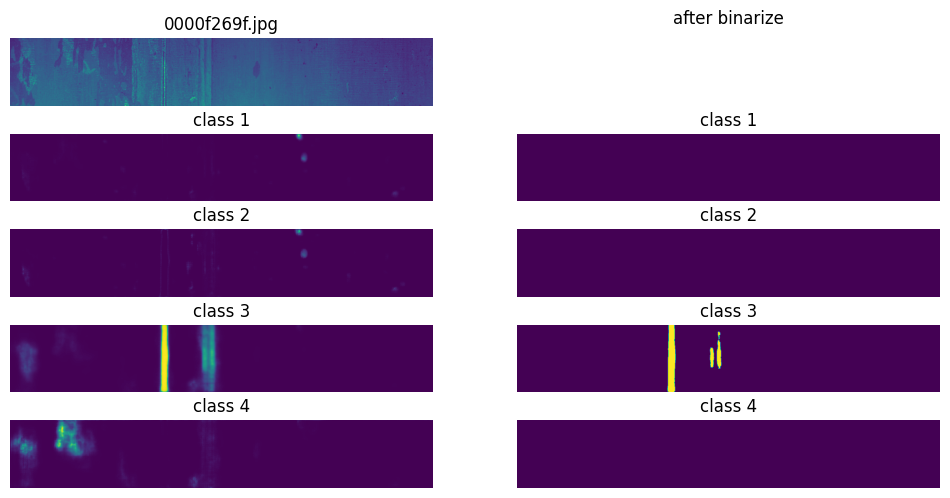

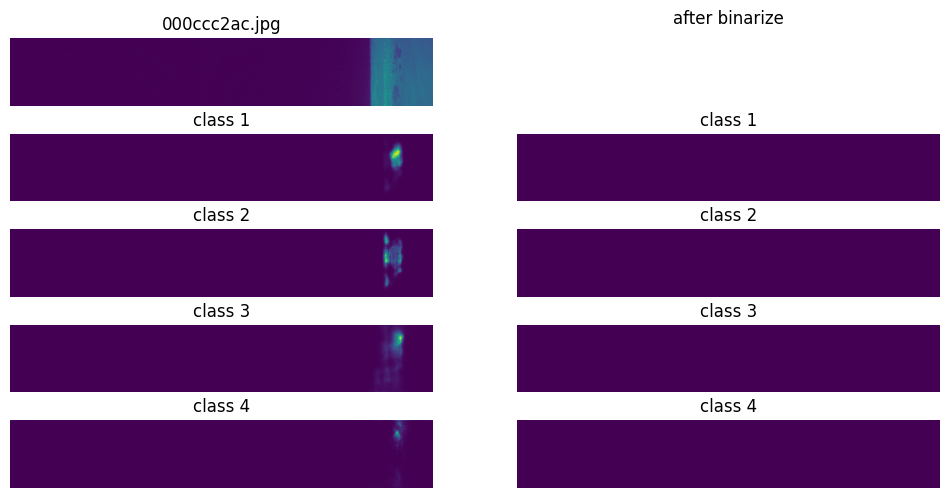

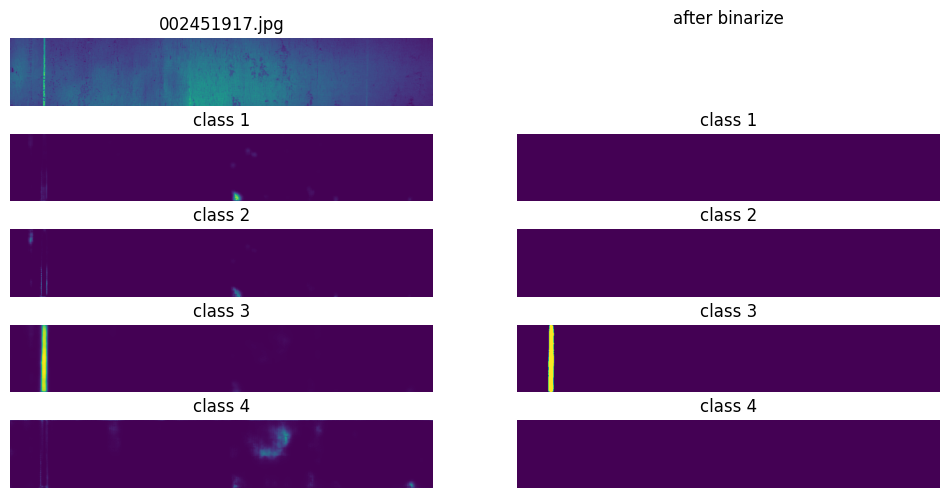

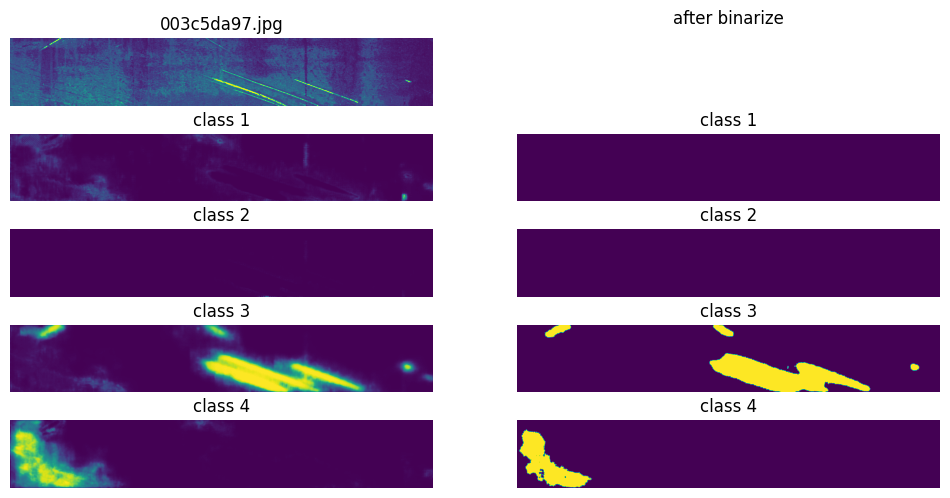

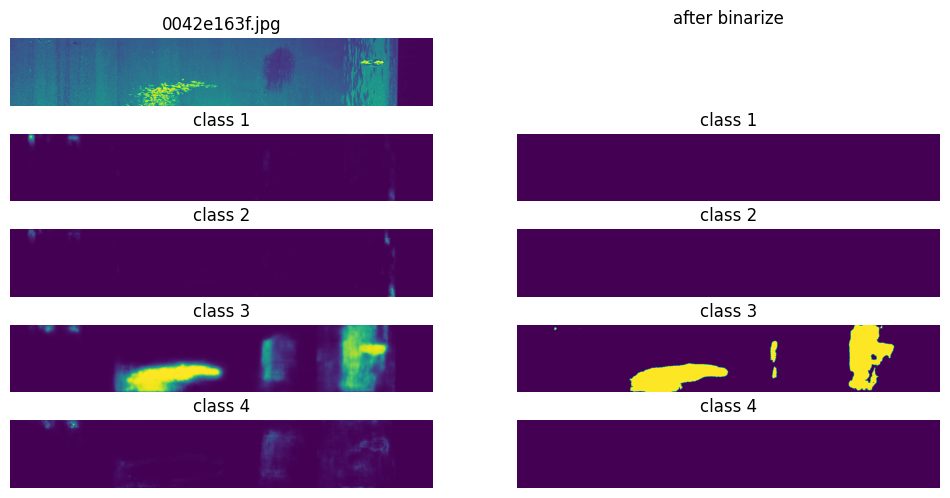

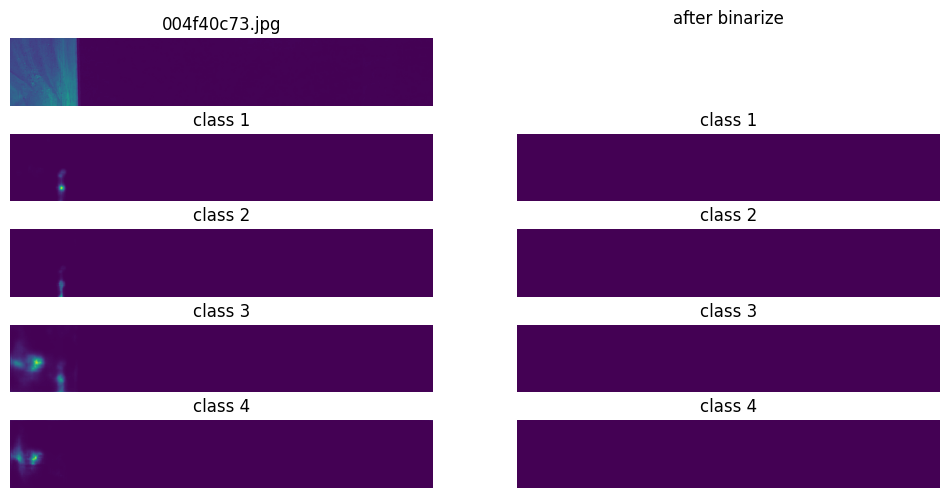

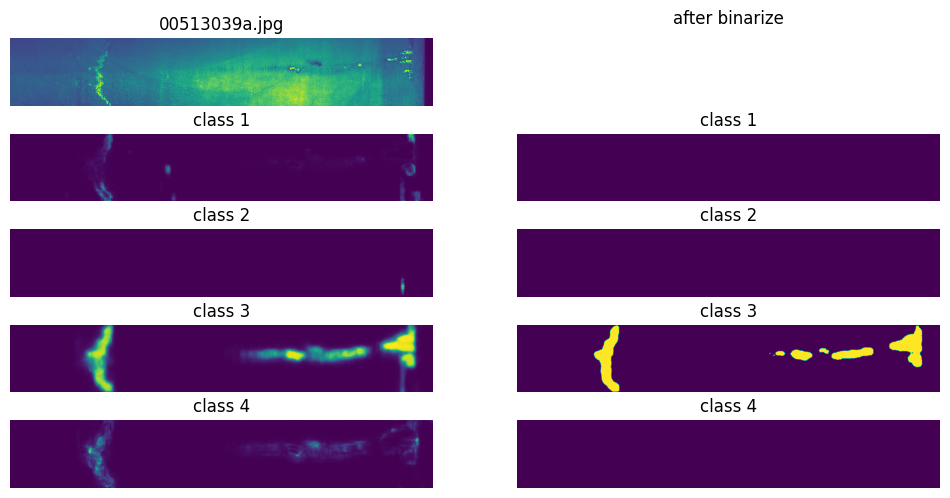

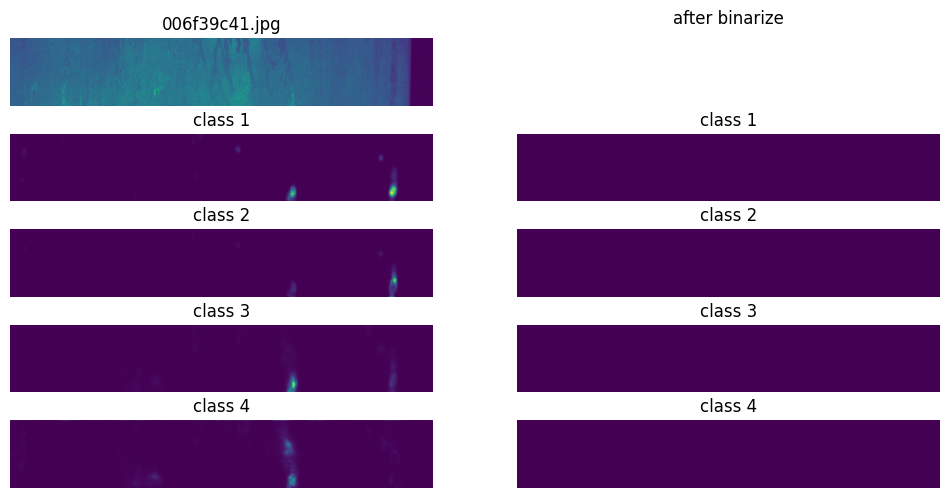

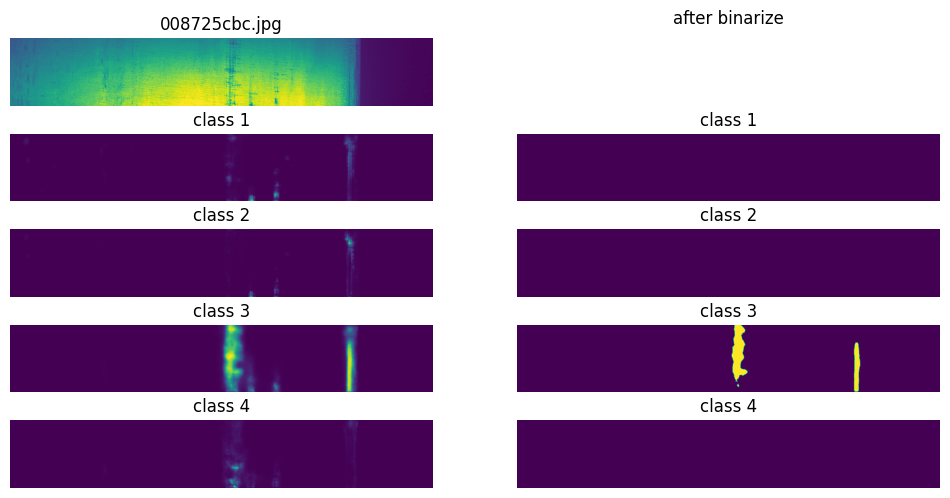

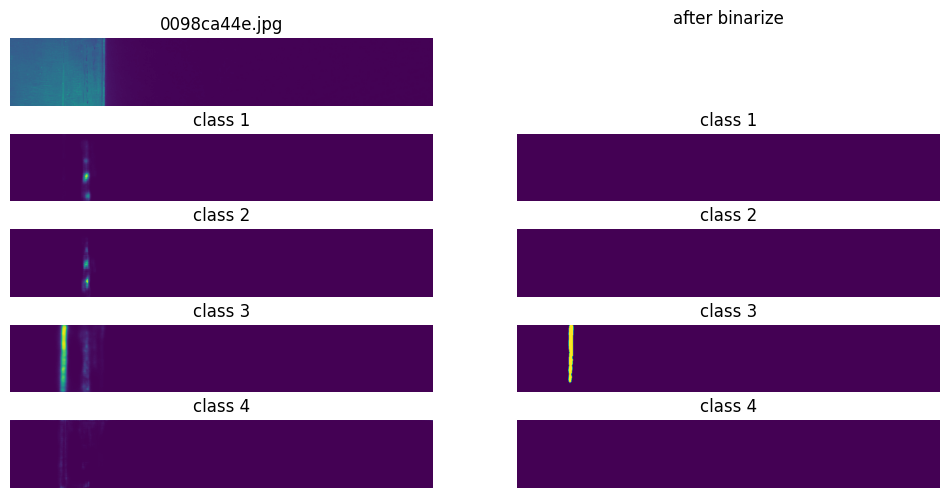

In [13]:
for i in range(0,40,4):
    show_predict_img("submit_df",i)

In [14]:
# Number of Defect Detection
submit_df['EncodedPixels'][submit_df['EncodedPixels'] != ''].count()

5837

In [15]:
submit_df.to_csv('submission.csv', index=False)